In [1]:
# Generic inputs for most ML tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

# setup interactive notebook mode
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, HTML

In [2]:
flight_data = pd.read_csv('latter_flight_data.csv')
flight_data.head()
flight_data.shape

,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,OP_UNIQUE_CARRIER,ORIGIN,ARR_DELAY,SCH_DEP_TIME,SCH_ARR_TIME,ORGIN_WTH_temp,ORGIN_WTH_precip,ORGIN_WTH_precipprob,ORGIN_WTH_snow,ORGIN_WTH_windspeed,ORGIN_WTH_winddir,ORGIN_WTH_cloudcover,ORGIN_WTH_visibility,ORGIN_WTH_severerisk,DEST_WTH_temp,DEST_WTH_precip,DEST_WTH_precipprob,DEST_WTH_snow,DEST_WTH_windspeed,DEST_WTH_winddir,DEST_WTH_cloudcover,DEST_WTH_visibility,DEST_WTH_severerisk,FORMER_FLIGHT_STATUS
0,6,WN,WN,MCO,-26.00,2022-01-01 10:30:00,2022-01-01 13:20:00,74.00,0.00,0,0.00,6.90,200.00,2.90,9.90,3.00,48.00,0.00,0,0.00,3.60,8.00,100.00,9.80,3.00,NaN
1,6,UA,OO,ORD,-25.00,2022-01-01 10:40:00,2022-01-01 13:32:00,36.10,0.00,0,0.02,21.00,20.00,100.00,9.90,3.00,47.90,0.00,0,0.00,0.40,358.00,100.00,9.70,3.00,NaN
2,6,B6,B6,MCO,22.00,2022-01-01 13:13:00,2022-01-01 15:56:00,83.00,0.00,0,0.00,9.90,199.00,4.30,9.90,3.00,47.70,0.00,0,0.00,7.90,311.00,100.00,7.80,3.00,early
3,6,B6,B6,JFK,36.00,2022-01-01 21:45:00,2022-01-01 22:59:00,52.80,0.15,100,0.00,8.10,40.00,100.00,2.20,3.00,37.90,0.02,100,0.00,6.10,303.00,100.00,6.80,3.00,NaN
4,7,B6,B6,JFK,-12.00,2022-01-02 08:29:00,2022-01-02 09:50:00,52.10,0.00,0,0.00,0.00,0.00,100.00,5.90,3.00,25.00,0.00,0,0.01,13.80,303.00,100.00,1.20,3.00,NaN


(6773, 26)

In [3]:
# Drop NaN for latter flight data
if True:
    flight_data.dropna(subset=['FORMER_FLIGHT_STATUS'], inplace=True)

In [4]:
X = flight_data.drop(columns=['ARR_DELAY'])
y = flight_data['ARR_DELAY']

In [5]:
potential_categorical_vars = {}
# For categorical variables if we are considering variables which were coded to integers, but are actually catagorical.
if True:
    for col in flight_data.columns:
        unique_col_vals = flight_data[col].unique()
        if(len(unique_col_vals) < 15):
            potential_categorical_vars[col] = unique_col_vals
potential_categorical_vars

{'DAY_OF_WEEK': array([6, 7, 1, 2, 3, 4, 5]),
 'MKT_UNIQUE_CARRIER': array(['B6', 'UA', 'DL', 'AA', 'WN'], dtype=object),
 'OP_UNIQUE_CARRIER': array(['B6', 'OO', '9E', 'MQ', 'G7', 'PT', 'YX', 'UA', 'WN', 'ZW'],
       dtype=object),
 'ORIGIN': array(['MCO', 'ORD', 'JFK'], dtype=object),
 'ORGIN_WTH_precipprob': array([  0, 100]),
 'ORGIN_WTH_severerisk': array([  3.,  10.,  30.,   5.,  15.,  60., 100.,   8.,  50.,  19.,  25.,
         75.,  38.]),
 'DEST_WTH_precipprob': array([  0, 100]),
 'DEST_WTH_severerisk': array([  3.,  10.,  30.,  60.,   5.,  75., 100.,   8.]),
 'FORMER_FLIGHT_STATUS': array(['early', 'late', 'on-time'], dtype=object)}

In [6]:
# Handle Categorical Variables
categorical_vars = ['DAY_OF_WEEK', 'MKT_UNIQUE_CARRIER',
                    'OP_UNIQUE_CARRIER', 'ORIGIN',
                    'ORGIN_WTH_precipprob', 'ORGIN_WTH_severerisk',
                    'DEST_WTH_precipprob', 'DEST_WTH_severerisk',
                    'FORMER_FLIGHT_STATUS', 'MONTH']

# categorical_vars = potential_categorical_vars.keys()

In [7]:
def preprocess(flight_data: pd.DataFrame):

    # Dealing with date and time
    flight_data['SCH_ARR_TIME'] = pd.to_datetime(flight_data['SCH_ARR_TIME'])
    flight_data['SCH_DEP_TIME'] = pd.to_datetime(flight_data['SCH_DEP_TIME'])

    flight_data['MONTH'] = flight_data['SCH_ARR_TIME'].dt.month
    flight_data['DAY'] = flight_data['SCH_ARR_TIME'].dt.day
    flight_data['DEP_MINUTES'] = flight_data['SCH_DEP_TIME'].dt.hour * 60 + flight_data['SCH_DEP_TIME'].dt.minute
    flight_data['ARR_MINUTES'] = flight_data['SCH_ARR_TIME'].dt.hour * 60 + flight_data['SCH_ARR_TIME'].dt.minute

    flight_data.drop(columns=['SCH_DEP_TIME', 'SCH_ARR_TIME'], inplace=True)

    # Dropping unwanted columns
    cols = [
        'ORGIN_WTH_temp', 'DEST_WTH_temp',
        'DEST_WTH_severerisk', 'ORGIN_WTH_severerisk',
        'DEST_WTH_precipprob', 'ORGIN_WTH_precipprob'
        ]
    flight_data.drop(columns=cols, inplace=True)
    
    cat_col = list(set(flight_data.columns).intersection(categorical_vars))
    flight_data = pd.get_dummies(flight_data, columns = list(cat_col), drop_first = False)

    return flight_data
    

In [8]:
flight_data.head()


,DAY_OF_WEEK,MKT_UNIQUE_CARRIER,OP_UNIQUE_CARRIER,ORIGIN,ARR_DELAY,SCH_DEP_TIME,SCH_ARR_TIME,ORGIN_WTH_temp,ORGIN_WTH_precip,ORGIN_WTH_precipprob,ORGIN_WTH_snow,ORGIN_WTH_windspeed,ORGIN_WTH_winddir,ORGIN_WTH_cloudcover,ORGIN_WTH_visibility,ORGIN_WTH_severerisk,DEST_WTH_temp,DEST_WTH_precip,DEST_WTH_precipprob,DEST_WTH_snow,DEST_WTH_windspeed,DEST_WTH_winddir,DEST_WTH_cloudcover,DEST_WTH_visibility,DEST_WTH_severerisk,FORMER_FLIGHT_STATUS
2,6,B6,B6,MCO,22.00,2022-01-01 13:13:00,2022-01-01 15:56:00,83.00,0.00,0,0.00,9.90,199.00,4.30,9.90,3.00,47.70,0.00,0,0.00,7.90,311.00,100.00,7.80,3.00,early
6,7,UA,OO,ORD,48.00,2022-01-02 10:40:00,2022-01-02 13:32:00,23.50,0.00,0,0.00,11.30,330.00,90.30,6.70,3.00,23.00,0.00,0,0.01,11.20,301.00,100.00,8.50,3.00,late
7,7,DL,9E,JFK,180.00,2022-01-02 12:55:00,2022-01-02 14:12:00,57.20,0.00,0,0.00,10.10,243.00,90.70,9.40,3.00,23.00,0.00,0,0.01,11.20,301.00,100.00,8.50,3.00,early
9,7,AA,MQ,ORD,35.00,2022-01-02 17:25:00,2022-01-02 20:12:00,25.70,0.00,0,0.00,6.40,329.00,24.20,9.90,3.00,24.00,0.00,0,0.01,6.80,338.00,99.90,9.90,3.00,late
10,7,UA,OO,ORD,136.00,2022-01-02 17:55:00,2022-01-02 20:52:00,24.50,0.00,0,0.00,7.70,315.00,24.20,9.90,3.00,21.70,0.00,0,0.01,6.90,343.00,98.60,8.80,3.00,late


In [9]:
X = preprocess(X)


In [10]:
cols1 = [
    "MKT_UNIQUE_CARRIER_DL",
    "OP_UNIQUE_CARRIER_B6",
    "ORGIN_WTH_visibility",
    "ORGIN_WTH_precip",
    "DEST_WTH_visibility",
    "ORIGIN_ORD",
    "DEP_MINUTES",
    "ORGIN_WTH_snow",
    "ORGIN_WTH_cloudcover",
    "DEST_WTH_snow",
    "OP_UNIQUE_CARRIER_OO",
    "DEST_WTH_precip",
    "ARR_MINUTES",
    "DEST_WTH_winddir",
    "OP_UNIQUE_CARRIER_MQ"
]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
subset_data = pd.DataFrame(sc.fit_transform(X[cols1]), columns = X[cols1].columns, index = X.index)
subset_data.shape
subset_data.columns
subset_data.head()

(4732, 15)

Index(['MKT_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_B6', 'ORGIN_WTH_visibility',
       'ORGIN_WTH_precip', 'DEST_WTH_visibility', 'ORIGIN_ORD', 'DEP_MINUTES',
       'ORGIN_WTH_snow', 'ORGIN_WTH_cloudcover', 'DEST_WTH_snow',
       'OP_UNIQUE_CARRIER_OO', 'DEST_WTH_precip', 'ARR_MINUTES',
       'DEST_WTH_winddir', 'OP_UNIQUE_CARRIER_MQ'],
      dtype='object')

,MKT_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_B6,ORGIN_WTH_visibility,ORGIN_WTH_precip,DEST_WTH_visibility,ORIGIN_ORD,DEP_MINUTES,ORGIN_WTH_snow,ORGIN_WTH_cloudcover,DEST_WTH_snow,OP_UNIQUE_CARRIER_OO,DEST_WTH_precip,ARR_MINUTES,DEST_WTH_winddir,OP_UNIQUE_CARRIER_MQ
2,-0.51,2.13,0.32,-0.14,-0.70,-1.23,-0.86,-0.08,-1.37,-0.07,-0.34,-0.14,-0.77,1.04,-0.43
6,-0.51,-0.47,-1.73,-0.14,-0.34,0.81,-1.55,-0.08,0.85,0.11,2.97,-0.14,-1.43,0.94,-0.43
7,1.94,-0.47,-0.00,-0.14,-0.34,-1.23,-0.94,-0.08,0.86,0.11,-0.34,-0.14,-1.25,0.94,-0.43
9,-0.51,-0.47,0.32,-0.14,0.38,0.81,0.27,-0.08,-0.86,0.11,-0.34,-0.14,0.41,1.28,2.31
10,-0.51,-0.47,0.32,-0.14,-0.18,0.81,0.41,-0.08,-0.86,0.11,2.97,-0.14,0.59,1.33,-0.43


In [11]:
X.columns

Index(['ORGIN_WTH_precip', 'ORGIN_WTH_snow', 'ORGIN_WTH_windspeed',
       'ORGIN_WTH_winddir', 'ORGIN_WTH_cloudcover', 'ORGIN_WTH_visibility',
       'DEST_WTH_precip', 'DEST_WTH_snow', 'DEST_WTH_windspeed',
       'DEST_WTH_winddir', 'DEST_WTH_cloudcover', 'DEST_WTH_visibility', 'DAY',
       'DEP_MINUTES', 'ARR_MINUTES', 'MONTH_1', 'MONTH_2', 'MONTH_3',
       'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9',
       'MONTH_10', 'MONTH_11', 'MONTH_12', 'MKT_UNIQUE_CARRIER_AA',
       'MKT_UNIQUE_CARRIER_B6', 'MKT_UNIQUE_CARRIER_DL',
       'MKT_UNIQUE_CARRIER_UA', 'MKT_UNIQUE_CARRIER_WN', 'ORIGIN_JFK',
       'ORIGIN_MCO', 'ORIGIN_ORD', 'FORMER_FLIGHT_STATUS_early',
       'FORMER_FLIGHT_STATUS_late', 'FORMER_FLIGHT_STATUS_on-time',
       'OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_B6', 'OP_UNIQUE_CARRIER_G7',
       'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_PT',
       'OP_UNIQUE_CARRIER_UA', 'OP_UNIQUE_CARRIER_WN', 'OP_UNIQUE_CARRIER_YX',
  

In [12]:
# Check if PCA using SVD gives same results
from sklearn.decomposition import PCA
# initializing the PCA transformer
pca = PCA(n_components = 3)
# dimensionality reduction:
data_pca = pd.DataFrame(pca.fit_transform(subset_data), index = subset_data.index)
data_pca.head()

,0,1,2
2,-0.85,-1.90,0.16
6,3.14,-0.53,1.18
7,0.32,-2.30,1.22
9,0.72,0.68,-1.56
10,0.89,0.25,-1.02


<Figure size 1000x600 with 0 Axes>

Text(-0.8508693166044506, -1.902971900358631, '2')

Text(3.1357779780384956, -0.5345640209010115, '6')

Text(0.3198894344512361, -2.295907047989746, '7')

Text(0.7207230501071248, 0.6781129046525796, '9')

Text(0.8867062712689159, 0.2524001783965527, '10')

Text(2.4474274467192916, -1.7305868114025775, '12')

Text(0.6738164264098605, -0.45347831583120357, '15')

Text(1.1325572382371405, 0.2976342958238734, '16')

Text(0.7178145601851142, 0.6855873183358949, '17')

Text(0.3934920645925136, 0.9081939457093596, '18')

Text(-3.1871191332118523, 0.6014866091159548, '19')

Text(-0.348924699691009, -2.9442128455072476, '22')

Text(0.8809346367654752, 0.3365638080366713, '24')

Text(0.2287161136172336, 1.0003297133352458, '25')

Text(0.9307650337885357, 1.210388781807513, '26')

Text(-3.061011741287297, 0.6052229096353048, '27')

Text(0.46107304187880976, -1.110369535284266, '30')

Text(1.2645646375607316, 1.3310299825907745, '31')

Text(0.36628993533982757, 1.0069581404167536, '33')

Text(-2.7791316411596974, 0.14835640502468717, '34')

Text(2.4723154318943847, -1.3586912637387454, '37')

Text(0.12828426280282273, -2.1781849517431535, '38')

Text(2.1365565002262668, -0.809634044503272, '39')

Text(1.1132220146740017, 0.06340808974129367, '40')

Text(0.2631888402119227, 1.0371395977110878, '42')

Text(1.0283844583631947, 1.1514420129052638, '43')

Text(-1.9688571618151236, 1.986050551666161, '44')

Text(2.511457628290285, -1.4135342803356765, '46')

Text(0.8794474103704711, 0.037199486656644465, '48')

Text(1.1638414352104662, 0.9007898973893274, '50')

Text(-2.8228773042749022, 0.07309509984641013, '51')

Text(2.769110923580689, -0.4807655615524949, '54')

Text(-0.4825945791019077, -2.81470491452486, '55')

Text(0.9464040188652547, 0.4889862006257813, '56')

Text(1.2505248047064579, 2.0712211285158033, '58')

Text(0.3279338982983607, 2.1249850261921175, '59')

Text(-3.098818407949558, 0.2171283316937117, '60')

Text(2.5203038446980646, -1.0823085685405005, '63')

Text(0.27528008061076353, -2.216033049846494, '64')

Text(2.136037875848349, -0.8037168069852906, '65')

Text(0.714825464331562, -0.45025184588233413, '66')

Text(-0.16864245049031143, 0.08892896974021887, '68')

Text(-2.704756613859523, 0.3702943792424869, '69')

Text(-0.07826003605034725, -2.859788853604664, '72')

Text(1.855149304972613, -1.0653051534607285, '73')

Text(0.5021692657013619, -0.5975499214201951, '74')

Text(-0.0653954271574871, 0.2520412246187498, '76')

Text(-2.693046943948099, 0.3390447073962779, '77')

Text(-0.16667301529574088, -3.055427865637911, '80')

Text(2.2665705524286066, -1.022952654714512, '81')

Text(0.549234481679158, -0.23366677520879575, '82')

Text(-0.05197000422608288, 0.8106969873516504, '84')

Text(0.7296986655721375, 0.9000194060384974, '85')

Text(-3.1566855009578845, 0.4307295087785721, '86')

Text(-0.15192577788074818, -2.9001301721987707, '89')

Text(1.1013727665425344, 0.231266111330889, '90')

Text(0.45163071623451023, 0.8569458665694333, '92')

Text(1.3604861958606969, 1.2726074829672012, '93')

Text(-2.7548695768483875, 0.4702821457699342, '94')

Text(2.781074275354282, -0.6161041233020599, '97')

Text(-0.22876955425554507, -2.554198333227788, '98')

Text(2.307453528067321, -0.008312613173091371, '99')

Text(0.8291170538270753, 0.6754954674928333, '100')

Text(0.5582617094380019, 0.7259115361174886, '102')

Text(0.9770733658563268, 1.7248458835480784, '103')

Text(-3.0921922367770054, 0.8999970074899597, '104')

Text(3.10406495719602, -0.9221872746280994, '107')

Text(-0.007016670871662218, -3.1112191830733615, '108')

Text(2.610667156800008, -0.41890958311432486, '109')

Text(1.2915701818135983, 0.023425197980759333, '110')

Text(0.6592349733178101, 1.0208824001283603, '112')

Text(1.428548854380819, 1.1289398161957032, '113')

Text(-2.7734877789586942, -0.041986237660437714, '114')

Text(3.001317813185889, -0.958738368339914, '117')

Text(-0.11745407529758492, -3.1341878087717197, '118')

Text(1.2022880631141173, -0.06858914374130871, '119')

Text(0.5425583989614315, 1.0859180709368808, '121')

Text(-0.3800325074466652, 1.1396819686131947, '122')

Text(-3.2692513538787016, 0.6014261515786488, '123')

Text(0.12694615980192633, -2.2021844103103447, '126')

Text(2.1626208100572892, -0.1902109085109893, '127')

Text(0.8701058192396696, 0.2123996466949685, '128')

Text(0.2033661954029796, 1.2314541392355176, '130')

Text(2.723732990815047, 0.09845345738036504, '133')

Text(1.3910948648631032, 0.617909319144197, '134')

Text(0.6377072100450535, 1.2318024525957663, '136')

Text(1.4693155386430268, 1.3365964656826206, '137')

Text(-2.195566698471206, 0.989340448934591, '138')

Text(0.4069237898373705, -2.4680974063880234, '141')

Text(2.4805663098919832, -0.5521533340263997, '142')

Text(0.986789919472617, -0.21024824610160017, '143')

Text(0.2402498917696923, 0.8132909838268592, '145')

Text(0.8640518166179885, 1.1420050357089364, '146')

Text(-3.1372555284591046, 0.27541499021081106, '147')

Text(-0.17663535535117134, -2.862660177437778, '150')

Text(0.9868481304107363, 0.05010430780543637, '151')

Text(0.06359990840991508, 0.39073543996306404, '153')

Text(0.8864512073255071, 0.41760786738159067, '154')

Text(-2.757672177154909, 0.16650475899034073, '155')

Text(0.75255618775437, -1.207870289460469, '158')

Text(2.099891140713793, -1.001181965337268, '159')

Text(0.8304457509258961, -0.538951631300647, '160')

Text(-0.2853289539002042, 1.0782775520907617, '162')

Text(0.5696259288857151, 1.3247246967561328, '163')

Text(-3.082938519302516, 1.0070512429488545, '164')

Text(2.2389245665435396, -0.7447647484363654, '167')

Text(-0.4649137591727715, -2.425510238559532, '168')

Text(2.4379527155325795, -0.7479742302895048, '169')

Text(0.9186457370600375, -0.5369028797316031, '170')

Text(-0.3895493595096196, 0.8209531933981237, '172')

Text(0.39349206459251296, 0.9081939457093604, '173')

Text(-3.001517838393503, 0.4855863578736198, '174')

Text(2.836328361253762, -0.06200522975561631, '177')

Text(-0.4855514999537397, -2.6843703924644275, '178')

Text(1.0046464131429627, 0.5438046291243, '180')

Text(-1.2159967266053915, -0.20324383730682993, '181')

Text(1.1454189257013925, 1.2360254129105466, '182')

Text(0.22282801929329604, 1.2897893105868605, '183')

Text(-2.862869653698353, 0.2753380539369393, '184')

Text(3.1860213228053147, -0.4414649187734506, '187')

Text(0.132716976208071, -2.5906337703031648, '188')

Text(2.278187289019562, -0.8035254464156257, '189')

Text(0.9314178573089342, -0.2673129049273232, '190')

Text(0.49193393459081236, 1.1073438532728548, '192')

Text(1.1984953514773047, 1.050365418040822, '193')

Text(-2.18418148274457, 1.291235807715963, '194')

Text(0.17038535358455625, -2.2588644915336076, '197')

Text(2.422925779792388, -0.14034345151984573, '198')

Text(1.0416190678169537, 0.42228752492253885, '199')

Text(0.05779664631680945, 1.2851944963414732, '201')

Text(0.8263406222815332, 1.3857659538442844, '202')

Text(-2.511527112017349, 1.3448711070644686, '203')

Text(0.6405843825644865, -1.9510074923540721, '206')

Text(2.244500732068138, -0.540449586439678, '207')

Text(0.694962569837658, -0.4409465263070818, '208')

Text(-0.17639410694968943, 0.07112106076083564, '210')

Text(0.7130103821640565, 0.4210904639536316, '211')

Text(-2.7319345894150437, 0.5038936568882944, '212')

Text(-0.1835455530930151, -3.142336995098781, '215')

Text(0.2310847425738677, -0.17421732169651746, '216')

Text(-0.35599330155644326, 0.8609603557870031, '218')

Text(0.6137427078777737, 0.6650944810151852, '219')

Text(-3.164710614537352, 0.3170483177230248, '220')

Text(2.9578986616356286, -0.3042107948182305, '223')

Text(-0.11419324607771475, -2.606015455029687, '224')

Text(2.5188081841904864, 0.12536786661125895, '225')

Text(1.1722561231258288, 0.609335975218557, '226')

Text(0.47404461659887026, 1.2554501188993161, '228')

Text(1.270813583740127, 1.3218742074544456, '229')

Text(-2.3760061589893047, 0.8251850962195862, '230')

Text(0.9706427711261361, -0.6723840283676318, '233')

Text(1.004347547145566, -0.1663510838380103, '234')

Text(0.06422737476199054, 0.18762946614776427, '236')

Text(0.8472687988641232, 0.2748702184590008, '237')

Text(-1.6817825677065874, 2.587993179193575, '238')

Text(2.8590684677937164, -1.2324482089509776, '240')

Text(1.0704690084320843, -0.18856691685375718, '242')

Text(-1.6369753283859527, -1.2943142045939398, '243')

Text(1.1806063171005896, 0.8315255014463668, '244')

Text(0.25801541069249256, 0.8852893991226805, '245')

Text(2.9138018692126497, -0.8697259294951188, '248')

Text(2.4709098909012464, -0.41865128686904823, '249')

Text(1.1912539373561135, 0.11827702101455473, '250')

Text(0.3055078616254645, 1.0918845657251801, '252')

Text(1.0363846221789261, 1.2582286403096232, '253')

Text(0.02790503593177369, -3.172828467403772, '256')

Text(2.0970790986377152, -0.19710634407102726, '257')

Text(0.5667547315863614, 0.11981612438781723, '258')

Text(0.18542128974196076, 1.2867339343514281, '260')

Text(1.048082463471012, 1.2532380368772442, '261')

Text(-3.107266346017039, 0.35578951925658686, '262')

Text(-0.445858759657588, -2.85642829310408, '265')

Text(1.0888991309582703, 0.8254448555270449, '266')

Text(1.1011244163257141, 1.2456701192820567, '268')

Text(-2.480091585326491, 1.0262210650612817, '269')

Text(0.35272412366117467, -1.8310361295344957, '271')

Text(1.2487308028628443, 1.3398490253280384, '274')

Text(-2.3847382245066138, 1.1023769821407845, '275')

Text(0.9208347068479592, -0.8221523673468868, '278')

Text(0.6716299446019438, -1.481015546449787, '281')

Text(2.6509606212249817, -0.09798223763026333, '282')

Text(1.2824787025424789, 0.32559928508105407, '283')

Text(1.7185260628432446, 1.9355562327468692, '285')

Text(2.9584999120361317, -0.9288532949501288, '287')

Text(1.0692133886454795, -0.07479567473120503, '290')

Text(-0.9561156136413572, -0.6312934073642767, '291')

Text(0.39349206459251296, 0.9081939457093604, '292')

Text(-3.1967836159217917, 0.3650992091145941, '293')

Text(2.7902539818605345, -0.6823759556901567, '296')

Text(-0.38917693446137414, -2.930146035824936, '297')

Text(0.8912549815313235, 0.19564838934566195, '298')

Text(0.5843049128363341, 0.6188423194994739, '300')

Text(-2.8939338016877074, 0.4249866794112252, '301')

Text(2.80685780441999, -0.6468752636574878, '304')

Text(0.4102245512436811, -1.4852420603454983, '305')

Text(0.8864020845494499, 0.3877023337982668, '306')

Text(0.519785460552452, 0.7166806391531763, '308')

Text(-0.2383218690399012, 1.1664174330037171, '309')

Text(-2.498616998190417, 1.6216217615142126, '310')

Text(-0.0549070003834192, -2.6964231626338715, '313')

Text(2.1601584162822527, -0.8966684261863724, '314')

Text(1.0616150211043236, -0.028985613627157583, '315')

Text(1.2163494043021725, 0.6803412473686629, '317')

Text(1.0910273791531913, 0.8147965630788794, '318')

Text(-2.9855437264999414, 0.05176339405168166, '319')

Text(-0.3865017778280415, -2.960421560817609, '322')

Text(2.3549083178121246, -0.2573057565169345, '323')

Text(1.0004931804389972, 0.2374158134734632, '324')

Text(1.2550539399939493, 0.9822200110578798, '326')

Text(1.126986406237144, 1.1208386595193174, '327')

Text(-3.069281739038596, 0.1787450429639343, '328')

Text(2.990124366510583, -0.8159138480258165, '331')

Text(-0.2519015040701359, -3.138312673386006, '332')

Text(1.1687902160990609, 0.15175624777684885, '333')

Text(0.3094112914819733, 0.9913834845580508, '335')

Text(0.6913934887328043, 1.4940197905590449, '336')

Text(-2.4386971876445775, 0.6330921184501829, '337')

Text(1.9393348011297336, -0.5964201907576144, '340')

Text(-0.3962753313360849, -2.9386090894072, '341')

Text(2.343926283380826, -0.2406524255120487, '342')

Text(1.1802145773591346, 0.054638376980967886, '343')

Text(0.21313604313938228, 1.0444342849519834, '345')

Text(-2.8664174337089907, 0.36710536400813326, '346')

Text(1.6229844922899737, -1.3806236900542568, '349')

Text(-0.23703304957024712, -3.1557879986922286, '350')

Text(1.212531239129667, -0.3102861746654908, '352')

Text(-1.4748290314155703, -0.889979921790109, '353')

Text(1.3546533784967503, 0.9035583560354381, '354')

Text(0.3672732600380192, 1.0226165684691246, '355')

Text(-2.535246154857316, 0.40257641341216466, '356')

Text(2.0943623958528144, -0.8305712253759124, '359')

Text(0.9964787897040794, -0.6984689738219926, '360')

Text(1.1091141867357917, -0.5506972666557345, '361')

Text(0.05047186873630918, 0.6245513438030516, '363')

Text(-2.0548500356568793, 0.9178922427693583, '364')

Text(2.1229435463768405, -0.831149275895158, '367')

Text(-0.21395720370256147, -3.174876911559699, '368')

Text(1.2931443311887771, -0.21973766627743638, '369')

Text(0.23864108158085656, 0.9753797059598476, '371')

Text(0.8835039691806426, 1.879664173776831, '372')

Text(-2.7576712821758895, 0.40939664374504203, '373')

Text(-0.11516222187566223, -2.797293450195958, '376')

Text(2.4011882821019284, -0.39144370429076436, '377')

Text(1.3204809906832493, -0.3691308436875491, '378')

Text(0.9936550859928952, 0.9979936399397947, '380')

Text(-0.05521697691665947, 1.1753098929749575, '381')

Text(-3.16926088475144, 0.325231502996926, '382')

Text(-0.3617218483831266, -2.971779363337151, '385')

Text(2.4078939919435487, -0.16810534666225047, '386')

Text(1.229081988578821, 0.15008378596248376, '387')

Text(1.276969703921023, 1.2860898557938123, '389')

Text(0.21574285227625623, 1.4821411062094711, '390')

Text(-2.435588490768995, 0.9342649173077662, '391')

Text(-0.14107008761567602, -2.6604190162559718, '394')

Text(2.531822380296261, 0.16684243057186912, '396')

Text(1.5879181991470361, 1.4433955215225784, '397')

Text(0.7211962536528449, 2.4658459175933576, '398')

Text(1.646896683201685, -1.2143080293223134, '401')

Text(0.4518348787927857, -2.1402439128910817, '402')

Text(2.3659156326435875, -0.41513445071267485, '404')

Text(1.123726772672091, -0.3442203971132663, '405')

Text(0.04311543604075405, 1.0808146557554552, '406')

Text(0.3175685500139821, 1.5321364065394156, '407')

Text(1.581524976595353, -1.315228235709978, '410')

Text(0.3590725358454855, -2.330256458959248, '411')

Text(0.8715303983196131, -1.2918059934209243, '413')

Text(1.0754338761507098, -0.1432055021860896, '414')

Text(0.9248131246019501, 0.4457893603688604, '415')

Text(-0.06256699385678047, 0.5648475728025469, '416')

Text(-0.3617218483831266, -2.971779363337151, '419')

Text(1.8897228048055257, -0.8156408537994603, '421')

Text(0.752292701765806, -0.45183254008667295, '422')

Text(-0.09638581661065722, 0.7950820306950851, '423')

Text(0.4735133810717712, 1.4573523865252132, '424')

Text(2.0684384384723735, -0.5274856634180729, '427')

Text(-0.29211027761940084, -3.0895749271724764, '428')

Text(1.0127888279423343, 0.5405154080182544, '430')

Text(0.039492221083392044, 1.2619855488743632, '431')

Text(0.43658468323240024, 1.899556905158869, '432')

Text(-0.004448138950447482, -1.728237285447186, '435')

Text(1.5497296734794108, 1.3272593244642774, '437')

Text(1.2932791361855642, 1.0604959861805985, '438')

Text(0.21304564860395644, 1.1491279322149899, '439')

Text(0.36869866898635106, -2.4357233898911193, '442')

Text(2.5936732124327926, -0.20942290798035326, '444')

Text(1.4785536621713466, 0.22571186238901245, '445')

Text(0.38109443541608673, 0.9457859676597178, '446')

Text(2.3096847936711304, -0.733857081499677, '449')

Text(0.509952162789379, -2.5964049811570553, '450')

Text(2.2651742062988665, 0.42878677787979647, '452')

Text(1.5325073517056638, 0.07043433843105561, '453')

Text(0.2757428852825389, 1.9609292902640825, '454')

Text(0.3149304660993531, 0.7851657555199925, '457')

Text(0.06869154862991786, 1.2414013626164366, '458')

Text(1.5498621870823226, -1.39541812800794, '461')

Text(-0.2701462087568027, -3.1228815891822475, '462')

Text(0.5018429285649573, -1.6634554078906487, '464')

Text(0.8229229953301204, -0.45407454166497224, '465')

Text(0.5798265377412548, 0.22323121754186656, '466')

Text(-0.40755358071747644, 0.3422894299755531, '467')

Text(1.651955850290637, -1.1339411303996, '470')

Text(-0.21064292679675078, -2.9121829130674857, '471')

Text(2.105634406357213, -0.6604276033390535, '473')

Text(0.9110964077066744, -0.6666846312126942, '474')

Text(-0.14019575085694427, 0.35986163236087043, '475')

Text(0.1350673016242672, 0.6002041788376082, '476')

Text(1.983556844109799, -0.9973328735105016, '479')

Text(-0.22236608426380575, -3.1683660940427307, '480')

Text(2.3014533929704046, -0.38424893729225096, '482')

Text(0.9687978851244348, -0.6952400979534035, '483')

Text(-0.09244432443648257, 1.2348259660485394, '484')

Text(0.31393355034078285, 1.743039895290343, '485')

Text(0.21850469032891812, -2.313470074136616, '488')

Text(2.3072258180840186, -0.2881268338288879, '490')

Text(1.1062705172099916, -0.1755060510552134, '491')

Text(0.9839406872535134, 0.5037147478192588, '492')

Text(-0.03922461970468887, 0.7382081814692736, '493')

Text(-0.13342862609853265, -3.3455219650281713, '496')

Text(2.3554653859167796, -0.43777512140724323, '498')

Text(1.1866029941565908, -0.178371862606073, '499')

Text(0.4912684841547363, 1.3674595032551233, '500')

Text(2.0057533432300656, -0.935803993056751, '503')

Text(-0.20402157191134063, -3.127966032748039, '504')

Text(2.4369826195427273, -0.5885973716071453, '506')

Text(1.254425802781266, -0.2658997767261433, '507')

Text(0.24470149060480384, 0.8931214361518099, '508')

Text(1.932236518748446, -0.9292226382622996, '511')

Text(-0.2591641743255039, -3.1395349201871334, '512')

Text(2.468004224811552, -0.4660902997426903, '514')

Text(2.1389291871434457, -0.11269652206561896, '515')

Text(0.1663855581232253, 1.0139405240161155, '516')

Text(1.6631766751816188, -0.5212160286426037, '519')

Text(-0.5224162386312042, -2.7246039940001316, '520')

Text(0.16555383457447018, -1.4471526987956522, '522')

Text(2.137722181289827, -0.13479410172401413, '523')

Text(1.9278417863864163, 0.22313108184817643, '524')

Text(-0.04470184263380428, 1.3497681279299112, '525')

Text(2.0134110308575965, -0.7427613181716456, '528')

Text(0.35655031796082925, -2.273816199584024, '529')

Text(2.4230200948279204, -0.3821443272777887, '531')

Text(0.23898904756576184, 0.8811204172578652, '532')

Text(2.132598503251649, 0.5201288875761252, '535')

Text(-0.2650373089502734, -2.596931294394632, '536')

Text(-0.31851620172099876, -1.9891985098869924, '538')

Text(1.9196054916569287, 0.5403873934244233, '539')

Text(0.4639438388831316, 1.3851168030389667, '540')

Text(-0.20322924815929774, -3.2097795891668612, '543')

Text(1.9573072446317825, -0.33006688512932314, '545')

Text(-0.7876698966058329, -2.6377256330559997, '546')

Text(1.9669492104165658, -0.7118824635597466, '547')

Text(-0.19409708008457166, 1.391033382298227, '548')

Text(0.8354885305053052, 0.24965407587744454, '551')

Text(1.8101499624273087, 0.6341391660340256, '553')

Text(0.42662668169952317, 1.4094725297860544, '554')

Text(1.6341911067937427, 0.46132425220886975, '555')

Text(0.1351641975177718, 0.7776182648716761, '556')

Text(2.0700979780467543, -0.7834491631222292, '559')

Text(-0.18239461641021623, -2.9357179583246227, '560')

Text(2.5377797126354005, -0.38661890432558577, '562')

Text(-0.874153417752313, -2.5065806513925257, '563')

Text(2.376333188709426, -0.26469663562213525, '564')

Text(0.5373945658558058, 1.4612791399006257, '565')

Text(1.65219464075032, -0.5045626976377182, '568')

Text(-0.5317164255301634, -2.7238919040750873, '569')

Text(2.1102670952115803, -0.09316077421180026, '571')

Text(-0.98437266080111, -2.3516779200228517, '572')

Text(2.0417803936111443, 0.05035277267248914, '573')

Text(0.18906842659964218, 0.8273020470075199, '574')

Text(0.4562251254965686, 0.46578182863235046, '577')

Text(0.5332092174663852, -1.7249921418957277, '578')

Text(-0.16353190205811627, -1.7861076271834302, '580')

Text(-0.10682253532540062, 0.40166728134811047, '581')

Text(1.3617949619397487, -1.434569228471697, '583')

Text(1.8212401707049208, -1.0252489714213895, '586')

Text(-0.9221998183892466, -2.4337223282461524, '587')

Text(-0.7728999763708126, -1.2335841088315105, '588')

Text(-0.10818685939427009, 0.7719664735570447, '589')

Text(1.8924266439349868, -0.8688543133695898, '592')

Text(-0.29406565757266334, -3.091260993836871, '593')

Text(-0.9757372362418293, -2.352537339597335, '595')

Text(2.020051306424228, -0.10197694589098966, '596')

Text(0.13289985214454028, 1.0000455538686885, '597')

Text(-0.4863255256946443, -2.593698377485834, '600')

Text(1.4533338521525123, 0.08615693535163467, '602')

Text(-1.1554009941616927, -2.0627854608876577, '603')

Text(1.8832379061421203, -0.8245793816592879, '604')

Text(-0.08988844911195953, 0.2998391933604141, '605')

Text(-0.5904135313250801, -2.6245674732002864, '608')

Text(1.9511459238955304, 0.5549866672639436, '610')

Text(-1.1352113608508145, -2.129935425486811, '611')

Text(1.8839136486612198, 0.28974440586771866, '612')

Text(-0.2715337805790603, 1.094201395367248, '613')

Text(1.8767746028707917, -0.6755705847343716, '616')

Text(0.2832813626589553, -2.1579023906005883, '617')

Text(2.3642266414353705, -0.4782690536997786, '619')

Text(-0.25957112801954746, -1.1394873816307154, '620')

Text(2.073588724276811, -0.18316193453980636, '621')

Text(-0.2032956767603151, 1.387503029974664, '622')

Text(2.1681502751726724, -0.9863228951565809, '625')

Text(-0.07465275414594577, -3.1353074668038907, '626')

Text(2.7446361175763494, -0.1798170612571138, '628')

Text(-0.7522129100592598, -2.7107203442821945, '629')

Text(0.2037414273024353, 2.049776891196871, '630')

Text(1.9788797010464982, -0.5668823114952921, '634')

Text(-0.5832661621031889, -2.2590446490887204, '635')

Text(-0.455308987411454, -2.8674444553864347, '636')

Text(2.5014708695863974, -0.06811645232266932, '637')

Text(-0.7833625938810941, -2.17672484820276, '638')

Text(2.1518312201021303, 0.3024004540737747, '639')

Text(0.35188161314205185, 1.1806152759259445, '640')

Text(1.536878087493701, -1.3759031052328081, '643')

Text(0.4964542268483861, -2.2319113164183735, '644')

Text(1.9289763861069393, -1.1407764453474998, '646')

Text(-0.1988205496773766, -1.7362092978719537, '647')

Text(-0.6216986088109528, -1.335976710883887, '648')

Text(-0.03720312174115242, 0.5518306960570911, '649')

Text(1.9885194452088542, -1.0145709596623385, '652')

Text(-0.1979728562987966, -3.2369776401296213, '653')

Text(-0.819999786682705, -2.5454683912372067, '655')

Text(2.1586994911193793, -0.31222524982766947, '656')

Text(0.232618096188172, 0.8698063287925129, '657')

Text(-0.17577416208105034, -3.2514129166790746, '660')

Text(2.3255085938072706, 0.17956893407660876, '662')

Text(-0.813752228380168, -2.598173971919397, '663')

Text(2.3118137364255436, -0.16685831596843292, '664')

Text(0.38120119717552736, 1.1014394256562419, '665')

Text(-0.47908251127119583, -2.7652524554276607, '668')

Text(2.2337929046266707, 1.2186339813260152, '670')

Text(-0.47940155505379356, -1.3852304243018656, '671')

Text(2.044329411487959, 0.4934721493393183, '672')

Text(0.06906374420766033, 1.6904876675293363, '673')

Text(1.881484239486655, -0.20301541302769652, '676')

Text(0.34629691316092737, -1.2685699143154314, '677')

Text(2.3957159702997735, 0.5106845029172656, '679')

Text(-0.26317773567655867, -1.0660947987454423, '680')

Text(1.9857140024398359, 0.4943520319737431, '681')

Text(0.12247606502833737, 1.7021210994949996, '682')

Text(2.003384760876208, -0.851832909220806, '685')

Text(0.07243474685813181, -2.7695696607266247, '686')

Text(2.572413270358295, -0.21264435721403638, '688')

Text(-0.23561446107385317, -1.7601568110586159, '689')

Text(2.2745198271098945, -0.049819236973746815, '690')

Text(0.3517493013402561, 0.8179820646728001, '691')

Text(2.0684471628830687, -0.7242610828287088, '695')

Text(-0.5194505858847528, -2.413497125123372, '696')

Text(0.18590679382914277, -2.3209510484267266, '697')

Text(2.6198669100103706, -0.45441247294431786, '698')

Text(-0.19443183195648145, -1.8226068023269368, '699')

Text(2.3249728556229297, -0.14873214574852112, '700')

Text(0.3104422670231631, 1.0034937240011266, '701')

Text(1.8350540284647237, -0.9186607002814776, '704')

Text(0.5145777331013107, -2.231393790612308, '705')

Text(2.14099867040005, -0.8390347906243638, '707')

Text(-0.12010772336357955, -1.624001541569851, '708')

Text(1.9326531885381304, -0.26141289042897436, '709')

Text(-0.4528785439046359, 0.9631855565237477, '710')

Text(1.9820472618896785, -0.8488440429370097, '713')

Text(0.544162205915871, -2.067928749065407, '714')

Text(0.00620824675184297, -1.3220892951328151, '716')

Text(2.326926389804974, 0.2402677949865804, '717')

Text(-0.05214533262469196, 1.0560397170897404, '718')

Text(-0.19935739531854624, -3.205163378121991, '721')

Text(2.376300503052029, 0.10254727817901348, '723')

Text(-0.25491480169842123, -1.931900844443064, '724')

Text(2.2646520611297043, -0.09071814020332841, '725')

Text(0.03095844318194131, 1.3075716361051224, '726')

Text(-0.3174031933802422, -2.646857133384358, '729')

Text(2.3318682631419874, 2.245414194643875, '731')

Text(-0.5165712710608982, -1.470447603539338, '732')

Text(2.332453162487244, 2.1731765771809415, '733')

Text(-0.018189837437805133, 2.772454305593044, '734')

Text(2.0453005852132624, -0.5531289038062641, '737')

Text(0.31110663307828107, -2.2042266307092104, '738')

Text(2.4757702656950356, -0.1830642295760893, '740')

Text(-0.293611873926536, -1.4557185878824477, '741')

Text(2.1210054198233355, 0.13541018410221098, '742')

Text(0.14239485898924073, 1.444243286157055, '743')

Text(2.0657676541814216, -0.9074694723643985, '746')

Text(0.4291438531453774, -2.316076193750879, '747')

Text(2.6029215353523236, -0.2043790329782776, '749')

Text(-0.16130134663999232, -1.4899032388925564, '750')

Text(2.1149893441167458, -0.18524042546963293, '751')

Text(-0.23820752000170115, 0.832089167214799, '752')

Text(2.100501518172525, -0.9023727586496353, '755')

Text(-0.3013494494497938, -3.022254512730478, '757')

Text(2.6330440021010757, -0.35168960553640033, '758')

Text(-0.6451387869951611, -2.464074789512696, '759')

Text(2.516137724301952, 0.9343711004505859, '760')

Text(2.1523002650762217, -0.9189165763441612, '763')

Text(0.6391170103896928, -1.5837039517953406, '764')

Text(2.63640511348684, -0.34168860989192373, '765')

Text(-0.17198314908483678, -1.8197091569448345, '766')

Text(2.2594699943605017, 0.034592865766857814, '767')

Text(-0.0022293595466973885, 1.1972787601797241, '768')

Text(2.0224423656618513, -0.8504237732849995, '771')

Text(-0.0659313172979866, -2.8638881198912713, '772')

Text(-0.7371133253572913, -2.32460314234678, '774')

Text(2.2051525236718126, -0.017472965397776083, '775')

Text(-0.29026606393355664, 1.7946815679980248, '776')

Text(1.809133506745695, -0.19982259499530933, '779')

Text(0.04253770421956299, -1.8607583586271572, '780')

Text(-0.5226843839721984, -1.3178477317748458, '782')

Text(1.682213250598102, 0.9941724784362158, '783')

Text(1.8830924846976687, 0.44270590061379045, '784')

Text(-0.1956840485140559, 1.6612522326641677, '785')

Text(-0.44670667254212193, 2.022698488438296, '786')

Text(1.8179019743789062, -0.540255483319006, '789')

Text(0.14933769006811004, -1.953312816630412, '790')

Text(-0.4689826927389581, -1.4062735272047975, '792')

Text(1.7412562069422268, 0.7632881580384013, '793')

Text(1.9380171781300575, 0.21806657934280807, '794')

Text(-0.16225958219255254, 1.5568723858719404, '795')

Text(-0.45404201084997525, 1.728426254295967, '796')

Text(2.1294755513637087, 0.08337317988279615, '799')

Text(0.5130606710145642, -1.0160467447846868, '800')

Text(0.20312479044740814, -0.34345161932364104, '802')

Text(2.256638652195022, 0.9074350301896663, '803')

Text(2.4347192114606817, 0.3902142272994334, '804')

Text(0.3590620810466896, 1.6525725594680416, '805')

Text(-0.04824381100730276, 1.9746564564527445, '806')

Text(2.219561033251377, -0.6776945229990906, '809')

Text(-0.038687287143212824, -2.9838580241278394, '810')

Text(-0.731633380216411, -2.7122127442843356, '812')

Text(2.2344522051783757, 0.6640990860343998, '813')

Text(2.3526781074419603, 0.24195644929014554, '814')

Text(0.33305803031438713, 1.8604869311501444, '815')

Text(-0.23039722482333072, 2.4911582858486914, '816')

Text(2.137906215855312, -1.0027919599854134, '820')

Text(-0.4277909297789731, -2.495387447545253, '821')

Text(0.3223709741041288, -2.352991339332609, '822')

Text(-0.24623812075441684, -1.8651201914794378, '823')

Text(2.029534610763829, 0.32613821916015556, '824')

Text(2.2235500733438336, -0.21492002678421637, '825')

Text(0.050232228906646255, 0.638386999792653, '826')

Text(-0.7007603183268694, 0.9471753756477145, '827')

Text(2.0985420130403996, -0.9001523441356221, '829')

Text(-0.17961960821468545, -1.8410811739171242, '832')

Text(1.9538275434582695, 0.23692565893613965, '833')

Text(2.120675993561267, -0.26692321803754787, '834')

Text(-0.04768238392009189, 1.0389741956904266, '835')

Text(-0.5318065454647103, 1.0370603488601255, '836')

Text(1.9191690308229452, -0.709549777183946, '839')

Text(-0.3795488836246826, -2.8825682024632195, '840')

Text(-1.0196653739670254, -2.2859240155777925, '842')

Text(1.8474978910282696, 0.6668548102784622, '843')

Text(2.0799504741178216, 0.06750990581699053, '844')

Text(-2.1310292872427135, -0.7594244923385789, '845')

Text(-0.18942076301593044, 1.2642063546508093, '846')

Text(-0.4817766373710596, 1.491323799169581, '847')

Text(1.8443960585664865, -1.2114324595091452, '849')

Text(-0.6805372062830813, -2.3352352904130314, '852')

Text(1.9143057422460512, 0.2928700252873203, '853')

Text(2.0808661187478084, -0.20655489314483758, '854')

Text(-2.433304144644496, -0.8446547863691833, '855')

Text(-0.15161787923840564, 1.584433264061344, '856')

Text(-0.2724324496842484, 2.250871423517362, '857')

Text(1.8103297559235416, -0.3650379951036788, '860')

Text(-0.5302915646287205, -2.7286739471028496, '861')

Text(-0.9276908356048962, -2.4253956627437088, '863')

Text(1.959477002400947, 0.5512335868443777, '864')

Text(2.1548652192848636, 0.008093674524394806, '865')

Text(-2.5579901609453737, -0.6363517607282936, '866')

Text(-0.2811786995379089, 1.8433602040088124, '867')

Text(-0.14453447549399892, 3.4285210409882385, '868')

Text(1.7957167636852154, -1.1669007405780014, '871')

Text(-0.22387548507991237, -2.890382756193626, '872')

Text(-0.8313959913591696, -2.333733950610433, '874')

Text(1.5731508350617374, -0.04538070084155804, '875')

Text(1.7297359911627106, -0.6214709578225436, '876')

Text(-1.6095660098924014, 0.0027442524083444693, '877')

Text(-0.40136778248327454, 0.8321643251742057, '878')

Text(-0.757043244787277, 1.032523697047753, '879')

Text(1.8217631114654211, -1.1194299747428142, '882')

Text(-0.31460486553381883, -3.062736374854863, '883')

Text(-0.8483057113331264, -2.5650036979894457, '885')

Text(2.018212244855377, 0.38700575935933035, '886')

Text(2.236937284905805, -0.19152248134603372, '887')

Text(-2.480265864578757, -0.76945417105689, '888')

Text(-0.19857959917266732, 1.659633879373637, '889')

Text(-0.49421578657226134, 1.8924739796470047, '890')

Text(1.3910820407484894, -0.9818160667057683, '894')

Text(-0.3042080445998798, -2.567427442212707, '895')

Text(-0.17360941051478593, -3.126013793625216, '896')

Text(-0.8617986290171017, -2.525315648773023, '897')

Text(1.9434149905261757, 0.35360380036530187, '898')

Text(2.2266594828604855, -0.32276275999376536, '899')

Text(0.27028253202266905, 0.9007416608428024, '900')

Text(-1.5295889819557975, -0.4811211710678197, '901')

Text(-0.5702436659742571, 1.0953470073772251, '902')

Text(2.111823884080975, -0.9632402988488104, '904')

Text(-0.47293525698790206, -2.225300398993365, '907')

Text(1.96509765149081, 0.2158483693897248, '908')

Text(2.1330307822964785, -0.28565821541804404, '909')

Text(-2.0942338315781375, -1.3588263811450247, '910')

Text(0.027819102795088917, 0.9244825450318385, '911')

Text(-0.659051652843217, 2.0008517733413274, '912')

Text(2.037548936599208, -0.17163387193500035, '915')

Text(-0.44623679004458755, -2.840404613945353, '916')

Text(-0.8382396778523479, -2.103084463998937, '918')

Text(1.9243040961508666, 0.7911070961025616, '919')

Text(2.0936099812604483, 0.28751884491918206, '920')

Text(-1.6384754100771894, 0.40526373542859256, '921')

Text(-0.062111670494597766, 1.993432007185181, '922')

Text(-0.4605935251607389, 2.0169210705908025, '923')

Text(2.034373495859402, -0.8378190647315523, '926')

Text(0.3551659182872936, -2.3364715586166227, '927')

Text(-0.24640273760934694, -1.7271696044061375, '929')

Text(1.9554471475835453, 0.43239029023984116, '930')

Text(2.184031516811108, 0.009854474155344779, '931')

Text(-1.7294719853713303, -0.5388533557846206, '932')

Text(-0.0911586003367192, 1.1231742926898989, '933')

Text(-0.31732496120499154, 1.4966871200425795, '934')

Text(2.1593185409967495, -0.8657132234916839, '936')

Text(-0.808495836519667, -2.625372022882156, '939')

Text(2.104484353757851, 0.3820319670050685, '940')

Text(2.2737902388674316, -0.12155628417831112, '941')

Text(-2.4705327842307874, -0.7812089874465596, '942')

Text(-0.16124292569890364, 1.7865560015760082, '943')

Text(-0.3688899645515165, 2.5272222795269963, '944')

Text(1.520544246322073, -1.221992917218778, '946')

Text(-0.9636705211078583, -2.366848378436301, '949')

Text(1.4917857251542335, 0.09507333964870626, '950')

Text(1.6723617182963544, -0.4295922010810886, '951')

Text(-1.6568444487680054, -0.30562821508886356, '952')

Text(-0.4979955071797444, 0.784758632329172, '953')

Text(-0.7817528222576998, 1.0699936918087452, '954')

Text(2.188146381378909, -0.9094282173795079, '957')

Text(-0.20753002982865285, -3.2251063521524963, '958')

Text(-0.7236128548763627, -2.465415191039327, '960')

Text(2.328883655322169, 1.6079630670637117, '961')

Text(2.480343734480889, 1.1314364787632716, '962')

Text(-2.107726749262113, -1.3191383319286016, '963')

Text(0.15847210478097315, 1.091484874322444, '964')

Text(-0.5820128389598657, 2.098971844385578, '965')

Text(1.694589068702474, -0.5385418900872928, '968')

Text(-0.4353367895349749, -1.5785196331443563, '969')

Text(-0.6926415193528823, -1.3996892141140296, '971')

Text(1.652109670198785, 0.6904683030289627, '972')

Text(1.8049425036614188, 0.21186004835291175, '973')

Text(-0.06762060733015475, 1.2091273783604293, '974')

Text(-1.8262681849815292, -0.0242404271547751, '975')

Text(-0.6104535084851238, 1.7576080516914518, '976')

Text(1.8350082906937888, -0.33816889659180394, '979')

Text(-0.5181010492741658, -2.7401681377022107, '980')

Text(-1.1830231361325985, -2.03820571688012, '982')

Text(1.6895349775347603, 1.0087942756589907, '983')

Text(1.9178692977125746, 0.41569437032435136, '984')

Text(-2.467787275622963, -0.7853723201977812, '985')

Text(-0.3483155764769042, 1.494859131949168, '986')

Text(-0.6090807541812114, 1.7555263853158418, '987')

Text(1.866100863680659, -0.5906220176144962, '989')

Text(-0.35795386750271246, -1.5676476968481285, '992')

Text(1.9122987512101164, 0.6734652595905657, '993')

Text(2.1063142137901214, 0.13240701364619367, '994')

Text(-1.6766379658550796, -0.25114206209634077, '995')

Text(-0.037679272013677774, 1.411654954885657, '996')

Text(-0.3343675230293258, 1.7244729288287863, '997')

Text(2.1675550668202237, -0.8782032217453484, '999')

Text(-0.15204072191585488, -1.879897653189733, '1002')

Text(2.0472279280498693, 0.27658476742633287, '1003')

Text(2.227515847590751, -0.2436568147619321, '1004')

Text(-1.4957785676865003, -0.32589171933121963, '1005')

Text(-0.280854273411136, 0.6495019008445456, '1006')

Text(-0.6074719492400148, 0.9542850402662829, '1007')

Text(2.055036709083292, -1.0309447275069132, '1010')

Text(0.4146592682779116, -2.389682846163716, '1011')

Text(-0.27550611625710675, -1.9006758488089035, '1013')

Text(2.0005542817168487, 0.34736142419709665, '1014')

Text(2.1877059727772923, -0.18328848986922214, '1015')

Text(-1.558721799667597, -0.4823897548817633, '1016')

Text(0.0995961583775603, 1.2034883173245876, '1017')

Text(-0.16768810505344622, 1.4637433802968327, '1018')

Text(2.206332518806923, -0.9807040894567368, '1021')

Text(-0.18265617897757302, -3.2698171536946243, '1022')

Text(-0.8248046147859586, -2.607632833155962, '1024')

Text(2.090756810718726, 0.4028486307611753, '1025')

Text(2.2724174845635194, -0.11947461780270033, '1026')

Text(-2.183298587951785, -1.230758873511465, '1027')

Text(0.10096891268147277, 1.201406650948977, '1028')

Text(-0.18278840239648228, 1.48664171042855, '1029')

Text(2.162064049604574, -0.8698765562429048, '1032')

Text(-0.16634740071128112, -3.2875563434208175, '1033')

Text(-0.823431860482046, -2.6097144995315733, '1035')

Text(2.0153378170144074, 0.30921211199562953, '1036')

Text(2.223080822633537, -0.252662797704849, '1037')

Text(-2.0914883229703123, -1.3629897138962461, '1038')

Text(0.1904450083108983, 1.0726635551885972, '1039')

Text(-0.07608053399026239, 1.4066314205735995, '1040')

Text(2.172243512564409, -0.6499272586399603, '1044')

Text(-0.06872925370004054, -2.1379449588229793, '1045')

Text(-0.26461758834577076, -3.0638627634222786, '1046')

Text(-0.8074807245668366, -2.571444195398839, '1047')

Text(1.9877655964188528, 0.23915586376090253, '1048')

Text(2.1584442358323472, -0.2665140537980875, '1049')

Text(0.4647280650573924, 2.728007325224973, '1050')

Text(-2.087370060058575, -1.3692347130230784, '1051')

Text(1.9671329384490162, -0.5742799309061867, '1054')

Text(-0.48321901955989366, -2.787820025194432, '1055')

Text(-1.021038128270938, -2.2838423492021813, '1057')

Text(1.884843665131868, 0.7150985871027793, '1058')

Text(2.0527767959375383, 0.2135920022950107, '1059')

Text(-1.8791010141276, -0.29545681419214126, '1060')

Text(-0.13068187888685726, 1.5423877461547029, '1061')

Text(-0.3804650221598662, 1.7864016685164898, '1062')

Text(2.5099467141091067, -0.3798141530799749, '1065')

Text(0.9022262551201253, -1.2526083474950007, '1066')

Text(-0.0978609000785296, -1.7383711401624162, '1068')

Text(2.159525274644362, 0.4543292298983336, '1069')

Text(2.35340998849435, -0.24229293396373108, '1070')

Text(-1.6717748187189903, 0.2935245665357174, '1071')

Text(-0.19124423418118353, 1.5028552008510137, '1072')

Text(-0.6120802018875203, 2.1026926179929313, '1073')

Text(2.1648461280507627, 0.25742046973316995, '1076')

Text(-0.41232861589842174, -2.8743442563827823, '1077')

Text(-0.49177920057961216, -1.7160457677244625, '1079')

Text(2.1464567679873334, 1.5819083253636859, '1080')

Text(2.1469138737156923, 1.3343650383804215, '1081')

Text(-2.0533343919614007, -0.5031863112113211, '1082')

Text(0.15011024067518863, 2.502338146946399, '1083')

Text(-0.14055139878739406, 2.7471004338912923, '1084')

Text(1.70679930139626, -0.30827482083129937, '1086')

Text(0.06062086970673835, -1.3492687443929043, '1089')

Text(2.091771845230515, 0.3504630700013768, '1090')

Text(2.333082743443606, 0.1444858341861218, '1091')

Text(-1.6344107728745765, -0.5056998722115682, '1092')

Text(-0.0645001213599033, 1.0747747144702366, '1093')

Text(-2.307900354354942, 0.6085604259544362, '1094')

Text(-0.2859249999075234, 1.3999919349210725, '1095')

Text(2.2208110767748424, -1.063836979359971, '1097')

Text(2.200827216630364, 1.2107892471923216, '1100')

Text(-0.8586109954591049, -2.547819517080601, '1101')

Text(2.4534976647635975, 0.5819558839672534, '1102')

Text(-2.0802716631838654, -1.3607716594408152, '1103')

Text(0.2830186591147709, 1.9184062691746107, '1104')

Text(-3.262450242210098, 0.5162192391366119, '1105')

Text(-0.4187971808124003, 2.875249222268245, '1106')

Text(2.082593483346336, 0.755882894495177, '1108')

Text(2.0350088218486198, 2.0443153214408105, '1111')

Text(-0.44126851887384994, -0.9566425953600265, '1112')

Text(2.211425463389913, 1.5125783351594766, '1113')

Text(-0.006030991372567689, 1.5786256085174473, '1114')

Text(-1.806804550364987, 0.493471089398273, '1115')

Text(-2.5387389983838156, 1.3920900509903857, '1116')

Text(-0.570226720740653, 2.0582678943378827, '1117')

Text(-0.6506001148020899, -1.7539755998409432, '1121')

Text(1.4719754636944884, -0.5712139794085054, '1122')

Text(-0.47503217090232513, -1.1013851630454026, '1123')

Text(1.2715653130583562, -0.34969153399797454, '1124')

Text(-0.5533814590029106, 0.5828505734646847, '1125')

Text(-1.833440847430487, 0.1734258430285033, '1126')

Text(-2.624075558912294, 1.2698838862516588, '1127')

Text(-1.2553454023459678, 1.3492677117521494, '1128')

Text(1.8311292715013994, -0.7491276349342676, '1130')

Text(1.7246873540999859, 0.7487888467545322, '1133')

Text(-0.8213955658707869, -1.763501656236941, '1134')

Text(2.124862947178997, -0.12225975875134543, '1135')

Text(0.3898975247487951, 0.6923693080114744, '1136')

Text(-1.9400425188255992, 0.14129707523977741, '1137')

Text(-3.0946699524442156, 0.7162550510810076, '1138')

Text(-0.6895738521701681, 2.031244699591879, '1139')

Text(1.6721483233549201, -0.7527559072007148, '1141')

Text(2.0352465888296623, 0.2935832279362643, '1144')

Text(-0.8341360433438312, -2.60416089730191, '1145')

Text(1.7586543100798684, 0.44879614560645814, '1146')

Text(-0.4589906714353385, 0.8627127391769495, '1147')

Text(-2.4566409678110066, -0.8092664579838019, '1148')

Text(-3.1611010490757296, 0.3433045418811048, '1149')

Text(-0.9934785897010848, 1.37516657963991, '1150')

Text(1.6981953009817425, -0.7031097814412608, '1152')

Text(1.3150805351678156, 0.2529990377245851, '1155')

Text(-1.1335607549773876, -2.143116820637643, '1156')

Text(1.4599238277191233, -0.23085962191770387, '1157')

Text(-0.3821164304162451, 0.7461394221427508, '1158')

Text(-1.7611737758653465, -0.1474215705424507, '1159')

Text(-3.0691265107135997, 0.20383289471518823, '1160')

Text(-0.6775818953821814, 1.502665804569013, '1161')

Text(1.7336637159236201, -0.6013293222659081, '1163')

Text(1.7664217269385174, 0.5159534569827104, '1166')

Text(-0.39441183537751806, -1.5370240470441319, '1167')

Text(2.1597335484979667, -0.34468681664511375, '1168')

Text(-0.15075625874867654, 1.386374670692876, '1169')

Text(-2.076202677058682, -0.021039679838174574, '1170')

Text(-2.8537683583800137, -0.11574791947455579, '1171')

Text(-0.2925075268623366, 1.3854289078461002, '1172')

Text(1.6025035363668858, -1.772809152670728, '1174')

Text(1.338417358334326, 0.21761070933920337, '1177')

Text(-1.0979630644818317, -2.1638871473809345, '1178')

Text(1.4173684442978391, -0.1663279642737724, '1179')

Text(0.20535063440162807, 0.6471050852741865, '1180')

Text(-2.4456589333797076, -0.8259197889886871, '1181')

Text(-2.7775408514498476, 0.5849404591180317, '1182')

Text(-0.5641014667929807, 1.671427660907806, '1183')

Text(1.5940427446219643, -0.9908920713751348, '1185')

Text(1.4468649483434042, 0.05315906566595868, '1188')

Text(1.569744172032114, -0.3973929319665593, '1189')

Text(0.0596154812270705, 1.023665506030151, '1190')

Text(-1.6487330495763812, -0.031804648890573016, '1191')

Text(-2.340533199861222, 1.2134948231106955, '1192')

Text(-0.536646380714733, 1.6297943333955924, '1193')

Text(-0.46738955564972096, -2.4093507957247993, '1197')

Text(1.3415413313704845, -0.5886932899753684, '1198')

Text(-0.13787105392655938, -1.9190548525021962, '1199')

Text(1.7912149606222953, 0.23267671210901825, '1200')

Text(-0.1623707483093281, 0.7590027394575657, '1201')

Text(-1.6517661769243923, -0.08508763920640056, '1202')

Text(-2.3682316031298662, 0.9498415241465108, '1203')

Text(-0.7284320155650592, 1.319334906559572, '1204')

Text(2.0752325217396166, 0.1962415006304, '1208')

Text(-0.2514454039219257, -2.054463709818402, '1209')

Text(2.178893185173552, -0.22516716774356776, '1210')

Text(0.45692750396481946, 0.7760040361798005, '1211')

Text(-2.5689721953766735, -0.6196984297234084, '1212')

Text(-2.9326153052491306, 0.9057461430675295, '1213')

Text(1.8388314205065137, 0.1496965437098366, '1217')

Text(-0.5485055329934628, -2.17332930644194, '1218')

Text(2.120504870838536, -0.0630848319729382, '1219')

Text(0.034214525048107375, 0.565773216711043, '1220')

Text(-0.7436373063890311, 0.9963032992787634, '1221')

Text(1.79309211868926, -1.2927336958386852, '1223')

Text(1.933897752015829, 0.26199015915820595, '1226')

Text(-0.31663373444427484, -1.8979295674081402, '1227')

Text(2.056776975704538, -0.18856183847431165, '1228')

Text(0.31372715979514715, 0.8655567814266226, '1229')

Text(-2.1958176500676543, -1.2047830693498334, '1230')

Text(-2.8877586692165087, -0.07818787364655842, '1231')

Text(-0.3200447496309127, 1.4306826387488818, '1232')

Text(2.1575642684729135, -0.5031995521993392, '1234')

Text(2.1537402820850415, 0.7816335260484362, '1237')

Text(-0.8695930298904038, -2.531166186075715, '1238')

Text(2.3823215871750048, 0.17079321749389448, '1239')

Text(0.2062309307992675, 1.63737071148204, '1240')

Text(-2.57309045828841, -0.6134534305965763, '1241')

Text(-3.262450242210098, 0.5162192391366119, '1242')

Text(-0.5162837742374097, 2.485893949816398, '1243')

Text(2.2367461483758966, -0.5293154413050125, '1245')

Text(2.003673239839678, 0.3414615545753104, '1248')

Text(-0.21976520977164304, -1.777888390619847, '1249')

Text(2.1649895840379334, -0.1673771015743071, '1250')

Text(-0.16688897891847262, 1.367140458005915, '1251')

Text(-2.236484958572979, -0.6099973915882578, '1252')

Text(-2.589056791870156, 0.9947082271509067, '1253')

Text(-0.6292237682824898, 1.7788336055016518, '1254')

Text(2.009340564618489, -0.804375287558389, '1256')

Text(1.909926692117295, 0.6758920554712221, '1259')

Text(-0.6678955558239793, -1.7750218557015676, '1260')

Text(2.0451607045412166, 0.20660506045820806, '1261')

Text(0.16336949517157687, 1.0953094512512773, '1262')

Text(-2.2556502182179177, 1.3734516549535238, '1263')

Text(-0.43804305250872416, 1.6655507349248722, '1264')

Text(-0.47144996394387184, -1.9382454766573654, '1268')

Text(1.5416367471657824, 0.5760826680640424, '1269')

Text(-0.8561602342245641, -2.2759545637053185, '1270')

Text(2.388349353223699, 0.4331422308991999, '1271')

Text(0.3994243118653191, 0.8859258128063334, '1272')

Text(-2.222064255222646, -1.157990601432095, '1273')

Text(-2.8744107329720583, -0.04952835438620301, '1274')

Text(-0.21764419804918728, 1.5655150120412622, '1275')

Text(1.992445401124594, -0.9360684444997693, '1277')

Text(2.1695196348094514, 0.7232592345551884, '1280')

Text(2.1423896103440216, -0.19756221700586082, '1281')

Text(0.2872577140008436, 0.863745268252025, '1282')

Text(-2.5619716431927864, 0.34369622165264246, '1283')

Text(-0.38015239006872126, 1.3924843665759734, '1284')

Text(1.3180141360546398, -0.9184070672899113, '1286')

Text(1.6417960594989625, -0.24243755967075994, '1289')

Text(-0.8023280689986977, -2.633167838480639, '1290')

Text(1.7633025288837607, -0.6909078909276669, '1291')

Text(0.28611994137261376, 0.6801905540543864, '1292')

Text(-2.1325184634228647, -1.2780479337770412, '1293')

Text(-3.262450242210098, 0.5162192391366119, '1294')

Text(-0.7521688064289774, 1.9566159543664707, '1295')

Text(1.75813831171836, -0.45316293645365086, '1297')

Text(2.028617798985783, 0.11835517924106817, '1300')

Text(-0.12307432595078897, -1.6917092345760902, '1301')

Text(2.1542425312823172, -0.33636015114267104, '1302')

Text(0.20672338870554047, 0.6450234188985761, '1303')

Text(-1.5858719084162052, -0.39577284966778176, '1304')

Text(-2.25601313208312, 0.7047564908068574, '1305')

Text(-0.35748444514067795, 1.4157918609471514, '1306')

Text(2.026505541290585, 0.11327235319335359, '1308')

Text(1.7783942440507798, 0.8004419426333702, '1311')

Text(-1.1180615588985456, -2.1543845720901795, '1312')

Text(1.9534381312881601, 0.2707866227276462, '1313')

Text(-0.0635659977327197, 1.103286216627879, '1314')

Text(-2.420714730554135, -0.8445183982893634, '1315')

Text(-3.078900064221645, 0.2256453661255981, '1316')

Text(-0.6052241404479113, 1.7415416513088369, '1317')

Text(1.9666794750752015, -0.6767580352598515, '1319')

Text(1.8125671989820535, 0.5560970074514097, '1322')

Text(-0.41860502327429355, -1.5807416638905831, '1323')

Text(1.9876110862194347, 0.026441687545685606, '1324')

Text(0.022774311981280913, 0.9239667132304088, '1325')

Text(-1.6903655088942036, -0.23032539834023377, '1326')

Text(-2.368578985003935, 0.8754531336069346, '1327')

Text(-0.6055651474877829, 1.4249211171767548, '1328')

Text(2.066185784919312, -0.43166923866302037, '1330')

Text(1.7483201168361806, 1.0306446937321727, '1333')

Text(2.0036259230783386, 0.702676480524418, '1334')

Text(0.25143051716270104, 0.9447843414103168, '1335')

Text(-2.6268210675201193, 1.2740472190028795, '1336')

Text(-1.1019261797101632, 1.5396182233131543, '1337')

Text(1.3552567333732366, -0.3752695920658899, '1341')

Text(-0.8382248345866814, -2.5005432300049493, '1342')

Text(2.172840657109938, -0.346026540310754, '1343')

Text(0.18729377252729357, 0.5958301714327711, '1344')

Text(-0.8096012902334527, 1.888142157200889, '1345')

Text(2.1194076753229996, -1.1862775738125129, '1347')

Text(1.88310584277107, 0.33901181505580136, '1349')

Text(2.0210853638028166, -0.1344385127084339, '1351')

Text(0.32592981618607303, 0.6198222291616765, '1352')

Text(-2.433304144644496, -0.8446547863691833, '1353')

Text(-3.1487462603405185, 0.32456954450060804, '1354')

Text(-0.631366427684688, 1.7734293133127301, '1355')

Text(1.973895719108288, -0.9656209379977795, '1357')

Text(1.878987579859333, 0.3452568141826335, '1360')

Text(-0.7432417793128793, -2.2578191726912964, '1361')

Text(2.054031467096714, -0.18439850572309038, '1362')

Text(0.2751379069413146, 0.6968438850592721, '1363')

Text(-2.5776076199359537, -0.6188390101489256, '1364')

Text(-3.268175884780895, 0.5056745191787393, '1365')

Text(-0.7507960521250652, 1.9545342879908598, '1366')

Text(2.020229033964156, -0.9921833855742533, '1368')

Text(1.9307415599563602, 0.28425550886226525, '1371')

Text(-0.8695930298904038, -2.531166186075715, '1372')

Text(2.131867778968076, -0.2849514721800619, '1373')

Text(0.14307244218829523, 0.5877273221185264, '1374')

Text(-2.57309045828841, -0.6134534305965763, '1375')

Text(-2.940441147620961, 0.9001341243683556, '1376')

Text(-0.7373267038727648, 1.9743114300384752, '1377')

Text(1.7927632990372548, -0.6608290423582679, '1379')

Text(1.8196705235598145, 0.6678174829494541, '1381')

Text(-0.33858180352905376, -1.3820825470474745, '1382')

Text(1.9202481575045232, 0.12213772291286469, '1383')

Text(0.3556304129529726, 0.715012161079589, '1384')

Text(-0.40623472184305653, 1.4320360277125763, '1385')

Text(1.7277987946859752, -1.4821294908409492, '1387')

Text(1.805540223043437, -0.03977715199009965, '1390')

Text(-0.2417189892772322, -1.9573457987007359, '1391')

Text(1.9133191493891095, -0.46743081949089993, '1392')

Text(-0.10453865312797893, 0.43009158323519686, '1393')

Text(-2.162931925564938, 1.2423501147637575, '1394')

Text(-0.7395190434772941, 0.9900583001519314, '1395')

Text(1.8865867790592907, -1.686140443923763, '1397')

Text(-0.23971292112339634, -1.7396365680797068, '1400')

Text(1.7460657476457622, -0.6629910928768648, '1401')

Text(0.6206296832176782, -0.42431427216918227, '1402')

Text(-3.1185463782955143, 0.6877884163043052, '1403')

Text(-1.2596588052957276, 1.3561128432154363, '1404')

Text(-1.2545865255808841, 1.26339379258239, '1405')

Text(0.010404669492157662, -1.4669869940486837, '1408')

Text(-0.6416933149708758, -2.3226646975904304, '1409')

Text(1.0836914269915696, 0.1984187176360815, '1411')

Text(-2.2260871819122987, -1.1568223046319015, '1412')

Text(-2.9509053671964787, 0.017568779631533624, '1413')

Text(-0.2931254913883741, 1.6383714188009777, '1414')

Text(-0.8957453375601113, -2.378826168713777, '1418')

Text(1.9166736827097979, -0.47073901707425814, '1419')

Text(0.6852541289824959, -0.17622265441035861, '1420')

Text(-2.5776076199359537, -0.6188390101489256, '1421')

Text(-3.2242477470556996, 0.43906119515919617, '1422')

Text(-0.6400330752218673, 1.9721558244760988, '1423')

Text(2.148826399517627, 0.04497360003040781, '1426')

Text(2.0941717410478127, 0.7304105963783585, '1428')

Text(0.617155660151131, 0.19622339356582646, '1429')

Text(-1.494701713694799, -1.8160615559910278, '1430')

Text(-3.0304547648489053, 0.16441762165840523, '1431')

Text(-2.7535858584723143, -0.5315446576428774, '1432')

Text(-0.4302486595277579, 2.7482323671943756, '1433')

Text(2.20216096310893, -0.8311015269880131, '1436')

Text(1.6503128847610862, -0.35641554930664293, '1438')

Text(0.45063373591642714, -0.09272392977711312, '1439')

Text(-1.4295577762912262, -1.8288055851492049, '1440')

Text(-2.282157979308568, 0.872475474787384, '1441')

Text(-0.6915676928776423, 1.208381533786328, '1442')

Text(-1.8195354566801953, 0.3377301933269833, '1443')

Text(-0.7011639252822249, 1.5808027718333255, '1444')

Text(2.2762475922395677, -1.1583562707521777, '1447')

Text(2.361391367334155, 1.7677093144753746, '1449')

Text(1.2098233134405445, 2.466398261550881, '1450')

Text(-1.2972528791306785, -1.8268013669482752, '1451')

Text(-3.140275109161895, 0.3309509317072609, '1452')

Text(-0.4919277995805491, 1.9467782619188445, '1453')

Text(-2.874388237216605, -0.3483580165891368, '1454')

Text(-0.6985067485433328, 2.1680706144755284, '1455')

Text(2.2228490395590206, -1.153490506650818, '1458')

Text(1.8491273139201267, -0.47318613363514056, '1459')

Text(0.7051765653027146, -0.1487518272879591, '1460')

Text(-0.7630202617160243, -1.3371975125223974, '1461')

Text(-0.418784650616291, 1.4513711574295274, '1462')

Text(-2.0295254514996435, 0.06771385045033206, '1463')

Text(-0.7841792622202279, 1.474713093731081, '1464')

Text(2.059435617873342, -1.4465966848969536, '1467')

Text(2.2123671317777194, -0.031290998514191114, '1468')

Text(1.0729564584353908, 0.2216372672952828, '1469')

Text(-0.774571370500998, -1.4817718128497248, '1470')

Text(-0.8111691845753881, 1.8908239559129547, '1471')

Text(-2.7851592074622995, -0.48366633100383155, '1472')

Text(-0.9706506505924674, 1.6019159358729047, '1473')

Text(0.9229502542006754, 0.3600167034676106, '1477')

Text(-0.7822666825478144, -1.1486397989223545, '1478')

Text(-0.6549808839000839, 2.0175459434587, '1479')

Text(-2.0944555872351693, 0.18365418705687245, '1480')

Text(1.9341308291612844, -0.13348272358051752, '1483')

Text(0.8772929466633851, 0.6167680298069318, '1484')

Text(-0.6513145292439315, -0.6091884443613754, '1485')

Text(-0.19236268348161054, 1.3160243748778961, '1486')

Text(2.2850944290428554, -1.285386879635872, '1489')

Text(2.179713265809889, -0.14597545585135036, '1490')

Text(0.9863319338563277, 0.07862366961626883, '1491')

Text(-1.2584590541887233, -2.0921511924811442, '1492')

Text(-0.18639980276041299, 1.9743360050632393, '1493')

Text(-2.811241539236634, -0.44411466986722803, '1494')

Text(-0.7747467528304042, 1.906130363582094, '1495')

Text(1.875604744627992, -1.669487112918878, '1498')

Text(1.5706824561473596, -0.8200349424280986, '1499')

Text(0.04165662636903492, 0.030651792709127906, '1500')

Text(-1.6823701545949887, -1.5192426838531807, '1501')

Text(-1.2596588052957276, 1.3561128432154363, '1502')

Text(-2.96522464662997, -0.22983942125914722, '1503')

Text(-1.4275535678738445, 1.5256837559093372, '1504')

Text(1.8135358267354624, -0.6279894691823535, '1507')

Text(1.9324653587613734, 0.0017249368741243168, '1508')

Text(0.8426934232035812, 0.4779851390869604, '1509')

Text(-1.4658738733126377, -1.8597765498788512, '1510')

Text(-0.6738937541841495, 1.6826573183518856, '1511')

Text(-2.839095524050689, -0.41411192103419575, '1512')

Text(-0.962637321728838, 1.7453297225604714, '1513')

Text(1.7108742281585052, -1.4196871478455948, '1515')

Text(1.42403700664166, 0.13826946341052201, '1516')

Text(2.0536854446616863, 3.5719334030003558, '1517')

Text(-0.9972956773558036, 0.9755681489784697, '1518')

Text(-1.0111683680924888, 1.325921948293232, '1519')

Text(1.721356170175339, -0.6255210981158725, '1522')

Text(0.5284558736479126, -0.39291179735963927, '1523')

Text(-1.140074349932012, -1.8766405822788017, '1524')

Text(-0.7191228689566312, 0.9594334368542257, '1525')

Text(-0.8856448772308354, 1.1269226831725159, '1526')

Text(0.5835653170120441, -0.36810928002769344, '1530')

Text(-0.6803562847093869, -1.3694440107578716, '1531')

Text(-0.5611511305257715, 1.0659717410715221, '1532')

Text(-2.400870495377695, -0.8584047467506927, '1533')

Text(1.7686397711676396, -0.6063305994831003, '1536')

Text(0.5773115001517612, -0.26773379274610426, '1537')

Text(-1.2596443220008375, -1.9522677581171406, '1538')

Text(-0.40780261618499175, 1.4347178264246416, '1539')

Text(1.8879595333632029, -1.688222110299374, '1542')

Text(1.7625387992927106, -0.687971089384193, '1543')

Text(0.6976089177177074, -0.1949576517908549, '1544')

Text(-1.1664498743201492, -1.911805094475986, '1545')

Text(-1.0086336794536956, 1.6553971926245508, '1546')

Text(-2.652237377979015, -0.2954438228312529, '1547')

Text(-1.109403828768553, 1.466234302397059, '1548')

Text(1.4037065234845139, -1.3768910253382018, '1551')

Text(1.331823207266605, -0.4578249930718378, '1552')

Text(0.18030481106418567, -0.17959651122755205, '1553')

Text(-0.9514178825931904, -0.9489039614108039, '1554')

Text(-1.0046557641704068, 1.3924200429812499, '1555')

Text(-2.2291450456907946, 0.5016644672535623, '1556')

Text(-1.1280124343640472, 1.5853447870591442, '1557')

Text(1.8986465935780301, -0.7570527844702163, '1560')

Text(1.5965758761477604, -0.17935730741883024, '1561')

Text(-0.8798561402229615, 1.2244659448468822, '1562')

Text(1.7425525706294263, -1.121635537072114, '1565')

Text(1.4989699729415327, -0.28829114526694005, '1566')

Text(0.458644675356017, -0.17867763984712037, '1567')

Text(-0.8052769263654138, -1.1800123705772978, '1568')

Text(-0.833061476181359, 1.1322117460299133, '1569')

Text(-2.0676911613092277, 0.4127756816710514, '1570')

Text(2.210261820566141, -1.2295910517338435, '1573')

Text(1.243260038026234, -0.26897838864313284, '1574')

Text(0.9607777763714769, 0.007255123513409325, '1575')

Text(-0.9561963378233117, -1.772680536784954, '1576')

Text(-1.1034940740520989, 1.54230002202522, '1577')

Text(-1.1217586175037653, 1.4849692997775554, '1578')

Text(0.584420256460173, 0.5290277293384036, '1582')

Text(-1.5506682344302636, -1.5109544864876743, '1583')

Text(-0.478447322416546, 1.9193963795084226, '1584')

Text(-2.742885588259515, -0.448138991580003, '1585')

Text(0.9922691973701129, -0.04393722684760666, '1588')

Text(1.0641306265797985, 0.8329215552695822, '1589')

Text(-1.089026510900809, -1.2286029787658914, '1590')

Text(-0.4760261135858553, 1.5707491886432765, '1591')

Text(-0.953672637767175, 1.3209731573565862, '1592')

Text(1.875604744627992, -1.669487112918878, '1595')

Text(0.8536927899315891, -0.6256077948037394, '1596')

Text(0.5972928600511677, -0.38892594378380024, '1597')

Text(-0.8014788078188771, -1.2713596206690316, '1598')

Text(-0.7728595580168499, 0.9325492531466691, '1599')

Text(-0.9531091093301778, 1.120855163221066, '1600')

Text(1.0255786365533237, 0.0138655728255129, '1603')

Text(-1.0991849134284424, -2.0138067468809098, '1604')

Text(-1.0658197531871851, 1.5760621852872674, '1605')

Text(-2.8758434845313796, -0.13814818078939217, '1606')

Text(-1.2323417614613887, 1.743551431605557, '1607')

Text(0.49265840800263255, -0.07812953801812708, '1610')

Text(0.6233751918255027, -0.4284776049204033, '1611')

Text(-1.082940584899431, -1.9008202694143872, '1612')

Text(-1.1435032200731936, 1.4945991745615566, '1613')

Text(-2.79486312163692, -0.02672613528483791, '1614')

Text(-1.4275535678738445, 1.5256837559093372, '1615')

Text(1.9183004756777242, -1.4772866200463404, '1618')

Text(0.5957199742769967, 0.11167542122359701, '1619')

Text(0.3942302165530706, 0.2650906172191084, '1620')

Text(-1.6076369936825332, -1.5596228237000032, '1621')

Text(-0.6027337273405505, 1.73031445176136, '1622')

Text(-2.803239638768309, -0.47547605358120926, '1623')

Text(-0.7596464554873675, 1.8832320334503754, '1624')

Text(2.257451500152274, -1.1770475540784846, '1627')

Text(1.2189094043758149, -0.01100115236117934, '1628')

Text(0.8985931492437764, 0.11903212736872847, '1629')

Text(-1.0351589939276011, -1.6809071141240743, '1630')

Text(-0.5412408352419236, 1.3276829298595065, '1631')

Text(-0.8416117460247029, 1.4062392965654997, '1632')

Text(0.9443047247245289, 0.03223512002073765, '1636')

Text(-0.7500378511270698, -1.4822684051975625, '1637')

Text(-0.5401939300266452, 1.22536863938317, '1638')

Text(-2.5421816956698073, -0.8521212794869245, '1639')

Text(1.0528307719956933, -0.43210801027702184, '1642')

Text(0.7749638378424012, -0.09901302750287388, '1643')

Text(-1.3188248894133563, -2.089755658850331, '1644')

Text(-1.0572391652198831, 1.387130980123853, '1645')

Text(2.2665447470265487, -1.3149393731338823, '1648')

Text(1.0426214183580818, 0.1675396364764158, '1649')

Text(-1.2144887221601295, -1.9400707708057356, '1650')

Text(-0.6156884571556561, 1.80558116744392, '1651')

Text(-1.0245375122395115, 1.8194777584142148, '1652')

Text(0.9599604825708329, 0.5479100324656847, '1655')

Text(0.7449651611198755, 1.2501126964490583, '1656')

Text(-0.8963826282829909, -0.26735304361276124, '1657')

Text(-0.3909077797779365, 1.5714746442518794, '1658')

Text(-1.7133123000115558, 0.33968828941759754, '1659')

Text(-0.20217834662569678, 2.1297177902362168, '1660')

Text(1.1840866545612632, -0.3165200090626194, '1663')

Text(1.0580083502735742, 0.045093191418299976, '1664')

Text(-0.8957483659083505, -1.7786964738063349, '1665')

Text(-0.21012982947845424, 1.5219545621063875, '1666')

Text(-2.2411364624314865, -0.48378277827842897, '1667')

Text(-0.47704145678321946, 1.607839177471741, '1668')

Text(1.9699473243706116, -0.657171266577839, '1671')

Text(1.3212674509052678, -0.08231811553397012, '1672')

Text(1.0470498852739498, 0.0022813311591471114, '1673')

Text(-0.8600661937644766, -1.6185155945326006, '1674')

Text(-0.8442574066341864, 1.8602832677487597, '1675')

Text(-2.962643411402803, -0.22676194722923348, '1676')

Text(-1.1139334877730018, 1.8995968505438614, '1677')

Text(2.351021277137095, -1.0654891204941102, '1680')

Text(1.330688888220322, -0.030183782118071687, '1681')

Text(1.1001644786385183, 0.17343872112875325, '1682')

Text(-0.5712968179546247, -1.1358803878772923, '1683')

Text(-0.6254977211317472, 2.121099191783953, '1684')

Text(-0.7240226745065312, 2.5549130163125033, '1685')

Text(0.6014111229629046, -0.3951709429106324, '1689')

Text(-1.2787803892447482, -2.131252598282725, '1690')

Text(-0.8353932473443253, 0.7990510581317342, '1691')

Text(-2.9581262497552605, -0.22137636767688426, '1692')

Text(0.5258113227722473, -0.13458184439627274, '1695')

Text(0.2582225469848089, 0.12524565099204077, '1696')

Text(-1.6180971123820929, -1.606219793335181, '1697')

Text(-0.8574648039315974, 1.917982144963941, '1698')

Text(-0.8536504853555058, 1.8492408080828768, '1699')

Text(2.2271919818870147, -0.9825879156549541, '1702')

Text(0.8362678181670935, 0.17858474674114436, '1703')

Text(-0.9742812388448259, 1.6903892156758444, '1704')

Text(-2.707146837494442, -0.6211926998739575, '1705')

Text(-0.7209861380179765, 1.6690415899920454, '1706')

Text(1.030421021854473, -0.4960093104519216, '1709')

Text(0.9580204830478143, 0.04115105189664964, '1710')

Text(-0.6652704601950238, 1.0697308996127755, '1711')

Text(-0.8685618709246075, 1.1919098420687233, '1712')

Text(0.4832559393509633, -0.07005018675234125, '1715')

Text(0.2393258677880744, 0.24878009419565614, '1716')

Text(-0.7465090178763061, 0.9989026599119432, '1717')

Text(-0.8781711510519937, 1.2064815066979981, '1718')

Text(1.9154146194414507, -1.7298554378115878, '1721')

Text(1.0091258312303422, -0.5213984711987105, '1722')

Text(0.711336460756831, -0.21577431554696178, '1723')

Text(-0.6270793934359288, 0.8177976852338125, '1724')

Text(-2.212594237741429, 0.16179013271639367, '1725')

Text(-1.0846942512981308, 1.4287643076360665, '1726')

Text(1.3556988344789715, 0.035355663557899555, '1729')

Text(1.096480468610099, 0.10211651203870925, '1730')

Text(-0.6183993242570366, 2.1295622453662153, '1731')

Text(-0.6304594970901052, 2.0803165732193234, '1732')

Text(1.0713955618355455, 0.06849073685648237, '1736')

Text(-0.6515291578746668, 2.159790295458997, '1737')

Text(1.1106398728593274, 0.6956687346646746, '1740')

Text(0.7861281659631104, 1.0571891564454674, '1741')

Text(-0.5383290682218289, 1.6105800847312863, '1742')

Text(-0.6484533568704647, 1.7146170570259098, '1743')

Text(1.5947186429359717, -1.558173479191714, '1746')

Text(0.7625350177044564, -0.4026613055977761, '1747')

Text(0.5097584656588142, -0.16130818179965056, '1748')

Text(-0.5069878643127407, 1.4166386681588183, '1749')

Text(-0.8034273449688841, 1.263178809693873, '1750')

Text(1.1514923111398223, -0.13599905484070532, '1753')

Text(0.8621626634496303, 0.0012313176161485525, '1754')

Text(-0.6228561370432559, 1.1574826235195068, '1755')

Text(-0.8004291169073317, 1.3437893052971792, '1756')

Text(1.1294457492663612, 0.10543577659319928, '1759')

Text(0.8210382452703787, 0.32403386279150637, '1760')

Text(-0.8618203794049468, 1.1737626354632413, '1761')

Text(-1.0380206049651097, 1.3579876508653028, '1762')

Text(1.7808846976580373, -1.5258521330017405, '1765')

Text(0.8140897265938478, -0.5717317832745182, '1766')

Text(0.5375016253383024, -0.20736546785339421, '1767')

Text(-0.6115926947139924, 1.2452780614804275, '1768')

Text(-2.620663316347962, -0.7523376815374311, '1769')

Text(-0.8319671117498035, 1.302469845040168, '1770')

Text(2.085564375869959, -1.196063196494501, '1773')

Text(1.2722946898841119, -0.3191856958944461, '1774')

Text(0.8800084694004914, -0.025830345266790546, '1775')

Text(-0.5318800926425101, 1.7047117107731193, '1776')

Text(-0.6784307545966921, 1.6045099323481136, '1777')

Text(0.7612362948032773, -0.07819636374676682, '1781')

Text(-0.6330491151917831, 1.754215064648424, '1782')

Text(1.0975791196190436, 0.8416821270990116, '1785')

Text(-0.8517848749420135, 1.2294261833156273, '1786')

Text(-0.5823939717945344, 2.0855470750534066, '1787')

Text(2.1114356517208206, -1.3139514343554588, '1790')

Text(1.2423755030960035, -0.1689402666652051, '1791')

Text(0.9669726696525718, 0.05554261439191565, '1792')

Text(-0.39675164459512036, 1.4159003909652597, '1793')

Text(-2.5943463592184783, -0.7730179572137179, '1794')

Text(-0.5578515728122471, 1.5772270762356033, '1795')

Text(1.0773757197649243, -0.25782943222331295, '1798')

Text(0.8413481519310999, 0.18836009819153973, '1799')

Text(-0.7577860265240773, 1.9633786477508723, '1800')

Text(-0.9175132004372915, 2.122623666645605, '1801')

Text(1.265885618375549, 0.22102207388903766, '1804')

Text(1.0422451058092779, 0.20115901804858835, '1805')

Text(-0.8015373935117109, 1.5840030372901281, '1806')

Text(-1.1107765830724659, 1.4683159687726695, '1807')

Text(1.9631781868982834, -1.0891314657895041, '1810')

Text(0.9134352517999889, 0.13672760304073273, '1811')

Text(-0.44205253662422894, 1.4845953813604125, '1812')

Text(1.7697033920191012, -1.617267974353228, '1815')

Text(1.1596706260251768, -0.40884160700140615, '1816')

Text(0.980700212691696, 0.034725950635808855, '1817')

Text(-1.107543399805263, 1.5463809166975553, '1818')

Text(-0.913099963309083, 1.16855601068473, '1819')

Text(0.9742703377349186, 0.17207484033055218, '1823')

Text(-1.0690439558689975, 1.662008871120444, '1824')

Text(0.9135137090620753, -0.16316388358378212, '1827')

Text(0.44275729629560434, 0.40475023539491406, '1828')

Text(-0.8639407487901231, 1.5607381190860625, '1829')

Text(2.0147682499351864, -1.3473997303623029, '1832')

Text(1.1845130108559663, -0.07501796552606721, '1833')

Text(0.8622208743877504, 0.2615838715231853, '1834')

Text(-0.7134225669539606, 1.2056748174137555, '1835')

Text(-2.619337700907399, -0.6354889653849656, '1836')

Text(-0.9693828897694904, 1.253904332084768, '1837')

Text(0.8996036366199772, -0.6043356297953564, '1840')

Text(0.5821925627081316, -0.3660276136520828, '1841')

Text(-0.7739641039545541, 1.040535987424157, '1842')

Text(-0.9336912778677686, 1.19978100631889, '1843')

Text(-0.6511988654782896, 1.7187803897771308, '1846')

Text(2.297671702096844, -1.0510101298904666, '1849')

Text(1.314349356574808, -0.04292568144154373, '1850')

Text(0.8705342546837084, 0.45850448649275494, '1851')

Text(-0.7151296162429747, 1.9650287714280326, '1852')

Text(-0.7360282244228925, 1.9522924740308003, '1853')

Text(1.8905057707633919, -1.800454615406969, '1855')

Text(0.9943236835899314, -0.7479706097124943, '1856')

Text(0.6335944266121691, -0.3530821141461426, '1857')

Text(-0.805162479960942, 1.3640178500399884, '1858')

Text(-1.269246177228017, 1.717275226908042, '1859')

Text(0.8434247823004577, 0.24289258819687806, '1862')

Text(-0.48323516574160025, 1.5470453726287332, '1863')

Text(-0.4975494503288626, 1.6229374557508325, '1865')

Text(-0.5202011776995427, 1.8749621967952552, '1866')

Text(1.2688381854068735, 0.3077611131582283, '1868')

Text(1.0309677946801432, 0.598498230097281, '1869')

Text(-0.4327100434345903, 1.983847231196761, '1871')

Text(1.2051868184255148, -0.3143711305843611, '1873')

Text(0.823150942428317, -0.11964696616634521, '1874')

Text(-0.5839140553553658, 0.8432331829934169, '1875')

Text(-0.8183799163391284, 1.0249210307675918, '1876')

Text(0.8660475786668012, -0.6443427921842357, '1878')

Text(0.6948987632573954, -0.27999210593569057, '1879')

Text(-1.107543399805263, 1.5463809166975553, '1880')

Text(-1.2408589825417595, 1.2425771288262832, '1881')

Text(2.1461062691910864, -1.235432132538469, '1883')

Text(0.9044846991763472, -0.702629450701335, '1884')

Text(0.6123342338150163, -0.2631612957554225, '1885')

Text(-1.0924431024622265, 1.523482586565838, '1886')

Text(-1.2192241730815447, 1.6327676124459145, '1888')

Text(2.239265719044796, -1.3102794480348228, '1890')

Text(1.2420633418188165, -0.30387012468067653, '1891')

Text(0.953597242806438, 0.002412473321713907, '1892')

Text(-0.6536213291279278, 2.01692057601916, '1893')

Text(-0.7103919302477135, 2.0200406167430915, '1894')

Text(0.9876461209015868, 0.02069721536718757, '1897')

Text(-0.6797036609022628, 2.056472237155764, '1898')

Text(0.9969027808938952, 0.4821534605188159, '1900')

Text(0.6864140457602649, 0.7658979326575068, '1901')

Text(-0.6074172898257376, 2.11290891436133, '1902')

Text(-0.6353600505633633, 2.072313961197437, '1903')

Text(1.532357245070708, -1.000407540856109, '1905')

Text(0.8139518418104852, 0.27890378646468644, '1906')

Text(0.6275623814295953, 0.40942065232848013, '1907')

Text(-0.30267690643195794, 1.2714960425406434, '1908')

Text(-0.9222767721558216, 2.128099297264959, '1910')

Text(0.5875188026010351, 0.03496763258120408, '1912')

Text(1.4455234421098653, 0.22944909764941446, '1913')

Text(0.9044082761498464, 1.0391222079244053, '1914')

Text(-0.09016773386179243, 1.545563970514696, '1915')

Text(-1.0582826601214126, 0.965715500870061, '1916')

Text(0.9208452203700317, 0.5750560907353132, '1918')

Text(1.5290382576886756, 0.2583712336783926, '1919')

Text(0.9500605717308769, 1.305495944770076, '1920')

Text(0.06375061829872535, 1.8098271002585251, '1921')

Text(-0.6864551555350912, 1.0818132092254344, '1922')

Text(2.4241024343053885, -0.9827026248588088, '1924')

Text(1.060191608104983, -0.37940987241063723, '1925')

Text(1.5758990341929622, 0.5299041109295883, '1926')

Text(1.0678006798218647, 1.1112216543978075, '1927')

Text(-0.19837545809458246, 2.4380453362751844, '1928')

Text(-1.1414750334832298, 1.8696101913887744, '1930')

Text(2.4837408240329015, -0.9822471236065333, '1932')

Text(1.2374522587651076, -0.2759027052104391, '1933')

Text(1.5941669519907697, 0.6595156014953583, '1934')

Text(1.1485232042500342, 1.0587297396725177, '1935')

Text(-0.7244962971479825, 1.9703130490516583, '1936')

Text(-0.7929093208267427, 1.9179410443952836, '1937')

Text(1.7482414520079363, 0.469492040921732, '1940')

Text(1.5287542192121677, 1.4985900936564416, '1941')

Text(0.7403930641411093, 1.5203114997801848, '1942')

Text(-0.5859773880065106, 1.8826155310336226, '1943')

Text(1.2993258757255202, -0.02771966895362407, '1945')

Text(1.7125997686118595, 2.1532663089664488, '1946')

Text(0.5095155972102746, 1.5477600431928598, '1947')

Text(-0.2583534666581781, 2.072788512150066, '1948')

Text(-1.1036085468643322, 1.9119067466635162, '1949')

Text(2.375870811353669, -0.7740013759297005, '1951')

Text(1.254949935753508, -0.08936842980115146, '1952')

Text(1.2902356742666348, 1.2866148676295708, '1953')

Text(0.5375948034039995, 1.5993510887539901, '1954')

Text(-0.30319169326943385, 2.407118744475469, '1955')

Text(-1.0765738869228576, 2.1866079404063328, '1956')

Text(1.1207386204386716, -0.33963867657928803, '1958')

Text(1.5793366341503943, 0.612087530191335, '1959')

Text(0.8651265756258719, 0.9885703255776526, '1960')

Text(0.1268148232678325, 1.9221986164045672, '1961')

Text(-0.9240819977403816, 1.1852093416896152, '1962')

Text(1.159463814549459, -0.40234929363791744, '1964')

Text(1.7175855637892055, 0.5947164136090402, '1965')

Text(1.148945316096981, 1.2154028931212264, '1966')

Text(-0.4352037901871932, 2.1556870940305966, '1967')

Text(-1.3539883638995724, 1.6133917657618801, '1968')

Text(2.971970816104553, 0.004159236997951288, '1970')

Text(1.411474580675435, -0.14650978491561364, '1971')

Text(1.7276287404793766, 0.707085306796455, '1972')

Text(1.1704872731126321, 1.025423077662746, '1973')

Text(0.008234390695877072, 2.670927222691783, '1974')

Text(-0.49796445693575553, 1.8337591624159266, '1976')

Text(2.8177408064484206, -0.5133878352969579, '1978')

Text(1.2540774427563417, -0.07388314683331741, '1979')

Text(1.6051489864220685, 0.6428622704904726, '1980')

Text(0.7933904015797923, 0.9497611092512378, '1981')

Text(-0.7483241588537948, 1.0048849676126146, '1982')

Text(-0.8568170368486753, 1.0832076892846914, '1983')

Text(2.1622372630739206, -0.2901553580715289, '1986')

Text(1.6294364520455449, 0.44871912228077143, '1987')

Text(1.1110367261974534, 0.9582615783652972, '1988')

Text(-0.7825740897592494, 1.9010698833785977, '1989')

Text(0.9652476515341156, 0.32914442451486314, '1991')

Text(1.3154978282965555, 1.0820938757443292, '1992')

Text(0.7589309614415783, 1.5795965889102135, '1993')

Text(-0.684731710320325, 1.823815802157779, '1994')

Text(2.4458429498876075, -0.6555977358937829, '1996')

Text(0.9156180266149401, 1.3589178082929536, '1997')

Text(0.1366937265773468, 2.041808316373117, '1998')

Text(-0.7005421931115485, 1.6944649373823182, '2000')

Text(1.4747764551891271, 0.8825760001119942, '2002')

Text(1.5540679848454362, 1.0804327910788594, '2003')

Text(0.5824926300829943, 1.0670169701729404, '2004')

Text(-0.33939168417022364, 1.4965061467049097, '2005')

Text(-1.1420206726600681, 1.092697149782313, '2006')

Text(0.8192529146251979, -0.5520885933672662, '2008')

Text(1.2414467060068515, 0.2903778592479058, '2009')

Text(0.7322279592537283, 0.9453903921746023, '2010')

Text(-0.27192745207088026, 1.5025736666563594, '2011')

Text(-1.100617583643746, 1.0458613263045005, '2012')

Text(2.477639852157972, -1.063887613507626, '2014')

Text(1.0089190197546243, -0.5149061578352214, '2015')

Text(1.6235815339210684, 0.5607251882415418, '2016')

Text(1.1110367261974534, 0.9582615783652972, '2017')

Text(0.09268309584128781, 2.316549809816793, '2018')

Text(-0.853228729829092, 2.2104217275651523, '2020')

Text(2.570692170607542, -0.25761827021510986, '2022')

Text(0.8602615872346792, 0.31180653015225057, '2023')

Text(1.3218569949583086, 1.1231405598417004, '2024')

Text(0.7129379780628619, 1.5619448272923986, '2025')

Text(-0.6370621335445368, 1.680413247563864, '2026')

Text(-0.9110008324696519, 1.7771466075267284, '2027')

Text(1.82358906185451, 0.38068939015302133, '2031')

Text(0.8138761314250524, 1.6116399130232946, '2032')

Text(1.344209619783728, -0.044508132510689746, '2035')

Text(1.7959143394820067, 0.6769487928422292, '2036')

Text(1.2363319845165428, 1.248941240195076, '2037')

Text(0.49704026779527793, 2.1670195321566212, '2038')

Text(-0.20017182574690093, 1.7630158121702506, '2039')

Text(2.7335084202196205, 0.20372896472421778, '2042')

Text(1.056759651551639, 0.4565378932437559, '2043')

Text(1.4098823064813855, 1.2663210029303633, '2044')

Text(0.8890251456267101, 1.7756028332245815, '2045')

Text(0.0258752446235061, 2.6905345948079344, '2046')

Text(-2.557541969402337, 0.23390968661634548, '2047')

Text(-0.7740082352585139, 2.2825622651341178, '2048')

Text(2.585709974939716, -0.07238843092269369, '2051')

Text(0.994154314105265, 0.28609215738430005, '2052')

Text(1.298168411919342, 1.027967927019824, '2053')

Text(-0.6088279653878949, 0.06654775927904094, '2054')

Text(0.6044703137751777, 1.4011405204483602, '2055')

Text(-0.34923892062151163, 1.0120493605007481, '2056')

Text(0.05250932011900124, 2.480597535167831, '2057')

Text(0.9342694581434592, -2.0757885964266065, '2060')

Text(0.5804647103323689, 0.12392579383535623, '2061')

Text(0.988936346461333, 0.9256632403501356, '2062')

Text(-0.9742239746481374, -0.8688185171543035, '2063')

Text(0.77899683315616, 0.6204732569257974, '2064')

Text(-0.10628426561962682, 0.29404407121456144, '2065')

Text(-2.4188468968338857, 0.8269024838617917, '2066')

Text(0.6860323037000425, -3.699034203703478, '2069')

Text(2.498158360111877, -1.187177915148822, '2070')

Text(0.8727563835847709, -0.6653990815822477, '2072')

Text(-0.5919761824648437, -1.5917949758361252, '2073')

Text(0.7378142040387883, 0.682923248194118, '2074')

Text(-0.416822974759128, 2.1602574189168093, '2075')

Text(-3.5227863001715867, 0.7712030426494972, '2076')

Text(-1.2722957803389008, 1.733308799087084, '2077')

Text(2.0319504273916853, -0.7948393207142156, '2080')

Text(0.3432024816769736, -0.2853730062259227, '2082')

Text(-1.5056648825102905, -1.632569760016321, '2083')

Text(0.19747753890732797, 1.1876718269117024, '2084')

Text(-0.29207649444941297, 1.8542374148878813, '2085')

Text(-3.39056609368303, 0.544741862146052, '2086')

Text(0.3084198766432018, -3.472505887823063, '2088')

Text(0.06676381786392235, -1.7028656791325445, '2090')

Text(1.4511545791823979, 0.8260343911908481, '2092')

Text(-1.2063580180351086, -1.796287880360396, '2093')

Text(0.6683894071257931, 1.3475361120849696, '2094')

Text(-0.97386730959601, 1.60089592454727, '2095')

Text(-3.1985454771570216, 0.6695649084088221, '2096')

Text(0.8741210748445115, -2.8166410922247853, '2098')

Text(1.2034433125401909, 1.3907726945058903, '2101')

Text(-0.802546865390961, -0.8797228433268014, '2102')

Text(0.9042617473895314, 2.098799224247981, '2103')

Text(0.15300201844530853, 2.5389398272232735, '2104')

Text(-0.6838776015960145, 2.1399889402669556, '2105')

Text(-2.522371169499804, 2.5126648660070043, '2106')

Text(0.7174863802495172, -2.631555509888068, '2109')

Text(2.785519591858423, 0.14997879463440839, '2110')

Text(1.2182729124769227, 0.2035048002839766, '2112')

Text(-0.7850013558823978, -1.2786248890731282, '2113')

Text(0.6649303076076184, 1.7581278064402037, '2114')

Text(-0.14329417736971034, 2.490090069478237, '2115')

Text(-0.5598895400160447, 1.7191527727831735, '2116')

Text(-2.4342071174022473, -0.14964367867029513, '2117')

Text(-2.497475211412072, 1.4841965508944184, '2118')

Text(1.0902854388153305, -2.6200268226367838, '2121')

Text(1.347199416846301, -0.2521966101362544, '2122')

Text(1.6980153722109443, 0.6369708241541737, '2123')

Text(-0.5760546280864755, -1.599462136707484, '2124')

Text(0.9491465895846686, 1.154265498242884, '2125')

Text(-0.17889989609853477, 0.6611045396383973, '2126')

Text(-3.187398456703997, 0.23665523855566953, '2127')

Text(-2.7311178248870482, -0.64894049804673, '2128')

Text(0.39744963518987036, -3.7158833745941324, '2131')

Text(0.8439285432026109, -0.6216840876944233, '2132')

Text(1.2661277223706977, 0.1592366950642485, '2133')

Text(-0.8401619881608393, -1.877160453853013, '2134')

Text(0.7679558751456732, 0.7857895660907784, '2135')

Text(-0.03788153209969018, 0.37559713300727643, '2136')

Text(-2.5473801604067954, -0.8017126030693518, '2137')

Text(-3.0036607922237453, 0.08388313353304751, '2138')

Text(0.5086427338067736, -3.8844983510185975, '2141')

Text(2.567605301174411, -1.0932249061694475, '2142')

Text(1.2225137568659565, -0.24840135052893084, '2144')

Text(-1.0765442826542948, -2.266818499946497, '2145')

Text(1.1534637839077684, 1.0000009932181213, '2146')

Text(0.06454465035133501, 2.2608268140631442, '2147')

Text(-0.7697268860104721, 1.892620354002795, '2148')

Text(-3.369974779124345, 0.5135168665118913, '2149')

Text(-2.867231913218382, -0.3166843375520604, '2150')

Text(0.028178727437439103, -3.155915119554857, '2153')

Text(2.4692348167208813, -0.08757109207058077, '2154')

Text(1.2856604548459265, -0.3441580038070229, '2156')

Text(-1.356386889444785, -1.7340893869655423, '2157')

Text(0.4400315135707367, 1.480574789114165, '2158')

Text(-0.10842239194162505, 2.5231167773900913, '2159')

Text(-2.8106681017323, 1.2175327649088563, '2160')

Text(-2.5376551710442383, 0.11343637218257904, '2161')

Text(0.247865842285703, -3.198896590113511, '2163')

Text(0.4732726556747452, -0.9244579664915015, '2165')

Text(1.286424062712912, 1.0758343562641315, '2167')

Text(-1.3386939284792778, -1.579135072665799, '2168')

Text(0.8054880667794687, 1.5853584090041868, '2169')

Text(-0.7305858894354801, 1.890947851866644, '2170')

Text(-2.809376961246425, -0.2960451529713356, '2171')

Text(-3.1378864493185867, 0.7418855481117966, '2172')

Text(0.8709184565627605, -3.0844608920597802, '2174')

Text(1.1321580154704132, -0.048528744181422875, '2177')

Text(-1.0420409099635846, -1.7458989489832617, '2178')

Text(0.6347900175430699, 0.859086352696958, '2179')

Text(0.2078460213808258, 2.2374558501374144, '2180')

Text(-0.5626759677953852, 1.7639251118588293, '2181')

Text(-2.6885745825021354, -0.479231794025077, '2182')

Text(-3.1448552143190853, 0.4063639425773225, '2183')

Text(0.31499557456152316, -3.4784902611595854, '2186')

Text(2.8280266463410886, 0.17215880990613938, '2187')

Text(0.6599794664783516, -0.3427407933625903, '2189')

Text(-0.6878698223990293, -1.2865739540209675, '2190')

Text(0.7379856035029907, 1.100115081473741, '2191')

Text(-0.07202726214365547, 1.7238943502764659, '2192')

Text(-1.0793451250758168, 0.9917571524273654, '2193')

Text(-2.327623762545643, -0.2050585832858571, '2194')

Text(-2.892316273903624, 0.5512832440601637, '2195')

Text(0.5954305196418259, -3.561644222913172, '2198')

Text(0.9140793603305907, -0.4711169223340993, '2199')

Text(1.4389765611847491, 0.3987804540910581, '2200')

Text(-0.6021369598608107, -1.5599104755708806, '2201')

Text(0.9939310920401299, 1.1667581194551746, '2202')

Text(-0.1453363136356922, 1.6156016136198388, '2203')

Text(-2.4885882474438956, -0.7565338764194192, '2204')

Text(-2.984878025281939, 0.08136101271931691, '2205')

Text(0.05151555060395068, -3.191303447940237, '2208')

Text(1.0426829430534348, 0.024296944676069743, '2209')

Text(1.3837724837733838, 0.8163464678488312, '2210')

Text(-1.26715785969048, -1.869397701380237, '2211')

Text(0.9310775866739627, 1.3372309460670537, '2212')

Text(0.06855835423238543, 1.0007562557044094, '2213')

Text(-3.17093754609342, 0.4459156037139263, '2214')

Text(-2.647544798370118, -0.3596658081107149, '2215')

Text(1.0273431701110485, -2.7862737109479263, '2218')

Text(2.559535022033679, -0.9132192180335771, '2219')

Text(1.2641448497739516, -0.18934898932676975, '2221')

Text(-0.9897350241309416, -2.0221281902588815, '2222')

Text(1.0704296474345587, 1.1835967985113225, '2223')

Text(0.03421572887591525, 1.4033010286981418, '2224')

Text(-2.9996101430142974, 0.09767626073825317, '2225')

Text(-0.7955818572706252, 1.0043874846373921, '2226')

Text(-2.503320365176253, -0.7402186284004826, '2227')

Text(0.46883285899331417, -3.8241300261258875, '2230')

Text(2.791175340938195, -0.7523072292481193, '2231')

Text(1.2040929940827945, -0.19599686391201876, '2233')

Text(-1.1547912779773, -2.1481635165366884, '2234')

Text(1.0510935963419437, 1.3055583180564971, '2235')

Text(0.030964310325414964, 2.689300375005435, '2236')

Text(-2.79014625995528, -0.5594288438954703, '2237')

Text(-3.24642689177223, 0.3261668927069296, '2238')

Text(0.5347714918033912, -3.6339648626161476, '2240')

Text(0.7182332327509623, -1.4095351919802352, '2242')

Text(1.7681783303752965, 0.5532976278489119, '2244')

Text(-1.0008435247314778, -2.2732409782487117, '2245')

Text(0.7374367368114536, 1.8388740744522953, '2246')

Text(-2.879586701953593, -0.2979493401715639, '2247')

Text(-0.7517521608264669, 1.947515671234778, '2248')

Text(-3.3358673337705427, 0.5876463964308357, '2249')

Text(0.8686507716285913, -2.5318340438624127, '2251')

Text(1.5208112583132594, 0.43256107774687996, '2254')

Text(-0.6205460102516835, -1.3184396324043663, '2255')

Text(1.0337991777917086, 1.366742348469501, '2256')

Text(0.0818279968268006, 1.8203598472150277, '2257')

Text(-2.2995315827757, 5.194615762220967, '2258')

Text(-0.5012357975551337, 1.888728622410823, '2259')

Text(0.2931203080925299, -3.557676730047719, '2262')

Text(2.513324571135712, -0.800881291322429, '2263')

Text(1.1539606045521338, 0.08086372118041311, '2265')

Text(-1.0173644278828444, -1.7203150671461753, '2266')

Text(0.9564910402098311, 1.3563751076870108, '2267')

Text(-0.06339041045357599, 1.911224890329982, '2268')

Text(-2.1889062948376026, 0.22432860311961247, '2269')

Text(-0.6024858426088443, 1.8242934367515395, '2270')

Text(-2.645186926654553, 1.1099243397220124, '2271')

Text(0.39627615209359407, -3.6057325358621486, '2274')

Text(1.18735941656568, 0.15007321429757473, '2275')

Text(2.0359126378435386, 1.5840662555600435, '2276')

Text(-0.5969490590301537, -1.0801355954596288, '2277')

Text(1.0693404474309667, 1.5867585367879375, '2278')

Text(0.12765630964807814, 1.1516906637205766, '2279')

Text(-3.163309382787403, 0.35125793369162334, '2280')

Text(-2.7070287509704545, -0.5343378029107761, '2281')

Text(0.5653694415311225, -3.6156660233590987, '2284')

Text(1.2334840065814183, -0.2353220859017974, '2285')

Text(1.5872804522295691, 0.46404563506415913, '2286')

Text(-0.7442220318723263, -1.8408611229630794, '2287')

Text(0.905395222597035, 0.7748898877821396, '2288')

Text(0.10883474593730126, 0.6167942649270618, '2289')

Text(-2.085153114942743, 0.07496987565625912, '2290')

Text(-2.8447288859518642, 0.5989624137437899, '2291')

Text(0.5074692507104968, -3.7743475122866146, '2294')

Text(2.7632274347179755, -0.6889514813924998, '2295')

Text(0.9557315964787932, -0.7003319087153533, '2296')

Text(-0.9913870895894447, -2.105796665695304, '2297')

Text(0.7713702619919648, 0.7229304105829971, '2298')

Text(-0.4581797652228109, 2.106119046336775, '2299')

Text(-3.3756307823617187, 0.938099870862601, '2300')

Text(-2.9193501505447697, 0.05250413426020217, '2301')

Text(0.16225047058532624, -3.0183782588502233, '2304')

Text(2.5052214028390742, -1.0895170746705016, '2305')

Text(0.7892421275762979, -0.8687128677582511, '2306')

Text(-0.9067809276046866, -2.183404965007743, '2307')

Text(0.19610478460341574, 1.189753493287313, '2308')

Text(-0.7290722184288494, 0.9108805704943328, '2309')

Text(-0.2840392398335747, 1.7336782442778433, '2310')

Text(-3.35417131835693, 0.9562482248282546, '2311')

Text(-2.897890686539981, 0.07065248822585582, '2312')

Text(0.696404212961263, -2.5263288074324475, '2315')

Text(0.17850723491984932, -1.223834989926247, '2317')

Text(0.7217778954769547, -0.8747803877097012, '2318')

Text(1.129181551381843, -0.056093813004084316, '2319')

Text(-0.4982890245101379, -1.5216195293723402, '2320')

Text(0.15746839288623285, 1.1399709794480388, '2321')

Text(-1.5917312195460975, 0.055675475053020035, '2322')

Text(-0.2982266382079969, 0.14916815619620136, '2323')

Text(-1.9595156221352528, -0.07108529712447002, '2324')

Text(-2.4157962539522027, 0.8145104394779299, '2325')

Text(0.6895473761055756, -2.471073453873509, '2328')

Text(2.593756203320568, -0.08412554489676921, '2329')

Text(0.9150214974059387, -0.6665430001154944, '2331')

Text(-0.46885741143092535, -1.510731107650028, '2332')

Text(-1.3693405746544476, -0.22827496719723894, '2333')

Text(0.7693875530287732, 0.6350449215550721, '2334')

Text(-0.16814423873870304, 0.37490699614258793, '2335')

Text(-0.12838947288145675, 1.1830219705608063, '2336')

Text(-2.8825327172824124, 1.5222770071855647, '2337')

Text(-2.426252085465463, 0.6366812705831654, '2338')

Text(0.6270253001402821, -2.4419411446148604, '2341')

Text(2.160660072557066, -0.5670188143922182, '2342')

Text(0.8882352895661584, -0.6836054953598405, '2344')

Text(-0.4840132767369573, -1.3350713016209208, '2345')

Text(-1.3127091824855552, 0.6949451615237295, '2346')

Text(0.7117318722644529, 0.722474909330721, '2347')

Text(-0.2628642857086576, 0.5185419760597257, '2348')

Text(-0.6115989878586156, 1.91576853477577, '2349')

Text(-2.872677866259085, 1.8612664913068904, '2350')

Text(-2.3372077796388018, 1.0989339344718279, '2351')

Text(0.7551765898057461, -1.6779669344975707, '2354')

Text(0.9355188905584582, -0.6644149967270682, '2355')

Text(1.3952716204193978, 0.30948999316936954, '2356')

Text(-0.31670494861697657, -0.7441627776312628, '2357')

Text(-1.477788164663526, -0.06382332352399402, '2358')

Text(0.95132892607603, 1.1457123935936164, '2359')

Text(0.02889743165158985, 0.862676138049415, '2360')

Text(-2.002071005556537, -0.006553639480538822, '2361')

Text(-2.293320967622224, 1.595808143969534, '2362')

Text(1.2951651748659372, -2.031977958983014, '2365')

Text(1.0697549070870018, -0.5341189428035709, '2366')

Text(1.6205783153959221, 0.5446466032567604, '2367')

Text(-0.5037800417257875, -1.5132928638698975, '2368')

Text(-1.435770463307093, 0.12244639235752741, '2369')

Text(0.9144759721144035, 1.0757461964258936, '2370')

Text(-0.36898990423899386, 1.3401881976673042, '2371')

Text(-2.899427714224551, 0.07997496138260139, '2372')

Text(-3.140820513379813, 1.2217704109753227, '2373')

Text(0.5198771739969733, -3.8980237377874007, '2376')

Text(1.6584944682993015, -0.1409418944143618, '2378')

Text(1.2259192820100968, -0.14342399796022143, '2379')

Text(-1.0391034272316393, -2.1829017425580135, '2380')

Text(-1.521752457703907, -1.261954833450404, '2381')

Text(0.3136603643448639, 1.1527820883650342, '2382')

Text(0.4474473753725232, 1.9787092221967295, '2383')

Text(-2.500254837107239, -0.7612921432476587, '2384')

Text(-2.900657793208034, 0.2178433049013013, '2385')

Text(0.4659361781463992, -3.699201951842067, '2388')

Text(1.9756228566526015, 0.13675904568979402, '2390')

Text(1.1918236213721323, -0.2472861235111847, '2391')

Text(-1.0557757500862235, -2.265990918407059, '2392')

Text(-1.5384247805584914, -1.3450440092994493, '2393')

Text(0.3717803859483524, 0.41576736036795087, '2394')

Text(-0.2326565855689324, 0.5722800961399696, '2395')

Text(-2.051801759693284, 0.06379012100023189, '2396')

Text(-2.499957567496677, 0.9859922995957868, '2397')

Text(0.5144325830036064, -3.5996119227459014, '2400')

Text(0.175821718852814, -1.9818579334358202, '2402')

Text(1.7359271707986137, -0.08201136043875672, '2403')

Text(1.0366331020171438, -0.6516933134093263, '2404')

Text(-0.9747832461553931, -2.3888092345680896, '2405')

Text(-1.6345175818323585, -1.1993273630067016, '2406')

Text(0.12427499675408203, 0.1950460268300154, '2407')

Text(-0.15568445652255586, 0.7021019361746181, '2408')

Text(-2.7448043744112787, -0.4988247007453286, '2409')

Text(-3.212319446418428, 0.40029642262587317, '2410')

Text(0.38260174360573473, -3.689857100226331, '2413')

Text(1.968055209067594, 0.09055322118689818, '2415')

Text(1.2599449469941042, -0.2701818306842755, '2416')

Text(-1.0173386295766769, -2.3242775769241586, '2417')

Text(-1.5397975348624042, -1.3429623429238386, '2418')

Text(0.43612306749467167, 0.7639179751945345, '2419')

Text(0.04324635774529658, 1.1066018000983908, '2420')

Text(-2.784614249224738, -0.43845637585261843, '2421')

Text(-3.252129321231888, 0.4606647475185833, '2422')

Text(0.5432604233857659, -3.643326916633728, '2425')

Text(1.5609474886722616, -0.39853871042256767, '2427')

Text(0.9115721127326685, -0.7189938237452221, '2428')

Text(-0.8372035510755825, -2.1429767623602585, '2429')

Text(-1.3431894047143618, -1.1866415248672681, '2430')

Text(-0.24490198959218304, 0.721661282846705, '2431')

Text(-0.6129166332063153, 1.0493669018404523, '2432')

Text(-2.829715870046211, -0.2616922131010922, '2433')

Text(-3.383702322163467, 0.5343335302679986, '2434')

Text(0.01628775670513582, -3.2602233672474883, '2437')

Text(2.0215451317362936, 0.3328063810997234, '2438')

Text(1.2457006580607997, 0.036330210712840885, '2439')

Text(-1.1367682540170547, -2.1431726022460285, '2440')

Text(-1.6386358447440958, -1.1930823638798689, '2441')

Text(0.4233270037090893, 2.6420669815369315, '2442')

Text(0.05637518919669552, 2.7435205311958977, '2443')

Text(-2.7830300826768184, -0.5667092315374405, '2444')

Text(-3.250545154683967, 0.33241189183376113, '2445')

Text(0.39363020425931666, -3.416425281692161, '2448')

Text(1.946853526692162, 0.6627607883442399, '2449')

Text(1.3932829676882823, 1.2823572025902028, '2450')

Text(-1.140840090706509, -1.84684245358014, '2451')

Text(-1.637216664217901, -0.9050788807164238, '2452')

Text(-0.034201702855121585, 0.34447050462170936, '2453')

Text(-0.42073103065858153, 0.7579336092549557, '2454')

Text(-2.7186756164146613, -0.2482912123428758, '2455')

Text(-3.1861906884218105, 0.6508299110283255, '2456')

Text(0.8248136217135835, -2.7907975429496195, '2459')

Text(2.0004014529064578, 1.1232817957211938, '2461')

Text(1.116395182490063, 0.5381015210886342, '2462')

Text(-0.6265727020570616, -0.8789571009590961, '2463')

Text(0.1686006079329481, 0.9580943456239184, '2464')

Text(-0.10537500798606793, 1.4351011691226734, '2465')

Text(-1.9453530724861352, 1.0367028239844758, '2466')

Text(-2.26640069772248, 2.672911466511, '2467')

Text(0.7869985968996875, -2.8767840906945694, '2470')

Text(1.9612496484861515, 0.3613141069719886, '2472')

Text(1.0979717238482811, -0.054277793994233194, '2473')

Text(-1.1683416030070388, -2.0952942756069817, '2474')

Text(-1.7141373314592763, -1.0785907132212809, '2475')

Text(0.22098775580039587, 1.1321027704766138, '2476')

Text(0.02311215286053644, 1.409809928318769, '2477')

Text(-2.9232624339198887, -0.22820807191593837, '2478')

Text(-3.3907775059270375, 0.670913051455263, '2479')

Text(0.352447575141945, -3.3539752904238402, '2482')

Text(0.7629470269113992, -1.21864699697583, '2484')

Text(1.7418877950450944, -0.25710302105413296, '2485')

Text(0.9478736792936701, -0.6831499941075645, '2486')

Text(-1.0022383322336403, -2.347175907055876, '2487')

Text(-1.4835146084019963, -1.4283106643238772, '2488')

Text(0.2843822891334872, 0.2074538428925547, '2489')

Text(0.1047388935233892, 0.9084780442301031, '2490')

Text(-3.057580943459295, -0.15037595641530221, '2491')

Text(-3.4786337813774293, 0.8041396994943476, '2492')

Text(0.37420058808106926, -3.465618529157966, '2495')

Text(2.0501147773316295, 0.3296851930156209, '2497')

Text(1.3326302168064352, -0.20211457479952796, '2498')

Text(-0.9033535961296669, -2.2069707365607893, '2499')

Text(-1.3338379630532646, -1.365127149726387, '2500')

Text(0.30723665159172747, 0.9820864033528237, '2501')

Text(0.008352186994652493, 1.3884940492561972, '2502')

Text(-2.6293415931794213, -0.03766958934504465, '2503')

Text(-3.2246278089313565, 0.7091165695454255, '2504')

Text(0.8015180549317967, -2.6877691420261294, '2507')

Text(2.2394616661403624, 0.3197575140524831, '2509')

Text(1.0987102414201708, 0.3221541075577908, '2510')

Text(-0.9636855024889224, -1.4757419256917692, '2511')

Text(-1.4586893216964016, -0.5360600192036643, '2512')

Text(0.7143929361325455, 0.5342168882999484, '2513')

Text(0.3141360652899615, 0.9684966566893018, '2514')

Text(-2.0334392477869545, 0.6071058500507582, '2515')

Text(-2.5034249785453095, 1.440574786878802, '2516')

Text(0.8797237938700786, -2.874064197974048, '2519')

Text(2.020711147278831, 0.39540860925816723, '2520')

Text(1.2159461009738828, -0.025172932872619107, '2521')

Text(-1.1271589738896675, -2.1577442668753033, '2522')

Text(-1.5768619010680383, -1.2867573507823502, '2523')

Text(0.4884402197081619, 0.7073064417722121, '2524')

Text(0.1564153818474598, 1.157731649373257, '2525')

Text(-2.784614249224738, -0.43845637585261843, '2526')

Text(-3.252129321231888, 0.4606647475185833, '2527')

Text(0.2727813992927443, -3.523323790177475, '2530')

Text(1.6209604950628367, 0.08202809284005984, '2531')

Text(0.8060103789598634, -0.3019733623067298, '2532')

Text(-0.6259186607135868, -1.34819636374985, '2533')

Text(-1.0828557783594788, -0.36239794837517914, '2534')

Text(0.12348196197449787, 0.4554327673805354, '2535')

Text(0.01356096226269121, 1.0547159421034684, '2536')

Text(-2.6816400576392274, -0.5188528072367994, '2537')

Text(-3.149155129646375, 0.38026831613440265, '2538')

Text(0.3537739032235751, -3.646142106338507, '2541')

Text(1.7659789184945094, 0.29210940943586405, '2543')

Text(0.8663762141844957, -0.3043688959375431, '2544')

Text(-1.1779508831344259, -2.080722610977707, '2545')

Text(-1.6715819480379925, -1.1431223708652118, '2546')

Text(0.024967079841559492, 0.5116910009869186, '2547')

Text(0.003555042731280531, 0.46062863660377756, '2548')

Text(-2.7475498830191025, -0.49466136799410715, '2549')

Text(-3.2150649550262527, 0.4044597553770942, '2550')

Text(0.2524014969780655, -3.6182699838525263, '2553')

Text(1.4847182001394263, -0.07668825884732387, '2555')

Text(0.6560405409973291, -0.43987305023800677, '2556')

Text(-1.2205062665557098, -2.016190953333776, '2557')

Text(-1.701782542724065, -1.0973257106017773, '2558')

Text(-0.07812984058031777, 0.4110838286412513, '2559')

Text(-0.36856636710991114, 0.6788302869817493, '2560')

Text(-2.8173489402746275, -0.5146675721471736, '2561')

Text(-3.2848640122817763, 0.38445355122402813, '2562')

Text(0.2249464108998179, -3.5766366563403134, '2565')

Text(0.06737412884373593, -1.8174062897625742, '2567')

Text(1.5463467292302566, -0.05147355112094992, '2568')

Text(0.6611853210195725, -0.3640181304624208, '2569')

Text(-1.166769577495491, -1.989306769626219, '2570')

Text(-1.6617733967029704, -1.0496248631381138, '2571')

Text(-0.10283941805074068, 0.44855382340224403, '2572')

Text(-0.44818611673682945, 0.7995669367671695, '2573')

Text(-2.7859405773063686, -0.14628955993795184, '2574')

Text(-3.2534556493135165, 0.7528315634332496, '2575')

Text(0.7045512019746153, -2.7482637047673615, '2578')

Text(1.4025522131123194, 0.15628089604569126, '2580')

Text(0.682462491607749, -0.11462338850176745, '2581')

Text(-0.7372056807366562, -1.1462283883027973, '2582')

Text(-1.2335822542480483, -0.2044648154390817, '2583')

Text(0.028826791645938946, 0.7505475736973743, '2584')

Text(-0.13961137257301473, 1.2790146590888072, '2585')

Text(-2.306570055266186, 0.4587042401411183, '2586')

Text(-2.7740851272733345, 1.3578253635123203, '2587')

Text(0.9590036561735192, -1.8211104998208234, '2590')

Text(1.7613671227997318, 0.7290923609732336, '2592')

Text(0.9368312960010471, 0.300197379191681, '2593')

Text(-0.4914447561981887, -0.022341589731921744, '2594')

Text(-0.9589934893274201, 0.875706989243969, '2595')

Text(0.2037876149768604, 0.9554260358334652, '2596')

Text(-0.13961137257301473, 1.2790146590888072, '2597')

Text(-2.0093509386678523, 1.8314372891537811, '2598')

Text(-2.50657097114047, 2.8216685249465194, '2599')

Text(1.1451615653769445, -1.6279390414679615, '2602')

Text(2.1275835118625968, 1.4844766165819525, '2603')

Text(1.390778013163289, 1.1247622305721607, '2604')

Text(-0.8230312496399359, -1.4682809990074202, '2605')

Text(0.6140572437524159, 2.2187701316521102, '2606')

Text(0.2581703265728258, 2.646900778466856, '2607')

Text(-2.1645930898611523, 1.550934838838572, '2608')

Text(1.0397528429139542, -2.2492154424582536, '2611')

Text(1.65276846940797, 0.05302115166133027, '2612')

Text(0.7968707058633075, -0.4541666927903881, '2613')

Text(-0.5737539971649164, -1.4272996860230565, '2614')

Text(-1.0618940448528338, -0.4980261114130048, '2615')

Text(0.18832497413013688, 0.33984592965436766, '2616')

Text(-0.2274255098240116, 0.6202997024086196, '2617')

Text(-3.137420808908873, 0.2953723969074285, '2618')

Text(0.4526122131052658, -3.7960220853824773, '2621')

Text(2.0405879902151054, 0.13612868822076224, '2623')

Text(1.2242651198082202, -0.24579110055041695, '2624')

Text(-1.088510441136113, -2.3422021147016134, '2625')

Text(-1.5437043855301342, -1.4628885331062187, '2626')

Text(0.5195443179878498, 0.6216853442125333, '2627')

Text(0.18204270816361615, 0.8436048949547265, '2628')

Text(-3.016609726585931, -0.08665475837441136, '2629')

Text(-3.530587032682092, 0.7570718324583424, '2630')

Text(0.2412544765250421, -3.1853603139993734, '2633')

Text(1.2542947482897817, 0.381100864611646, '2635')

Text(0.4654269639611441, -0.04245225167174702, '2636')

Text(-1.3440077276855418, -1.5387558299897572, '2637')

Text(-1.818420232334336, -0.6302989191358129, '2638')

Text(-0.13568052786370222, 0.8444437538294265, '2639')

Text(-0.39725385986362294, 0.9792774313860431, '2640')

Text(-2.770840279963332, -0.1691878900696696, '2641')

Text(-3.2383553519704806, 0.7299332333015319, '2642')

Text(0.08491333086438332, -3.130066324362437, '2645')

Text(0.18857398104169548, -1.1709312880028704, '2647')

Text(0.5670107824506606, -0.19649556346693825, '2648')

Text(-1.3495451711234734, -1.8205143140263698, '2649')

Text(-1.932405265781345, -0.7476057594991807, '2650')

Text(-0.17133678561791144, 0.8093692926992476, '2651')

Text(-0.4945075229533609, 1.2129730219618533, '2652')

Text(-2.9161872501563186, -0.36478759310320347, '2653')

Text(-3.383702322163467, 0.5343335302679986, '2654')

Text(0.11910185441312965, -3.2923412605635765, '2658')

Text(-0.9850860667879103, -1.521502632584625, '2659')

Text(1.7124997115800462, 0.6336469519917182, '2660')

Text(1.8904552220177273, 0.07570428736510494, '2661')

Text(-1.168295176784757, -1.805209126067926, '2662')

Text(0.2669575260679711, 1.004711957324901, '2663')

Text(-0.12472603410982645, 1.7006922322920606, '2664')

Text(-3.1237445100184504, 0.6114862717848223, '2665')

Text(-2.757112736924208, -0.19000455382577616, '2666')

Text(0.29427423606756264, -3.2288528209131195, '2669')

Text(3.114880113059516, 0.8054769568591451, '2670')

Text(-0.9657625130522022, -1.2047160244306487, '2671')

Text(2.115642089833459, 0.9778033447090496, '2672')

Text(-1.0103591488219437, -1.4049652689210061, '2673')

Text(0.3251293503764859, 1.6314364837544373, '2675')

Text(0.049886014208168995, 1.8820925953884964, '2676')

Text(-2.778903909761682, 1.4204833766737412, '2677')

Text(-2.4122721366674384, 0.6189925510631418, '2678')

Text(1.118552046356751, -2.2498417376968893, '2681')

Text(-0.29992385661982895, -1.415688754651968, '2682')

Text(1.5617173937705477, -0.3910527518580353, '2683')

Text(1.6618253950355488, -0.7184513071066405, '2684')

Text(-0.4586459986915768, -1.4807029106660134, '2685')

Text(0.0035914089032216276, -0.023342507180983945, '2687')

Text(-0.3327347971437051, 0.23497610239066025, '2688')

Text(-2.8199836817234036, 0.18953427257586464, '2689')

Text(-2.4533519086291604, -0.6119565530347348, '2690')

Text(0.4352966420347486, -3.5015073786136472, '2693')

Text(-1.2006549187244375, -1.4847661611528027, '2694')

Text(1.0953845084383274, 0.19907701855308432, '2695')

Text(1.775239563497923, -0.8053275662740138, '2696')

Text(-1.0008655779297275, -2.3492575734314864, '2697')

Text(0.2192535275780824, 0.033478179139868974, '2699')

Text(-0.24819295992146273, 0.7893770180535572, '2700')

Text(-3.228556056651042, 0.5062289752369984, '2701')

Text(-2.861924283556799, -0.2952618503736009, '2702')

Text(0.16845207219540406, -3.3651171456310633, '2705')

Text(-0.7070858213321638, -1.885385084077036, '2706')

Text(1.9563155726923165, 0.29539933919793565, '2707')

Text(2.037339932536352, -0.14703401482523898, '2708')

Text(-1.1749939622825933, -2.2110571330381403, '2709')

Text(0.9779862401840561, 1.3311147315050187, '2711')

Text(0.01893143797311192, 1.0984682720117713, '2712')

Text(-3.1977082564079944, 0.3076399172195324, '2713')

Text(-2.831076483313752, -0.49385090839106616, '2714')

Text(1.0562103423248126, -2.027440160502994, '2717')

Text(-0.8974669430116928, -1.7512495283266332, '2718')

Text(2.0941818352501222, 0.6289702472345843, '2719')

Text(2.1295032887571352, 0.22955727814962654, '2720')

Text(-1.1406872457211554, -2.028858430762822, '2721')

Text(1.1480077900204877, 1.3739344606400508, '2723')

Text(0.13516915988597442, 1.2333341999673237, '2724')

Text(-3.016669674313285, 0.44911629448718837, '2725')

Text(-2.6500379012190423, -0.3523745311234104, '2726')

Text(0.8007261399388107, -2.8976007544506763, '2730')

Text(-0.4269871576780536, -1.2316614066603166, '2731')

Text(0.6017837422735587, -1.21372216459301, '2732')

Text(-0.9856138608834739, -1.7361408166116215, '2733')

Text(-0.6500256493015986, 1.1167224659595587, '2734')

Text(-3.0564795491267445, 0.5094846193798982, '2735')

Text(-2.6898477760325012, -0.2920062062307006, '2736')

Text(0.9046004272331605, -2.8944806092303637, '2740')

Text(-0.1284971771549919, -1.4020461287292123, '2741')

Text(1.4717795198618806, 0.5443443012161964, '2742')

Text(1.8495675671168268, -0.8096683782006175, '2743')

Text(-0.4399747339897643, -1.7734945307193435, '2744')

Text(1.394110171542245, 1.517177420132586, '2745')

Text(-0.20887429301824995, 0.46506840069432864, '2746')

Text(-2.302792791659233, 0.6792737588765139, '2747')

Text(-1.93616101856499, -0.1222170667340852, '2748')

Text(0.4114295839878953, -3.7335720941141552, '2751')

Text(-0.8090752563165458, -2.088861600474332, '2752')

Text(1.8661137563315064, -0.16910339943327546, '2753')

Text(1.9004644698425213, -0.5407600966856866, '2754')

Text(-1.0434209613510124, -2.284725915787555, '2755')

Text(1.2017451917217747, 0.9918031122804758, '2757')

Text(0.18647204589328478, 0.8089471828109622, '2758')

Text(-2.970042454202547, 0.0882544881773691, '2759')

Text(-2.6034106811083038, -0.7132363374332303, '2760')

Text(0.6283711902283337, -3.7723902319215896, '2763')

Text(-0.7788746616304731, -2.1346582607377664, '2764')

Text(1.9290372573516321, -0.10895626777013666, '2765')

Text(2.154024048368906, -0.3239756567521482, '2766')

Text(-1.011847612361027, -2.3326042424266005, '2767')

Text(1.2717556612213063, 0.8856381271243302, '2769')

Text(-0.20750843932956908, 1.4063854326112317, '2770')

Text(-3.424212716553537, 0.6511148691952974, '2771')

Text(-3.057580943459295, -0.15037595641530221, '2772')

Text(0.3178233286746279, -3.491877531924098, '2775')

Text(-1.0026336131681914, -1.7953466415132238, '2776')

Text(1.8821868402810475, 0.4078093234809132, '2777')

Text(1.897823598395099, 0.013840939511626934, '2778')

Text(-1.3174949445936377, -1.9188496135341713, '2779')

Text(0.6447019185498188, 0.8891370039443733, '2780')

Text(-0.4469169376877458, 0.5074264182360307, '2781')

Text(-3.15124602231898, 0.3630344497579805, '2782')

Text(-2.7696349956378055, -0.4564902248776885, '2783')

Text(0.44570089118248657, -3.8116436941651015, '2786')

Text(-1.0065404638359217, -1.9152728316956034, '2787')

Text(1.5475297643428982, -0.03208673770412097, '2788')

Text(1.6079628096282486, -0.44329509609313567, '2789')

Text(-1.3435772763679736, -1.879297952397568, '2790')

Text(0.813655691411978, 0.9790219771567845, '2791')

Text(-0.22769978619084738, 0.8357177088238747, '2792')

Text(-3.030397217352409, 0.4699329582432958, '2793')

Text(-2.6487861906712338, -0.349591716392374, '2794')

Text(0.7147007422085245, -3.457464027524005, '2797')

Text(0.06023617915337579, 1.0833127537945522, '2798')

Text(1.7852307425364804, 0.8914227474223353, '2799')

Text(1.748180918656728, 0.24948189279049612, '2800')

Text(-0.4319864697410307, 0.5478322756605459, '2801')

Text(0.5990271727950528, 1.135190588500504, '2803')

Text(-0.45117621541789205, 0.8617671419310757, '2804')

Text(-1.748134958656469, 2.5361041061905287, '2805')

Text(-1.366523931975294, 1.7165794315548604, '2806')

Text(1.0515707493414324, -3.116704656458005, '2809')

Text(-0.7965211963736981, -1.9995274254984543, '2811')

Text(2.1813645390705054, 0.3152067858894464, '2812')

Text(2.2357550698716255, -0.07036207136115491, '2813')

Text(-1.085457520896032, -2.002594182196782, '2814')

Text(-1.0913760931755185, -1.0129683631165096, '2815')

Text(0.6390129840441665, 1.9137558906633259, '2816')

Text(-0.14801605470818827, 1.4868759988564881, '2817')

Text(-2.4891946608953197, 0.8292543918805374, '2818')

Text(-2.107583634214144, 0.00972971724486865, '2819')

Text(1.3549959605858577, -2.8788082833625253, '2822')

Text(-0.22958794781745928, -1.397968680758689, '2823')

Text(2.088941736250496, 0.14784531461126563, '2824')

Text(2.138688769350186, -0.11544094604718069, '2825')

Text(-0.6240690288698234, -1.4007350029942158, '2826')

Text(1.1372257394378924, 1.0896414319341778, '2828')

Text(0.20007541302746706, 0.9995181207223759, '2829')

Text(-2.972555532552703, 0.18725336339211265, '2830')

Text(-2.590944505871528, -0.6322713112435566, '2831')

Text(0.6846102252792682, -3.736554618376767, '2834')

Text(-0.8777129715121647, -1.9847782816937973, '2835')

Text(1.8762037155644937, 0.028842877259629463, '2836')

Text(1.938009515153757, -0.38444714750499565, '2837')

Text(-1.1925743029376115, -2.1082812537147446, '2838')

Text(1.1841807936688782, 1.1233135441292206, '2840')

Text(0.19325332440198403, 1.006667020357043, '2841')

Text(-3.031816397878603, 0.1819294750798504, '2842')

Text(-2.650205371197428, -0.6375951995558189, '2843')

Text(0.9074088612436683, -2.825489519634007, '2846')

Text(-0.5687792716005304, -0.9836974841826613, '2847')

Text(2.093831723926923, 1.4508965516030268, '2848')

Text(2.019501932938991, 0.5442950155381909, '2849')

Text(-0.6784146757759, -0.7232949922023478, '2850')

Text(1.3989471988668956, 2.645456258083402, '2852')

Text(0.4242407197412017, 2.527185087521705, '2853')

Text(-2.4699054254118655, 2.5674762387225636, '2854')

Text(-2.088294398730692, 1.7479515640868935, '2855')

Text(1.0045867153189756, -2.2821891979946223, '2858')

Text(-0.34759886946075375, -1.354370661635159, '2859')

Text(2.6688870736797354, 0.6825913501013017, '2860')

Text(2.3985167289122553, 0.7677099469562331, '2861')

Text(-0.8605401257568832, -1.6778999181897962, '2862')

Text(1.3136449468807496, 1.4351541740113827, '2864')

Text(0.2946382910116755, 1.1650540975667367, '2865')

Text(-2.9251309292641228, 0.33626585576609147, '2866')

Text(-2.543519902582948, -0.4832588188695777, '2867')

Text(0.7700978711356918, -3.6886394927217627, '2870')

Text(-0.808106080010624, -1.9733064695534248, '2871')

Text(2.2546443562353056, 0.6712573135690268, '2872')

Text(2.2458374136668895, 0.09292085530637854, '2873')

Text(-0.6402904037690809, -1.4156250453452714, '2874')

Text(1.3519988983440285, 1.439050637820354, '2876')

Text(0.30768603549073953, 1.137666804873202, '2877')

Text(-2.525065820996849, 0.848445131380954, '2878')

Text(-2.1434547943156743, 0.02892045674528451, '2879')

Text(0.5360912629966967, -3.8228624856461964, '2882')

Text(-0.6889781881999117, -1.5655680050023462, '2883')

Text(2.1029063779560713, 0.40696039574093673, '2884')

Text(2.0998523937842997, 0.1357228998243034, '2885')

Text(-1.093802147315307, -1.6997589555861485, '2886')

Text(1.5126566158950625, 2.115915066540281, '2888')

Text(0.19565850153265646, 1.0467178968001107, '2889')

Text(-2.5532908121733824, 0.8825925003286349, '2890')

Text(-2.171679785492207, 0.06306782569296573, '2891')

Text(0.3759906395684787, -3.6618809298808994, '2894')

Text(-0.9600782297469078, -1.8598782991571552, '2896')

Text(2.115715649673107, 0.720413398395159, '2897')

Text(2.2601414892943614, 0.6985015579614497, '2898')

Text(-1.2625847724371426, -2.0021162685585994, '2899')

Text(-1.3306304630810608, -1.077652720479051, '2900')

Text(0.3110999936902561, 1.632233844890068, '2901')

Text(-0.6107907313204402, 1.081696964800822, '2902')

Text(-3.1565256272906224, 0.24518992595121242, '2903')

Text(-2.7749146006094474, -0.5743347486844567, '2904')

Text(0.745987068292426, -3.6811017873376826, '2907')

Text(-0.8332555253724845, -1.9295799307843822, '2908')

Text(1.79171221192146, -0.033383287637572, '2909')

Text(2.004344214203521, -0.22966767923908685, '2910')

Text(-1.1709718484673963, -2.0057846573138858, '2911')

Text(1.3557898948653273, 1.4427534029464562, '2913')

Text(0.17017020051563947, 1.0213599712909271, '2914')

Text(-3.0697120689372945, 0.12778744686032115, '2915')

Text(-2.6881010422561205, -0.6917372277753479, '2916')

Text(0.46882630210499027, -3.7208608332412734, '2919')

Text(-0.9600782297469078, -1.8598782991571552, '2920')

Text(1.5626300616859348, -0.05498506783583876, '2921')

Text(1.6230631069712846, -0.4661934262248532, '2922')

Text(-1.274939561172354, -1.9833812711781025, '2923')

Text(0.7819773489410575, 0.6809703663833042, '2925')

Text(-0.27035262282498534, 0.43975794333541746, '2926')

Text(-3.0386801693981647, 0.19233780695790398, '2927')

Text(-2.6570691427169892, -0.6271868676777653, '2928')

Text(0.5759011378101562, -3.8832308105389064, '2931')

Text(-0.9436051780999591, -1.884858295664484, '2932')

Text(1.6945548224899718, 0.0019071106220039204, '2933')

Text(1.667096238177417, -0.1868768128318692, '2934')

Text(-1.427315288906629, -1.7523163034853155, '2935')

Text(0.7038353470989871, 1.1455552872056398, '2937')

Text(-0.5694137898702489, 1.0016303855749225, '2938')

Text(-3.085142403487179, 0.13694327441945542, '2939')

Text(-2.7035313768060036, -0.6825814002162133, '2940')

Text(0.5910014351531926, -3.906129140670624, '2943')

Text(-0.8006273182490639, -2.227522788037207, '2944')

Text(1.8056075734784267, -0.42344001631893124, '2945')

Text(1.4130316984726898, -0.14769847075641712, '2946')

Text(-1.5026053633778023, -1.7639958421359392, '2947')

Text(0.7899189005480598, 1.6163030249636832, '2949')

Text(-0.0849594389129907, 1.2316783953230672, '2950')

Text(-3.291658398279662, 0.4587608557012034, '2951')

Text(-2.9100473715984876, -0.36076381893446613, '2952')

Text(1.6943228453678787, -0.3501456635850351, '2955')

Text(-1.0973072339158638, -1.3616265120570301, '2956')

Text(1.855810603251843, 0.7816603433508614, '2957')

Text(-1.6889434484832435, -1.4222710665170417, '2959')

Text(-0.23251108632548761, -1.3659312422303098, '2961')

Text(1.604173806118894, -0.8605472425957059, '2963')

Text(-1.3264313187694383, -1.6259010522657382, '2965')

Text(0.4645001954344266, 0.6272939445200725, '2966')

Text(-0.33159803589102416, 0.21800495696487, '2967')

Text(-2.7626051346085574, 0.4099379524117366, '2968')

Text(0.49237453751550864, -3.882420350935866, '2971')

Text(-0.8104015843981757, -1.7966947845596648, '2973')

Text(1.468990042594579, -0.2440908968277, '2974')

Text(1.6950562854340077, -0.48447292235307365, '2975')

Text(-1.2461117207901937, -2.0270962650659277, '2976')

Text(-1.1844503412689498, -0.9479896469832124, '2977')

Text(0.22898227166237833, 2.2838317583525, '2978')

Text(-0.5377312011655803, 1.8343832887294873, '2979')

Text(-3.365395693729312, 0.6877744043532484, '2980')

Text(-2.9837846670481367, -0.1317502702824202, '2981')

Text(0.40984429325903954, -3.341264029550956, '2984')

Text(-0.11091866983538684, 0.6180271371728158, '2985')

Text(2.010963266925292, 0.9713665856250056, '2986')

Text(1.9665634522361042, 0.4501921200394287, '2987')

Text(-0.7936491038669955, 0.19864513781575205, '2988')

Text(1.0063630306527374, 2.346508784849024, '2990')

Text(0.5805899226062675, 1.1357740153988138, '2991')

Text(-2.857172336593159, 0.37155695514619236, '2992')

Text(-2.4755613099119835, -0.4479677194894766, '2993')

Text(2.662002796674865, -2.1834481180281515, '2996')

Text(1.2461309343164424, -3.277503487130667, '2997')

Text(-0.6163529588225726, -1.8314602408274059, '2998')

Text(2.201631212314199, 0.29260471655556647, '2999')

Text(2.103936015189591, -0.19033984447360316, '3000')

Text(-1.1461371787099222, -2.0443675296843153, '3001')

Text(1.3077499973819504, 1.234567911355295, '3003')

Text(0.29251660713651917, 1.0281660850176175, '3004')

Text(-3.383241499680173, 0.7148360672361876, '3005')

Text(-3.0016304729989987, -0.10468860739948099, '3006')

Text(-0.46295617948256385, -1.044085396904871, '3009')

Text(1.8917136273975717, 0.6013658282757717, '3010')

Text(1.9612042090891488, 0.3459712037609835, '3011')

Text(-0.7907118637507022, -1.1229928227050903, '3012')

Text(1.067953787510251, 1.5722383186423468, '3014')

Text(-0.0008302672393548341, 1.4162195767834735, '3015')

Text(-3.164927139135822, 0.673936263053143, '3016')

Text(-2.4009636770910627, 0.3951936717933452, '3017')

Text(1.050631495331262, -2.9651302983556334, '3019')

Text(0.0960703555314559, 0.6712811783272618, '3020')

Text(2.224240581852595, 0.10155616076580296, '3022')

Text(-0.34141113057163514, -0.39371367793041484, '3023')

Text(0.8259829503223289, 0.6985446273073256, '3025')

Text(-0.18012879798280926, 0.5213326156686395, '3026')

Text(-3.0263253806629535, 0.17360280957740773, '3027')

Text(-2.681812643032901, -0.6052293115433791, '3028')

Text(1.2612376484550334, -3.639259166720412, '3030')

Text(-0.8239762824519458, -1.9578940979862405, '3031')

Text(1.7191559082451517, -0.6119100725176015, '3033')

Text(-1.157296052263919, -2.134980058522349, '3034')

Text(1.1754254003349847, 1.2288349853212535, '3036')

Text(0.26957582169991795, 1.0604791018263449, '3037')

Text(-3.0878879120950034, 0.14110660717067736, '3038')

Text(-2.7306181724925938, -0.6491130627992534, '3039')

Text(0.6570254826166173, -3.878228354261722, '3041')

Text(-1.0424434879816509, -1.7349783166205135, '3042')

Text(1.9833796901957552, 0.18649335244200094, '3044')

Text(-1.2710353882810113, -1.854132576990288, '3045')

Text(1.0993721698986445, 1.5137120344833426, '3047')

Text(0.08723192953723793, 1.432176272246089, '3048')

Text(-3.0715798464697808, 0.5323829495116158, '3049')

Text(-2.7143101068673703, -0.25783672045831446, '3050')

Text(1.0974185272594734, -1.9678311512458229, '3052')

Text(-0.1769801391505503, -0.9206094447520036, '3054')

Text(1.7066018483023035, -0.7012442474934792, '3056')

Text(-0.5379988689513734, -1.504455463699416, '3057')

Text(-1.108620307792453, -1.0769629112040706, '3058')

Text(0.18515182742227992, 0.040392377600313514, '3059')

Text(-0.7222173863308897, 0.6179172576642736, '3060')

Text(-2.997497540280794, 0.12988781568958277, '3061')

Text(-2.6402278006783835, -0.6603318542803475, '3062')

Text(0.8231287533900157, -4.130109985710617, '3064')

Text(-0.8545407780468456, -1.8084180372644778, '3065')

Text(1.3263489061185738, -0.12462266144931725, '3067')

Text(-1.1627406432572867, -1.8365682434808501, '3068')

Text(0.6459197062521397, 0.8764073800488047, '3070')

Text(-0.3323333779767601, 0.5399252436013877, '3071')

Text(-3.0826083071233605, 0.25895113097744593, '3072')

Text(-2.7253385675209523, -0.5312685389924849, '3073')

Text(0.6654734206840994, -4.0168895418245985, '3075')

Text(-0.8543297221233718, -1.7300814605401225, '3076')

Text(2.011996118333907, 0.268949547863388, '3078')

Text(-1.1943139922472723, -1.7886899168418047, '3079')

Text(1.0594098064203652, 1.5515885705251693, '3081')

Text(0.15838272308301468, 1.2290940782508106, '3082')

Text(-3.0975093332587624, 0.3899186334655375, '3083')

Text(-2.7402395936563515, -0.4003010365043933, '3084')

Text(1.5385140867648204, -2.1046316910618166, '3086')

Text(-0.22395260675144557, 0.1420420035894108, '3087')

Text(2.2181748077092314, 1.0275453899233895, '3089')

Text(-0.4199087681189832, 0.053271744301520374, '3090')

Text(1.1740515136137835, 2.0765910335470896, '3092')

Text(0.1836023589922419, 1.8160319624238097, '3093')

Text(-2.335412100957787, 3.610995051016585, '3094')

Text(-1.9781423613553777, 2.820775381046654, '3095')

Text(1.4585407747590378, -1.636196971943896, '3097')

Text(0.1026497747989344, -0.29363569391363303, '3098')

Text(2.533208012578227, 0.8084495627529937, '3100')

Text(-0.3507404694799798, -0.8448231798412426, '3101')

Text(1.4469937311781975, 1.8232838622729948, '3103')

Text(0.5069259133443683, 1.7336894490115156, '3104')

Text(-2.556921649412351, 1.0924061397108666, '3105')

Text(-2.1996519098099427, 0.30218646974093555, '3106')

Text(0.9906512046896088, -4.093988133996066, '3108')

Text(-0.6705834865059808, -1.9489103758758428, '3110')

Text(2.1872748465369205, 0.16169127824848, '3111')

Text(-0.9801643208369397, -2.113429871437072, '3112')

Text(1.2166080294523565, 1.166384994052933, '3114')

Text(0.10922283189059454, 0.6499169638683759, '3115')

Text(-3.262392694713602, 0.8217345757215024, '3116')

Text(-2.9051229551111923, 0.031514905751571974, '3117')

Text(0.9466766407421301, -4.317459959515581, '3119')

Text(-1.2659910272753623, -1.5218378867051823, '3120')

Text(2.5721302189882826, 0.9038285796134137, '3122')

Text(-1.1062927307751536, -2.3381729037291565, '3123')

Text(1.0514629598480425, 2.333520444475007, '3125')

Text(0.44036509549597797, 1.5146879330288838, '3126')

Text(-3.065923843232405, 0.10779994516090637, '3127')

Text(-2.708654103629995, -0.6824197248090245, '3128')

Text(0.1290159086203528, -3.2920454633776237, '3130')

Text(-0.5727765237955545, -0.8775520868560153, '3132')

Text(2.0504082179695216, 0.7540885585406456, '3134')

Text(-0.8139224840377628, -1.0860405222016667, '3135')

Text(-1.5574866830990595, -0.8647387297105439, '3136')

Text(0.48624409532564283, 1.5030687733347294, '3137')

Text(-0.15897443572718206, 2.4626602521755823, '3138')

Text(-2.6732018283604284, 1.2601950657517178, '3139')

Text(-2.315932088758018, 0.4699753957817869, '3140')

Text(1.3783131992140518, -2.509247087659446, '3142')

Text(-0.35906531996354224, -0.4763079703306531, '3143')

Text(2.158151698276221, 0.8399882675049443, '3145')

Text(-0.5238349354534849, 0.01897123688204181, '3146')

Text(1.121318878878485, 1.849083766126279, '3148')

Text(0.06788407490218908, 1.775027282559846, '3149')

Text(-1.9528085043165722, 2.10478916165127, '3150')

Text(-1.5955387647141626, 1.3145694916813393, '3151')

Text(1.4849813201238449, -3.564117048531616, '3153')

Text(-0.25230267528831846, -1.5068535586353555, '3154')

Text(2.252228121518575, -0.09534206786848365, '3156')

Text(-0.6142510142748161, -1.5321553529272662, '3157')

Text(1.320385612828538, 1.1785637480100215, '3159')

Text(0.39449646335594485, 0.8710474616457717, '3160')

Text(-3.383241499680173, 0.7148360672361876, '3161')

Text(-3.025971760077763, -0.07538360273374274, '3162')

Text(0.42968564303954654, -3.6654650870837457, '3164')

Text(-0.9114944542375893, -2.0655299734769272, '3165')

Text(2.218235226549142, -0.049922570342402044, '3167')

Text(-1.1473608095081549, -2.1561738850158094, '3168')

Text(1.2106098232459603, 1.234026127228885, '3170')

Text(0.19478776795361663, 1.0052039988983816, '3171')

Text(-3.0108991206915396, 0.14408231758150433, '3172')

Text(-2.65362938108913, -0.6461373523884262, '3173')

Text(0.960404183781254, -4.338276623271687, '3175')

Text(-0.6908191149724451, -2.1598157364204775, '3176')

Text(2.494456703974276, 0.8958079898221234, '3178')

Text(-0.9938918638760637, -2.0926132076809663, '3179')

Text(1.327735784386914, 2.5605865155772456, '3181')

Text(0.3600109222281799, 2.3726165997064195, '3182')

Text(-3.2720019748409883, 0.8363062403507776, '3183')

Text(-2.9147322352385783, 0.04608657038084693, '3184')

Text(0.8344969889973023, -3.4862419072942425, '3186')

Text(-0.29263344365418814, -0.4838162153523343, '3187')

Text(1.4405315598377075, 0.9990912236183638, '3189')

Text(-0.4670901894799754, 0.2637174566149305, '3190')

Text(1.4771810302672403, 3.914969508239297, '3192')

Text(0.6548235761582999, 3.4247773172761025, '3193')

Text(-2.396514153785746, 2.700793753212718, '3194')

Text(-2.0392444141833352, 1.910574083242787, '3195')

Text(1.4990429663373828, -1.5441450171753681, '3197')

Text(-0.20669863017698667, 0.4766811135513574, '3198')

Text(1.4331024917153743, 1.1445772378847878, '3200')

Text(-0.5677502794078428, 0.29770967160784106, '3201')

Text(1.6069268417978424, 3.154089445563481, '3203')

Text(0.7881705558378166, 2.661567928955955, '3204')

Text(-2.2406792657581587, 1.6312424843928603, '3205')

Text(-1.8834095261557495, 0.84102281442293, '3206')

Text(0.40219401509891634, -3.7062970721241504, '3208')

Text(-0.4867069714548268, -1.6375120365891573, '3210')

Text(1.9362790899557647, 0.5923757348293531, '3212')

Text(-0.7012074312164244, -1.9087571497344162, '3213')

Text(-1.1310356712289513, -0.35869292742766534, '3214')

Text(0.012116101285811316, 1.4232051647949122, '3215')

Text(-3.040423342650037, 0.29882264073717996, '3216')

Text(-0.44334977493162525, 1.8957668389480018, '3217')

Text(-2.6831536030476286, -0.49139702923275075, '3218')

Text(0.9287660014410714, -3.0784923700217406, '3220')

Text(-0.33089435640418713, -1.377378052953065, '3221')

Text(0.9206101067299394, -0.572921871688766, '3223')

Text(-0.6703154578218116, -1.4591915259177513, '3224')

Text(0.42979538073414314, 1.0370359027969043, '3226')

Text(-2.9984708084343796, 0.24385860803339196, '3227')

Text(-1.0499226585053072, 1.0593311521712838, '3228')

Text(-2.6412010688319705, -0.546361061936539, '3229')

Text(0.5268473736843756, -3.3827823213823285, '3231')

Text(-0.31545800835999954, -1.3167839321099468, '3232')

Text(1.4676001556517868, 0.1779993352502629, '3234')

Text(-0.4353422149433278, -1.040615206602231, '3235')

Text(0.38119614366702065, 1.372950327658087, '3237')

Text(-3.004919159533323, 0.1258224092827827, '3238')

Text(-2.6476494199309144, -0.6643972606871473, '3239')

Text(0.43239460978498956, -3.752093732387585, '3241')

Text(-0.8613731934140709, -2.125108945237855, '3242')

Text(1.4526799846474097, -0.15867536806770227, '3244')

Text(-1.1831599011248424, -2.1078128917762706, '3245')

Text(0.15365799457880056, 1.320754385880948, '3247')

Text(-3.2059569232678395, 0.5543702771387817, '3248')

Text(-2.8486871836654304, -0.23584939283114875, '3249')

Text(0.1812269983913055, -3.081063636111772, '3251')

Text(-0.8078479165978597, -1.9720535722210872, '3252')

Text(1.4265976528730744, -0.11912370693109929, '3254')

Text(-1.3655369523375533, -1.7228820914636724, '3255')

Text(0.7853733940470694, 2.2769935367551373, '3257')

Text(0.1030471319070599, 1.690170463531323, '3258')

Text(-3.140587980613359, 0.7408694356958163, '3259')

Text(-2.7833182410109494, -0.049350234274114606, '3260')

Text(0.758063076009268, -2.623868148701061, '3262')

Text(-0.13408491831644, 0.4758549829645408, '3263')

Text(-0.6689753872212759, -0.5398358978307856, '3265')

Text(0.3892122124083318, 2.7346499008287313, '3267')

Text(-2.44733114325758, 2.6398238547100257, '3268')

Text(1.0440666449208416, -2.576499992211714, '3270')

Text(-0.029455821588893996, -0.5312811256001768, '3271')

Text(0.5919527904301617, 2.4161086318132807, '3274')

Text(-2.3669317810869415, 1.366602606881258, '3275')

Text(-2.0096620414845323, 0.5763829369113269, '3276')

Text(-1.6051157442931157, -1.0610117782897188, '3280')

Text(-0.07570013954979106, 0.10248560964200566, '3281')

Text(-0.43528983627676593, 0.371710827849767, '3282')

Text(-3.0963358501624856, 0.2797677947335529, '3283')

Text(-0.613037755326438, 1.6547102548467214, '3287')

Text(1.3291320972952954, 0.028674605737259842, '3290')

Text(0.8455680076570612, 1.4810254246062107, '3292')

Text(0.057539664115798174, 1.0544906623044195, '3293')

Text(-1.8896481224123076, -0.19697047398407985, '3294')

Text(-2.864026094533336, 0.5284641607298453, '3295')

Text(1.204845692371291, -0.1604073220098015, '3298')

Text(0.8503551488072648, 1.4160846027228184, '3300')

Text(0.01702591323689342, 1.0582448308161803, '3301')

Text(-1.8824325910202904, -0.07681784465487612, '3302')

Text(-2.5152661462519315, 1.0186393281019914, '3303')

Text(1.1485627659108832, -0.07505900060976316, '3306')

Text(0.8513875716340252, 1.4582171455414972, '3308')

Text(0.04688617644581364, 1.0566623797470347, '3309')

Text(-2.586794114953121, -0.2881939746508898, '3310')

Text(-3.041111399738033, 0.796999123183624, '3311')

Text(1.0586994994245555, 0.4387628817325663, '3314')

Text(0.9777273938162471, 1.5567889885243698, '3316')

Text(0.12792510659892686, 1.2239292131250594, '3317')

Text(-2.6939153768805704, -0.41590914689231184, '3318')

Text(-3.269022543052866, 0.4137224642967923, '3319')

Text(1.2514386973728118, -0.0445321009313567, '3322')

Text(0.9557659973521766, 1.6525256796003238, '3324')

Text(0.13890981342875391, 1.2697059111863573, '3325')

Text(-2.448024271662774, -0.3457989653493702, '3326')

Text(-3.089356715262069, 0.5572805079400588, '3327')

Text(-1.6161368061955041, -0.7006840767619695, '3331')

Text(0.5900007261527699, 1.0490880569643368, '3332')

Text(0.28341204322754493, 1.2521787137412395, '3333')

Text(-1.4961174606456846, 0.8842950069980311, '3334')

Text(-1.9890924284725087, 2.916179728546735, '3335')

Text(1.4340441659970016, 0.31678738689026337, '3338')

Text(0.4923110250480232, 2.5061921306844464, '3340')

Text(-2.102896552579816, 0.3910779043824298, '3341')

Text(-2.2674801862283536, 0.8289112275389542, '3342')

Text(-0.16369206062788202, 2.2008944628882645, '3343')

Text(1.3484688610289772, -0.5023024458750466, '3346')

Text(0.9481597364146062, 2.86794636388769, '3348')

Text(0.1436583412263944, 2.466391598093228, '3349')

Text(-2.1046780843051134, 0.3126364926769592, '3350')

Text(-2.7023609887205553, 1.5176395690633087, '3351')

Text(1.6087126536135958, 1.7292589315598845, '3354')

Text(1.23746409963216, 3.3117433265276253, '3356')

Text(0.41889420574572545, 2.8755262268327395, '3357')

Text(-2.175680944243844, 0.4315595787634832, '3358')

Text(-2.695589478522246, 1.527918013821551, '3359')

Text(1.2825814366511135, 0.7648337648493648, '3362')

Text(1.0960941250372835, 2.5958197723370993, '3364')

Text(0.1912818216515906, 2.1105661312829542, '3365')

Text(-1.8565840199653678, 0.6156573817782739, '3366')

Text(-2.280579934907182, 2.024803021820883, '3367')

Text(1.4986130522405376, -0.19396704427365377, '3370')

Text(0.5107788290267344, 3.0033414440630386, '3372')

Text(-1.8892617851949347, 0.4274783320749716, '3373')

Text(-2.2875248121568776, 1.9334491448734694, '3374')

Text(1.3512166864671868, -0.03837632584175062, '3377')

Text(0.202402879118768, 1.1340923934914084, '3379')

Text(-1.7828243760403129, -0.21921186513431343, '3380')

Text(-2.3226182868915615, 0.7542204975067962, '3381')

Text(2.0721817660430903, 0.3862907636438943, '3385')

Text(-1.9631299010478998, -1.0316525460566877, '3386')

Text(0.35340585254913015, 0.9051090921742323, '3387')

Text(0.06245741889577627, 1.0734766093657613, '3388')

Text(-2.2395337022855704, -1.1049407172194512, '3389')

Text(-2.779327613136819, -0.1315083545783417, '3390')

Text(-1.021369349394644, -1.4388183813263637, '3392')

Text(0.9989705740828637, 0.3262265341866968, '3394')

Text(-1.3245071682055352, -1.6033161055493115, '3395')

Text(0.697926013352476, 1.9553655179388858, '3397')

Text(-0.006255775075914083, 1.450505682584234, '3398')

Text(-3.136197305931757, 0.6998100526194941, '3399')

Text(-2.9064957094151045, 0.03359657212718297, '3400')

Text(-0.789420298255734, -2.080705148343627, '3402')

Text(1.0857133589777694, -0.4590355513811969, '3404')

Text(-1.1905808524831414, -2.1153999659495266, '3405')

Text(1.015703312804203, 1.4560451206857665, '3407')

Text(0.24432898485736196, 1.286531194602537, '3408')

Text(-2.870059336696623, 0.200405897678281, '3409')

Text(-2.69416995658695, -0.54628106328192, '3410')

Text(-0.09435926568382676, -1.3598045064581803, '3412')

Text(-0.5603158973919057, -1.459952275168534, '3414')

Text(0.38445644752567004, 0.2386479386199552, '3416')

Text(0.10968982318474842, 0.8971321391053012, '3417')

Text(0.04272298527899707, 0.7998654794001828, '3418')

Text(-2.2450004927178595, 0.6803039400153567, '3419')

Text(-2.0050637607999158, 0.0009102022592890574, '3420')

Text(-0.4707563074999999, -0.9942956172619521, '3422')

Text(-1.3490607426701835, -1.545116124759774, '3424')

Text(0.4074848061600122, 1.1870723210991379, '3426')

Text(-0.018098908556399954, 1.5363882637231712, '3427')

Text(-2.5814660011253765, 1.1380878175570734, '3428')

Text(-2.3401565149035193, 0.456612413425395, '3429')

Text(-0.25884646496291647, -0.8047179149084975, '3431')

Text(1.2527894113264313, 0.8460712964372936, '3433')

Text(-0.654369212137809, -0.4146783906525721, '3434')

Text(0.0227613445274886, 1.6187647349257688, '3436')

Text(-0.16010376870284115, 2.1127826867501116, '3437')

Text(-2.3690286131228673, 2.2155818250288997, '3438')

Text(-2.0586404919074908, 1.461251437697703, '3439')

Text(-0.09757049989113223, -1.4390521205197195, '3441')

Text(1.4537427097360223, -0.1598866789455266, '3443')

Text(-0.9996441143609619, -2.0304788576767927, '3444')

Text(0.518763019752741, 1.4438000930416715, '3446')

Text(0.1024251195089987, 1.2423121468026141, '3447')

Text(-2.1547691276076026, 0.6473171266287171, '3448')

Text(-1.9156023007879426, -0.03956256969188395, '3449')

Text(-0.10934879136439381, -1.3947139471011394, '3452')

Text(1.008143331920189, 0.04238953431005805, '3454')

Text(-0.5216463466246918, -1.4234033912221113, '3455')

Text(-1.9697612423097937, -0.9264086717151109, '3456')

Text(0.2266063692749682, 0.815026039641914, '3457')

Text(-2.180481040433978, 0.5824656203616546, '3458')

Text(-1.9515263429473324, -0.08027478638952798, '3459')

Text(-0.7205833118524785, -2.0767192947677873, '3461')

Text(1.2790949450918527, -0.3065615758620183, '3463')

Text(-1.1301353585049518, -2.109572071639981, '3464')

Text(0.14675418939038284, 0.8409271469638124, '3466')

Text(-0.10604314045533622, 1.2115475148134944, '3467')

Text(-2.8081554535189794, -0.08779336069051749, '3468')

Text(-2.5792007560323342, -0.7505337674416993, '3469')

Text(-0.7743200009126976, -2.1036034784753443, '3471')

Text(-1.1575904445831995, -2.0679387441277672, '3473')

Text(0.8279777961163034, 1.561037603198486, '3475')

Text(0.08386541770984278, 2.4345816652496697, '3476')

Text(-3.2474368307709427, 0.5783398795049038, '3477')

Text(-2.871597422765672, -0.3071388294366217, '3478')

Text(-0.46100632342363085, -0.9566428974083244, '3480')

Text(-0.9803787143890946, -0.8229623642316619, '3482')

Text(0.4638163997168444, 1.2418405016171732, '3483')

Text(0.034454753565847464, 1.5531872341737487, '3484')

Text(-2.338317548422731, 1.2302968896241224, '3485')

Text(-2.1077826509888045, 0.6245523534392793, '3486')

Text(-0.25123607967444334, -1.4440196667409544, '3488')

Text(-1.1248352120374547, -1.9785629834732972, '3490')

Text(0.6817655542627395, 0.7062643799838778, '3491')

Text(0.2671547616603176, 1.1310896163012283, '3492')

Text(-2.8477660571248022, 0.08064413655856634, '3493')

Text(-2.490208248383361, -0.751151701055202, '3494')

Text(-0.17468873360143805, 0.16774534731968363, '3496')

Text(1.483939214429678, 1.4912885902926567, '3498')

Text(-0.5266945924853478, 0.2125084847653253, '3499')

Text(0.007409942908934977, 1.6235121757876676, '3501')

Text(-0.16783262279737426, 2.3079441437969295, '3502')

Text(-2.2900167281149275, 2.8708591095940945, '3503')

Text(-1.972842576190204, 2.3252915151850413, '3504')

Text(-0.11391280280806407, -1.2585082060946988, '3506')

Text(1.5452454327623792, 0.3474160635338549, '3508')

Text(-0.5366912248216854, -1.219383568696758, '3509')

Text(0.2891643771486506, 1.1474812333809423, '3511')

Text(0.02836176146273859, 1.4325040900444383, '3512')

Text(-2.2166837752326414, 0.6887677290482949, '3513')

Text(-1.9773861996829665, 0.1574519506453866, '3514')

Text(-0.20567402289592782, -1.3438328432719133, '3517')

Text(1.05006447860945, 0.3563714445937612, '3519')

Text(-0.6191119022024711, -1.2756050785537523, '3520')

Text(-1.1014532418838483, -0.32709000684165535, '3521')

Text(0.20263530937643554, 1.2289279359549306, '3522')

Text(-2.6075308859965904, 1.3491614905136695, '3523')

Text(-2.1695618470117344, 0.3455457097960942, '3524')

Text(-0.8360475183664722, -1.7198433420338075, '3526')

Text(1.593997728766559, 1.7004665930596923, '3528')

Text(-0.6818127762228506, -0.3968963208369995, '3529')

Text(0.3949162666385534, 2.7183159220889026, '3531')

Text(-0.18463385070812555, 2.047103130074281, '3532')

Text(-2.1658214454636524, 2.6048419729246843, '3533')

Text(-1.9253098564313391, 1.8721552106723847, '3534')

Text(0.06554848486639023, -0.8163522306269289, '3536')

Text(-0.6441946138795432, -1.3851950107391846, '3538')

Text(0.47762696945414956, 0.5430835595587148, '3540')

Text(0.0966661562110702, 0.9745629592423571, '3541')

Text(-2.3247609462937606, 0.7488162053178736, '3542')

Text(-2.082078705767991, 0.065259134810585, '3543')

Text(-0.5446861821984444, -1.7203911337872257, '3545')

Text(-0.6605176703064511, -1.33935667763607, '3547')

Text(0.6405829251453681, 0.7687143712521985, '3548')

Text(0.241072429885982, 1.1706412774378308, '3549')

Text(-2.2874641498304578, 0.7874467556399073, '3550')

Text(-2.082078705767991, 0.065259134810585, '3551')

Text(-0.23172700535392757, -0.5084999340974082, '3553')

Text(-0.6736678815822091, -0.21720239573062133, '3555')

Text(0.6058753111126162, 2.0396276406840284, '3556')

Text(0.8460720303193066, 4.178039918234695, '3557')

Text(-2.3337325505998407, 2.913965148401645, '3558')

Text(-0.10613842224123436, -1.2092061949253163, '3560')

Text(1.5193100946553078, 0.4737975472042358, '3562')

Text(-0.5937731235827448, -1.357813499233115, '3563')

Text(1.0148021150345243, 3.6105013690533188, '3565')

Text(0.08180214284607487, 1.795903166444005, '3566')

Text(-2.712713140421321, 0.49889650341948916, '3567')

Text(-2.489793778864728, -0.08953948457743986, '3568')

Text(-0.22640604140359583, -1.3648322321206559, '3570')

Text(1.5787089414292552, 1.2081252897847083, '3572')

Text(-0.7910793243981685, -1.1624567085488406, '3573')

Text(0.46246622406233473, 2.510337211159324, '3575')

Text(-0.6587567384715469, 0.9764652180413494, '3576')

Text(-3.0003410560667123, 0.20363993189497967, '3577')

Text(-2.731176997616283, -0.4075796737807146, '3578')

Text(-0.813848111507658, -2.1432941506503944, '3581')

Text(2.1137119086167115, 3.1837636244168346, '3583')

Text(-1.162944895804171, -2.073505793850563, '3584')

Text(-0.996230000811248, -0.5713526500554985, '3585')

Text(0.289400410311246, 2.8805597908217617, '3586')

Text(-3.2801011698463407, 0.5282408754518009, '3587')

Text(-2.8932797274097717, -0.373891164494611, '3588')

Text(-0.36981232248417956, -1.2744759317228713, '3590')

Text(1.245514605065934, 0.12191198508027289, '3592')

Text(-0.6062931300300635, -1.0861474640987778, '3593')

Text(0.2890534561579073, 1.0200009953326108, '3595')

Text(-0.015864180885133573, 1.3264999126416124, '3596')

Text(-2.91083026209391, -0.0317273795874749, '3597')

Text(-2.642065689793805, -0.7548361112313677, '3598')

Text(-0.11302533961862582, -1.5710091418810708, '3600')

Text(-1.1859485440247568, -1.8106340607450482, '3602')

Text(0.2579026970045441, 0.4445992025675989, '3604')

Text(-0.1798054296559343, 0.8928983539784249, '3605')

Text(-2.43048097412945, 0.7350531127836881, '3606')

Text(-2.1748410956628423, 0.02319341995575934, '3607')

Text(-0.057252284692732934, -1.5758936186190031, '3609')

Text(-0.9747234237927884, -0.83852983651524, '3611')

Text(0.26377227226028976, -0.07999914268006061, '3612')

Text(-0.6575841296934378, 1.0048918138812615, '3613')

Text(-2.516641571511855, 1.085233075605139, '3614')

Text(-2.4222167958086223, 0.6264959736638044, '3615')

Text(-0.7384291178033396, -2.0496576318848487, '3617')

Text(-1.2437450626478304, -2.155783142060129, '3619')

Text(0.07295942401646853, 0.20935248352982577, '3620')

Text(-0.32655107124291755, 0.6112793897154579, '3621')

Text(-3.034378149446024, 0.15562259421748695, '3622')

Text(-2.7779683658811316, -0.5487511400459089, '3623')

Text(-0.9170393096562353, -2.0060405579399085, '3625')

Text(0.8044169301546404, -0.5341276667347619, '3627')

Text(-1.3098133273321206, -2.0188897536176618, '3628')

Text(-0.26065886465512295, 0.5113594036861449, '3630')

Text(-0.6674702171535662, 0.6964824465140956, '3631')

Text(-2.7535345733818635, 0.3234391171017139, '3632')

Text(-2.4861765359668233, -0.25509419478029755, '3633')

Text(1.5665859346154516, 0.3734214353122786, '3636')

Text(0.3794589060810893, 1.275834578631014, '3637')

Text(-0.561005619044694, -1.1353602073315217, '3640')

Text(0.969851777196563, 0.1635498955209521, '3642')

Text(-0.910285751878701, -1.137255518811941, '3643')

Text(-1.8054136719833924, -0.6027997151616943, '3644')

Text(-0.15799726607816603, 1.3030570823493859, '3645')

Text(-0.3159537669212322, 1.5107380949439875, '3646')

Text(-3.074422649614632, 0.1971195336498804, '3647')

Text(-2.8976326156766574, -0.3865175508280947, '3648')

Text(-0.7797645919060647, -1.805191663433846, '3650')

Text(0.8002986672429031, -0.5278826676079299, '3652')

Text(-1.3304867785811352, -1.984044354592935, '3653')

Text(-0.6520931124777882, 0.9965651483788185, '3655')

Text(-0.421418813500428, 1.7138547998536853, '3656')

Text(-3.2639161918006323, 0.5076848374860025, '3657')

Text(-2.9525962360792435, -0.2799555518018207, '3658')

Text(-0.5744690511145228, -2.041412086293087, '3660')

Text(1.2530126133175177, -0.267009914725415, '3662')

Text(-0.54826772394835, -1.4766715291757255, '3663')

Text(0.06576168545955235, 0.9637454631248431, '3665')

Text(0.2370557894962242, 1.6399858075437115, '3666')

Text(-3.283603731058372, 0.4634209793789973, '3667')

Text(-2.960905516536077, -0.29232486966804505, '3668')

Text(-0.9066630953044147, -1.9763969510944506, '3670')

Text(1.6854504795898777, 0.8891832992669149, '3672')

Text(-1.2938462787478116, -1.9092682986387604, '3673')

Text(-0.3445961484014143, 0.5302718802420234, '3674')

Text(-2.3635797901033824, 0.8092154049541677, '3675')

Text(-2.040881575581087, 0.053469555907125536, '3676')

Text(-0.7613036277545215, -2.2195453757600685, '3678')

Text(1.7368766255666583, 0.4336480754416848, '3680')

Text(-1.1280128709137256, -2.331478409121212, '3681')

Text(-0.200937337327951, 1.5550277220014936, '3682')

Text(-3.2039527191316055, 0.483012465962235, '3683')

Text(-2.881254504609312, -0.27273338308480743, '3684')

Text(-0.21499418194412, -0.559803888558153, '3686')

Text(1.275453520711719, 1.3641310022032003, '3688')

Text(-0.7071064022615544, -0.6465553545918178, '3689')

Text(0.06238194011970504, 1.346422363803699, '3691')

Text(0.5875221363371524, 2.926824741459015, '3692')

Text(-2.3896621218777176, 0.8487670660907706, '3693')

Text(-2.066963907355423, 0.09302121704372861, '3694')

Text(-0.7724499355664778, -2.1956512379740474, '3697')

Text(1.4212671042964482, -0.3056985670755866, '3698')

Text(0.6911807701238942, -0.801022934290337, '3699')

Text(-1.2509551265482124, -2.129401669970583, '3700')

Text(-0.3877145860355503, 0.29366916062653686, '3702')

Text(-0.08097574613015684, 1.1976015387022332, '3703')

Text(-2.447645993082818, 0.7461709013951241, '3704')

Text(-2.1249477785605233, -0.009574947651918027, '3705')

Text(-0.7901314681366816, -2.1758303818722444, '3709')

Text(1.458530741709719, -0.2538343868607015, '3710')

Text(0.6501974122141585, -0.6305037706656426, '3711')

Text(-1.347653559539707, -1.998411789023501, '3712')

Text(-1.8344668263161663, -0.8687490617916668, '3713')

Text(-0.9246210319954681, 0.9375069739424782, '3714')

Text(-3.341024786467544, 0.5697223526149628, '3715')

Text(-3.0183265719452486, -0.18602349643207897, '3716')

Text(-1.3849981844525605, 1.4611520982654063, '3717')

Text(-1.1393038814723986, -1.6253647021237223, '3720')

Text(1.2630710999441417, 0.35719021174904547, '3721')

Text(0.556321588938098, -0.1735224838510868, '3722')

Text(-1.5656868685066272, -1.6485554498410846, '3723')

Text(-0.34126520562397633, 0.992319586897702, '3725')

Text(0.07214850228917576, 2.3357747070972823, '3726')

Text(-2.601066284680224, 1.169343687934818, '3727')

Text(-2.27836807015793, 0.4135978388877753, '3728')

Text(-0.7875502329095142, -2.1727529078423307, '3731')

Text(1.6186144646574487, -0.18196137953412397, '3732')

Text(1.5980452621916446, -0.8477198034317478, '3733')

Text(-1.1826884177150723, -2.2293403686364686, '3734')

Text(-0.2317491259995572, 0.37178716707994675, '3736')

Text(-0.041165871316697834, 1.1372332138095231, '3737')

Text(-2.3451590273202205, 0.7568109183372559, '3738')

Text(-2.0224608127979256, 0.0010650692902133489, '3739')

Text(-0.7803579146286374, -2.197642853282654, '3742')

Text(1.2527515643770946, 0.09532722210035892, '3743')

Text(1.7150195175973997, 0.8651639613420378, '3744')

Text(-1.4410008522057494, -1.8568584754819748, '3745')

Text(0.014640278395488393, 1.3720274253240352, '3747')

Text(-3.286114614311047, 0.486455697590535, '3748')

Text(-2.9634163997887537, -0.2692901514565068, '3749')

Text(-0.856187948105133, -2.068669589061795, '3752')

Text(1.2431422842497075, 0.10989888672963377, '3753')

Text(1.7046690398446518, 0.8600399700083652, '3754')

Text(-1.2897632534202383, -2.066970391338835, '3755')

Text(0.2575942207563052, 1.0630376681049807, '3757')

Text(-2.9868541760581473, 0.032652427707403765, '3758')

Text(-2.664155961535854, -0.7230934213396382, '3759')

Text(-1.0355398806651779, -1.3570197266615374, '3761')

Text(1.325015195755797, 1.5838586821435228, '3763')

Text(-0.8647364591313005, -0.6063121560430982, '3765')

Text(0.5255040687934255, 3.264177162838799, '3766')

Text(0.6249863530811058, 3.3885044488061973, '3767')

Text(-2.9128082441704044, 0.505378256567594, '3768')

Text(-2.87341385463558, 0.08714341481833056, '3769')

Text(-0.11905953431458113, -0.7171511847835614, '3772')

Text(2.0335430405350556, 0.3094756662643208, '3773')

Text(1.1505169114698692, -0.1919663329305991, '3774')

Text(-0.41498426518710574, -1.1439322316215792, '3776')

Text(-0.17718924981925468, 0.38113758345700816, '3777')

Text(0.1130727324324584, 1.246470303053744, '3778')

Text(-2.008039493537294, 0.7817191746503989, '3779')

Text(-1.9381628218981128, 0.16079384428354082, '3780')

Text(-0.9351284763103361, -2.014435497825443, '3784')

Text(1.90247963135084, 0.33495633754850596, '3785')

Text(1.1600385084430749, -0.14163303228574825, '3786')

Text(-1.218782777380963, -1.6630573384549134, '3787')

Text(-1.1595862199037112, -2.283600082482167, '3788')

Text(-0.532848946939389, 1.8396413822904767, '3789')

Text(-3.207750079342328, 0.4474824015795681, '3790')

Text(-3.0599080997984265, -0.13520408384293925, '3791')

Text(-0.8535454918745701, 2.1951707454954037, '3792')

Text(-1.037205114941824, -1.8386697656868454, '3795')

Text(1.451138439580138, 0.07200191829038073, '3796')

Text(0.7224248597114965, -0.42540411529998085, '3797')

Text(-1.319377462878707, -1.8717413844078248, '3799')

Text(-0.32626990176187576, 0.6234913193534581, '3800')

Text(0.32885355712079106, 1.9465030948580813, '3801')

Text(-2.9163272681770978, 0.01779970862928291, '3802')

Text(-2.813786180662304, -0.49619178639807276, '3803')

Text(-0.8488092285445136, -2.1383396727077817, '3806')

Text(2.061484148928994, 0.27911941855091527, '3807')

Text(1.1124502864416685, -0.4103148746538544, '3808')

Text(-0.6800046419400546, -1.6002697056787418, '3810')

Text(-0.5898387281130534, 1.023171263470711, '3811')

Text(-0.32310903422875487, 1.8794027940827445, '3812')

Text(-2.5701849782319757, 1.2076184869682711, '3813')

Text(-2.4278340159037217, 0.6332586670482058, '3814')

Text(-0.23248525690539804, -1.1728276928087253, '3817')

Text(1.210830417687833, -0.21865468818334396, '3818')

Text(1.6723571732827769, 0.5314863950953875, '3820')

Text(-0.5804358958435853, -1.3869377706885184, '3821')

Text(0.2765781556559302, 1.0150229533861148, '3822')

Text(-2.865769984287488, -0.0780933327286298, '3823')

Text(-2.723419021959236, -0.6524531526486951, '3824')

Text(-0.3924856776495087, -0.5615218829689477, '3827')

Text(1.5467799089296763, 2.928419021634709, '3828')

Text(1.9685100401465359, 2.9145386852150743, '3830')

Text(0.5180506866692745, 3.3373747661090936, '3831')

Text(-0.10808586652170295, -1.2523939080417192, '3834')

Text(1.7190083839668682, 1.0292918869809868, '3835')

Text(1.1548720427284385, 0.8408416643702804, '3836')

Text(-0.7429901984754462, -0.7463931767127593, '3838')

Text(0.2765033169381091, 1.347282531804069, '3839')

Text(0.605726081754637, 2.0548301171843844, '3840')

Text(-1.9781988176386647, 1.099486737132112, '3841')

Text(-1.9359209308057244, 0.47784985276443986, '3842')

Text(-0.4599273319464329, -1.6189511434104868, '3845')

Text(2.1335072710758274, 0.600051701114289, '3846')

Text(1.395750953122783, 0.2461600416260754, '3847')

Text(-1.0495980247994623, -1.6813011604099892, '3849')

Text(0.3694709194001141, 1.307287009737019, '3850')

Text(0.617500059566322, 1.9901882249355258, '3851')

Text(-2.7988754423437396, -0.07569181772988745, '3852')

Text(-2.630442148241152, -0.6896032987865562, '3853')

Text(-0.3161749656638078, -0.3365361936394701, '3857')

Text(1.9253158742928902, 1.31421298404225, '3858')

Text(-0.18629488817402035, -0.64110986111007, '3859')

Text(0.8860980671535068, 0.5827866475762387, '3860')

Text(-1.241052784021706, -0.638583940676333, '3861')

Text(-0.7768252916549947, -0.6951276946879787, '3862')

Text(-1.0479364890899152, 1.2196924902109625, '3863')

Text(-3.170453282879028, 0.4861129519016017, '3864')

Text(-3.0273324154524888, -0.08076090945393051, '3865')

Text(-0.5127742869813522, -1.4482503352886151, '3868')

Text(1.7121021049519403, -0.06678254255918194, '3869')

Text(0.9573061933089619, -0.5246369150129401, '3870')

Text(-1.0554002061466032, -1.931453813182841, '3872')

Text(-0.18002434761151945, 0.548830976516274, '3873')

Text(0.17349692560819802, 1.4207931027107152, '3874')

Text(-2.791244548237894, -0.10290858132921929, '3875')

Text(-2.6710900850299066, -0.7387972817030368, '3876')

Text(-1.1588170758735634, -1.6490116863594475, '3879')

Text(1.6787206798131216, 0.6742679567730491, '3880')

Text(1.0633114704371855, 0.3825971819346345, '3881')

Text(-1.3215251578636238, -1.5433705345874829, '3883')

Text(0.31143768290641505, 2.1649362114225505, '3884')

Text(0.4935705565798429, 2.771041792598573, '3885')

Text(-2.103716464665717, 2.2235479239618856, '3886')

Text(1.1572929998352497, -0.13746969953452698, '3888')

Text(1.6814147096890038, 0.6873001289696131, '3890')

Text(0.15563542928319207, 0.9414774439233866, '3892')

Text(-2.863024475679664, -0.08225666547985117, '3893')

Text(-2.734401056390534, -0.6357998216438092, '3894')

Text(-0.5025435455243379, -0.8845012252212503, '3897')

Text(0.6885513270717747, -0.07164672769147643, '3898')

Text(-0.8620652874278223, -0.9955801572628306, '3900')

Text(-0.01839524793929478, 0.3914159607755758, '3901')

Text(-0.4601898688860098, 0.9174617795668415, '3902')

Text(-2.277263186173171, 1.6364431307607925, '3903')

Text(-2.160994555619256, 1.101634971977331, '3904')

Text(-0.7024695126139292, -1.8866500300173792, '3907')

Text(1.4677116065552784, -0.16496969951362805, '3908')

Text(1.3515898742587862, -0.05455275694361077, '3909')

Text(-1.2211255382246191, -2.1710537101193688, '3911')

Text(0.24386667771718132, 1.0838543318610876, '3912')

Text(-0.15084708458304774, 1.3395946009970199, '3913')

Text(-2.832518903663951, -0.08306974804151832, '3914')

Text(-2.6503580665222386, -0.7177978928542933, '3915')

Text(-1.1410534066130311, -1.6724529458518191, '3918')

Text(1.1995939677677705, 0.2755698687974829, '3919')

Text(1.0859251168777124, 0.40102675950546035, '3920')

Text(-0.8737747673562422, -0.9760757913748564, '3922')

Text(0.5690546039237887, 3.019485381928377, '3923')

Text(-2.1096619972514024, 1.157165542867098, '3924')

Text(-0.10032144117383845, -1.099752363437548, '3927')

Text(-0.9895028463833352, -1.5616105020351263, '3929')

Text(-0.6018051418009327, -1.3954865405269086, '3930')

Text(-0.2829946860263956, 1.2340984414468426, '3931')

Text(-2.2257879213306246, 0.6923610334711221, '3932')

Text(-0.8815662902454694, 1.3423200970514777, '3933')

Text(-2.117755816600181, 0.17004287294132397, '3934')

Text(-0.17929361964317175, -1.281379206212134, '3937')

Text(0.9771947767031393, -0.7460693618066779, '3938')

Text(1.9405222980918535, -0.44004129256031016, '3939')

Text(-0.6695625665140775, -1.476270233812145, '3941')

Text(-0.16198160767916625, 1.3337561431510216, '3942')

Text(-2.81590514806802, -0.055825360065943144, '3943')

Text(-0.4145061777008188, 1.785821876388269, '3944')

Text(-2.6470723678151056, -0.5578477151544142, '3945')

Text(-0.2618831916935642, -1.4831979086041651, '3948')

Text(1.4509509650481387, -0.27980221176550446, '3949')

Text(2.0294717997373213, -0.6069660691270274, '3950')

Text(-1.1321311338254632, -2.325233409994381, '3952')

Text(0.1042844604105702, 0.9276713869558877, '3953')

Text(-0.049815009814690704, 1.3559366877053296, '3954')

Text(-2.1681322405663033, 0.6049310456954731, '3955')

Text(-2.0271540325419637, 0.03265289215101847, '3956')

Text(-0.7977848890420876, -2.120525786141854, '3959')

Text(1.8389156638239097, -0.6912596237847894, '3960')

Text(-0.965367775030773, -1.9642607200633109, '3962')

Text(0.39073493497706, -0.04535863413867395, '3963')

Text(0.17567946892985184, 0.7896921397921124, '3964')

Text(-2.020956700996914, 0.48850504338057216, '3965')

Text(-1.9375282991493337, -0.015060686581289688, '3966')

Text(-0.8158984793981289, -2.0991018788263807, '3969')

Text(1.957994654527711, -0.46536641857268485, '3970')

Text(-0.9198484621431512, -1.8081382137363677, '3972')

Text(0.6171764284536314, 0.47987585466767424, '3973')

Text(0.10955228066637476, 1.0752485063946755, '3974')

Text(-2.824665337384349, -0.10605056101006465, '3975')

Text(-2.7057374893890316, -0.6722740087504986, '3976')

Text(-0.6386378287380039, -1.9955947116261818, '3979')

Text(1.5322310588391606, -0.26280801916733076, '3980')

Text(2.2619351025266745, -0.10299385155033776, '3981')

Text(-1.2624106009501506, -2.1671115549076383, '3983')

Text(-0.04207597584821737, 2.0276973615321263, '3984')

Text(-3.1634071036893934, 0.39363942020350595, '3985')

Text(-0.33399215733583487, 2.530773834924149, '3986')

Text(-2.583260208643027, -0.8691113318699782, '3987')

Text(-0.6248535000428964, -0.9380277573409882, '3990')

Text(1.341583669672077, 0.600857485722782, '3991')

Text(1.2936771745393028, 1.0686650055307565, '3992')

Text(-0.770951601364603, -0.342828625836056, '3994')

Text(0.019829531980042888, 1.771268550518817, '3995')

Text(0.3980384141921446, 3.2093758079814263, '3996')

Text(-2.469094696134389, 1.2629142301880631, '3997')

Text(-1.856248693262205, 0.27316266917081994, '3998')

Text(-0.2144706714681193, -1.3820504298564709, '4002')

Text(1.4571431950754146, -0.16130099523571997, '4003')

Text(2.2719178321690654, -0.11930205305017728, '4004')

Text(-1.1405357820579578, -1.7817123218647237, '4005')

Text(-0.634783326728499, -1.3779221913273902, '4006')

Text(-2.1637634131074854, 0.6186971959932563, '4007')

Text(-0.09237039323597451, 1.4204683453492613, '4008')

Text(-0.21972704872407955, 2.751454984499576, '4009')

Text(-2.162836341301282, 0.0262814850033507, '4010')

Text(-1.079197326246645, -1.769748336144868, '4013')

Text(1.4011247361954924, 0.9868551072576276, '4014')

Text(1.973412366361288, 0.7069354270677933, '4015')

Text(-1.675457157762958, -1.5180381869979351, '4017')

Text(-2.692843435604746, 0.5660860304715938, '4018')

Text(-0.25824123375170566, 1.767185519261678, '4019')

Text(-0.6427382908552656, 2.1810309092801416, '4020')

Text(-2.301334588749628, 0.5394935008276863, '4021')

Text(-0.22403358953475136, -0.9033235160074203, '4024')

Text(1.3628838718320253, 1.215907744171367, '4025')

Text(-0.2867252834862071, -0.23658221246459607, '4027')

Text(0.47661255623683213, 1.575230885716564, '4028')

Text(-1.7056745437902128, 1.7274386376161297, '4029')

Text(0.4848245152398615, 0.6332812486996166, '4031')

Text(-0.20540129021056772, 0.037541748227943456, '4033')

Text(-2.1251719844221633, 0.543491608833414, '4035')

Text(-0.7662918379654844, -2.0362401003599726, '4038')

Text(2.138681120429431, -0.2499432364787205, '4039')

Text(-1.219703085184581, -2.0046436576671196, '4041')

Text(0.6685079403831775, 0.4667091619321626, '4042')

Text(0.1421816219147946, 1.01003753131027, '4043')

Text(-2.758655996279247, -0.09428097129243666, '4044')

Text(-2.7013642176428414, -0.5711576410393822, '4045')

Text(-0.8212020101219797, -1.9529734453355447, '4048')

Text(1.477600002117211, 0.24987106265784848, '4049')

Text(1.2951637335974535, 0.03856104778365257, '4050')

Text(-1.3256044377934704, -1.9524245191014702, '4052')

Text(0.05903498308026663, 1.6158193510560297, '4053')

Text(-2.93691478458022, 0.28440482989332727, '4054')

Text(-0.13235672301341425, 2.488289391304107, '4055')

Text(-2.867268217208604, -0.2112068372341141, '4056')

Text(-0.8092296761410164, -1.6075772734250942, '4059')

Text(1.2914164812946152, 0.03768308428544117, '4060')

Text(1.1339745324023898, 0.10887222946553522, '4061')

Text(-0.788531808766686, -1.1447755572589926, '4063')

Text(-0.06999803193185672, 0.7547838853916801, '4064')

Text(0.16455951700037186, 1.5392731771369517, '4065')

Text(-2.4723926470121205, 0.2555692217657812, '4066')

Text(-2.04461191512593, 0.2259504353751077, '4067')

Text(-0.8524428170513525, -1.9426591988704898, '4071')

Text(1.4446570817685465, 0.040730111890202356, '4072')

Text(2.2062062077556575, -0.01540173194275995, '4073')

Text(-0.9802999267659406, -1.4828397596536955, '4074')

Text(-1.3422885453638929, -2.005781099318497, '4075')

Text(-2.785828730724477, -0.05244809355896627, '4076')

Text(-0.5660146852908392, 0.926277812517081, '4077')

Text(-0.9089255352790367, 1.1600364139707076, '4078')

Text(-2.6785149479415975, -0.613832377768039, '4079')

Text(-0.20852819541600875, -1.0496873817352173, '4082')

Text(0.8137304806269803, -0.8952270002935887, '4083')

Text(1.6942824166498427, -0.6507046975913078, '4084')

Text(-0.7895403058412371, -1.4508810573752757, '4086')

Text(-2.833946070750421, -0.10596050994306029, '4087')

Text(-0.7251251400849831, 0.7404340128466949, '4088')

Text(-1.104330451180529, 1.0378835650063427, '4089')

Text(-2.7629267490748917, -0.6036538434461124, '4090')

Text(-0.9201924523479571, -2.0300930211760244, '4093')

Text(1.0827786546254836, -0.40452395037494415, '4094')

Text(2.070383736710964, -0.19007412689247538, '4095')

Text(-1.3557578936161934, -2.0255582413661104, '4097')

Text(-0.2386109229537235, 1.522804154192348, '4098')

Text(-3.042604724945104, 0.2104527791497655, '4099')

Text(-0.4678708357759457, 1.6123313643389572, '4100')

Text(-2.9015749337700423, -0.39340553950943224, '4101')

Text(-0.8611640172797249, -2.1196046753272846, '4104')

Text(2.256655497555033, -0.2208383753571065, '4105')

Text(-1.2200194909095243, -2.2244024057704346, '4107')

Text(0.8019465157606434, 0.3692362924637314, '4108')

Text(-0.14641390027281648, 1.6364442541523323, '4109')

Text(-2.9931152180297667, 0.1616249818692318, '4110')

Text(-2.8946408102759893, -0.3777016791460341, '4111')

Text(-0.6113723670747587, -0.9479832109253921, '4114')

Text(2.0653459155694835, 0.32247718720317825, '4115')

Text(-1.154796875201265, -1.8566110369760558, '4117')

Text(0.40042946718000466, 1.2680202129056068, '4118')

Text(0.2695640376718487, 1.793591271566622, '4119')

Text(-2.4817020962893026, 0.7564832262298897, '4120')

Text(-2.3399570006534915, 0.38401423435318743, '4121')

Text(-0.03904362076137395, -0.6662681604913789, '4124')

Text(1.7088592705649799, 0.33730815950307297, '4125')

Text(2.424276082918675, 0.35941718446885623, '4126')

Text(-0.5556190568710591, -1.0764007292648103, '4128')

Text(0.10566899943032025, 0.8958571249482579, '4129')

Text(-2.5943954431611265, 0.027191824780779365, '4130')

Text(-0.1403343008620457, 1.2851984990715013, '4131')

Text(-2.1444137268387577, -0.047599293188486505, '4132')

Text(-0.8307287972385033, -2.1465299501304034, '4135')

Text(1.470539608173966, -0.3772612016889834, '4136')

Text(1.3152170257768767, -0.2056207990583926, '4137')

Text(-1.23197538090893, -2.1940368297107566, '4139')

Text(0.27995670470048734, 0.8016983289966777, '4140')

Text(0.2836311661272569, 2.2824893014853274, '4141')

Text(-3.020570304108014, 0.2032583093814459, '4142')

Text(-3.0634895896572116, -0.12165671494591859, '4143')

Text(-0.327803459993527, -0.6172025971512546, '4147')

Text(1.3547949152579764, 0.7580405491260795, '4148')

Text(2.03854960050396, 0.23458123080364096, '4149')

Text(-1.0673823304969305, -1.0623789969586446, '4150')

Text(-0.508177735214253, -0.008419695629178263, '4151')

Text(-0.6430679525613076, 0.94657617137359, '4152')

Text(-2.246089459403152, 0.7991652867104407, '4153')

Text(-0.7604694532428377, 1.590312827927872, '4154')

Text(-1.8027720530748694, 0.7211098969962757, '4155')

Text(-0.8359547874148475, -2.1572472348408005, '4158')

Text(1.4572813158451388, -0.31870176701224334, '4160')

Text(2.2060777169079766, -0.18959490077184143, '4161')

Text(-1.2788836525970992, -2.1421315584003096, '4162')

Text(0.1045671664361224, 1.056642078661576, '4163')

Text(-0.7145084318446474, 1.6454911464344004, '4164')

Text(-3.0786602389747406, -0.12487057705565323, '4165')

Text(-0.6748757773905396, -0.9315050676316564, '4168')

Text(0.6633158726042491, -0.25745784468576677, '4170')

Text(1.4532949027844575, -0.1908009697136861, '4171')

Text(-0.8971394391217876, -0.6024603015443263, '4172')

Text(-0.11237579641926995, 0.6122440455823189, '4173')

Text(-0.376966585817102, 0.8019802719693898, '4174')

Text(-1.9566953917954621, 0.11265620226903499, '4175')

Text(-0.19443569677341438, -1.3961153417977947, '4178')

Text(2.14301351193887, -0.3019664169178839, '4180')

Text(-0.6112822301813311, -1.4205513264939074, '4181')

Text(0.7003980514186395, 0.43408181736286566, '4182')

Text(-0.6842366024213434, 1.1201412072304313, '4183')

Text(-3.0734977685204057, -0.11871562899582519, '4184')

Text(-0.9157388104224238, -2.0292697782742453, '4187')

Text(1.9442226889789318, -0.24522636429162076, '4189')

Text(-1.3266954278788845, -2.050401849793619, '4190')

Text(0.23144603537275918, 0.012552680414429637, '4191')

Text(-0.2861378542867522, 0.5164579583033305, '4192')

Text(-2.648314353255526, -0.6596290380314749, '4193')

Text(-0.8373275417187599, -2.1551655684651894, '4196')

Text(1.3393069387195367, -0.3478066281338575, '4198')

Text(2.1539955463701688, -0.3186197479227692, '4199')

Text(-1.269110099089056, -2.1639440298107195, '4200')

Text(0.005329601498090966, 1.3993992450599306, '4201')

Text(-0.35119886097976444, 1.669630084077633, '4202')

Text(-2.9211220407861305, -0.34978059668861233, '4203')

Text(-0.4270187485210842, -0.9925727063328472, '4206')

Text(1.2999475078767275, 0.09341755685240605, '4208')

Text(1.1834684469928345, 0.11708985332083931, '4209')

Text(-0.8231294486946772, -1.1196759872143123, '4210')

Text(0.11209458309245712, 2.9863328221358176, '4211')

Text(0.4071841165415382, 2.6163995460368357, '4212')

Text(-2.2562661269781863, 0.3759629679690116, '4213')

Text(-0.3362390614033645, -1.3506830253646025, '4217')

Text(-0.6661883553482852, -1.8829350217387284, '4218')

Text(1.4969530698888738, -0.22166932012843021, '4219')

Text(1.382087227170556, 0.04002931267970611, '4220')

Text(-1.1688754002825272, -1.5231774343944617, '4221')

Text(0.2970997300322476, 1.43679335568863, '4222')

Text(0.0028537085596087404, 1.4836637452628694, '4223')

Text(-0.8222272443757237, -2.1780638985969074, '4226')

Text(1.295390942030712, -0.5154336657799006, '4228')

Text(1.1286532652041075, -0.4465197887780178, '4229')

Text(-1.2500558122149397, -2.1858465522881336, '4230')

Text(-0.5267812535641306, 1.307867123055172, '4231')

Text(-0.6761295222732204, 1.3268519340102651, '4232')

Text(-2.944130317191326, -0.3288738818655008, '4233')

Text(-0.9444023774239259, -1.992795591167556, '4236')

Text(1.3894646112322726, -0.04631471610381885, '4238')

Text(1.2868942704965602, -0.0012923539293299116, '4239')

Text(-1.2199294831031136, -2.0255138887860276, '4240')

Text(0.28227822872910985, 1.5843778616584594, '4241')

Text(-2.8756568753763645, -0.4257163938649005, '4242')

Text(-1.1843997552534449, -1.6096325899753678, '4245')

Text(1.2224595862399277, 0.9248288182210672, '4247')

Text(-0.9819258922376748, -0.8585014050790203, '4248')

Text(0.3640650537179442, 1.099221261398808, '4249')

Text(-0.11680436820691023, 1.9087439104002673, '4250')

Text(-2.9760322129426258, -0.2665139416641843, '4251')

Text(-0.32343611039650566, -0.9387923736455883, '4254')

Text(-0.4900532848980314, 0.9197234293173225, '4256')

Text(0.9850634861008233, 2.2238168181558233, '4257')

Text(-0.12361319584610067, 1.4308220571139538, '4258')

Text(-1.7976203704323108, 2.04446775722694, '4259')

Text(-0.6158437090402749, -2.0650318435256714, '4262')

Text(1.299243872976962, -0.33388593017111756, '4264')

Text(1.2556148267614458, -0.2877133860236291, '4265')

Text(-0.6744564955881521, -1.5032309349071513, '4266')

Text(0.19032371330835468, 0.2777223375104498, '4267')

Text(-0.03362283962350092, 0.9253502170837756, '4268')

Text(-2.088790101900877, 0.12199967014450701, '4269')

Text(-0.8257237679123439, -2.1115843396985583, '4272')

Text(0.922031413617529, -0.7092503337122205, '4274')

Text(0.8784023674020122, -0.6630777895647317, '4275')

Text(-1.1091674364108413, -1.939787640933479, '4276')

Text(0.16272827960165878, 0.06262351450619462, '4277')

Text(-0.19954933965933633, 0.7312429140523831, '4278')

Text(-2.7080283616342338, -0.6571879028385212, '4279')

Text(-0.7552387447593751, -1.8623936011167141, '4283')

Text(-0.35124102525505363, -1.4667673205878626, '4284')

Text(0.879575850498289, -0.7732286282967158, '4285')

Text(0.8256712337216446, -0.7170676312603539, '4286')

Text(-1.271095884136664, -2.1553095493630097, '4287')

Text(0.23136599479727804, -0.041459804274340206, '4288')

Text(-0.4603144464645695, 1.3871120793254514, '4289')

Text(-2.9250767429582782, 0.058239127724217306, '4290')

Text(-0.793446542856914, -2.1028485099566554, '4293')

Text(1.1825597571444093, -0.15694428824420897, '4295')

Text(1.1389307109288929, -0.11077174409672033, '4296')

Text(-1.2649918361773185, -2.170189028937552, '4297')

Text(0.5811233680784638, 0.37553792677897646, '4298')

Text(-0.3344792291401579, 1.5371389382837484, '4299')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(-2.2390994316631576, 2.232821663046387, '5358')

Text(2.9305698111055127, -1.0185944396150834, '5360')

Text(1.8394167349037334, 0.23449750613572767, '5362')

Text(1.1745597615815757, 0.0395389458865529, '5363')

Text(0.11852370228339076, 0.8913894570465347, '5365')

Text(0.33205057200276855, 1.3998154362034925, '5366')

Text(-2.348632024783861, 0.55427486528702, '5367')

Text(3.257692201518316, -0.5980219445790066, '5369')

Text(2.1131948389601956, 0.3355179821929487, '5371')

Text(1.2913757922143136, -0.044503594300477144, '5372')

Text(0.16443419265124484, 1.117169388088483, '5374')

Text(0.5470905370087421, 1.883014704078264, '5375')

Text(-2.9862328363622614, 0.08784433282794038, '5376')

Text(2.929055589123435, -0.8092101086840554, '5378')

Text(1.7193832950850794, 0.1282942057043996, '5380')

Text(1.1692907178035692, 0.028486778389190694, '5381')

Text(0.14488744195569067, 0.9562865648757374, '5383')

Text(0.6272913959064844, 1.8857825584195103, '5384')

Text(-2.8195949847032544, 0.35159284153204046, '5385')

Text(3.2956431520457015, -0.9784677693742292, '5387')

Text(1.7589879836074294, -0.1231831652374494, '5389')

Text(0.9687069317040197, -0.46188528147386376, '5390')

Text(-0.02004340803726849, 1.9914178511163891, '5392')

Text(-3.218017257799982, 0.5179825270305025, '5393')

Text(-0.7486644210560688, 1.8665787024454903, '5394')

Text(3.4134737554229027, -1.3418093771462132, '5396')

Text(1.583745039737476, -0.02349486427221344, '5398')

Text(0.8967927039792541, -0.2992710160945404, '5400')

Text(-1.8550350433250957, -0.8661235811723083, '5401')

Text(-0.06589394524212908, 1.5718673933008305, '5402')

Text(-2.6429989031234857, 0.4710361865650215, '5403')

Text(-0.9982107301516504, 1.2976193259725926, '5404')

Text(3.174242959678504, -1.1194886453896096, '5406')

Text(2.0466196533401013, 0.2569285915110909, '5408')

Text(1.3116476723289938, -0.15340960107056975, '5409')

Text(0.6673411720318725, 1.8702134615280237, '5411')

Text(-2.9802607837204778, 0.08752784261411178, '5412')

Text(-0.7643989551311271, 2.2679906005048416, '5413')

Text(3.243865602517, -0.8580012727898222, '5415')

Text(2.419505942554896, 2.1955521048638733, '5417')

Text(1.52076681542837, 0.39816019309481204, '5418')

Text(0.4254365438127412, 2.849827932124243, '5420')

Text(-2.6784569586316604, 1.1575541958919142, '5421')

Text(3.3698840900667535, -0.8081578419552858, '5423')

Text(1.8162233039441014, 0.8485979665435608, '5425')

Text(0.9691566630336017, 0.3279861106868221, '5426')

Text(-0.4475188963566723, 0.8932621687432429, '5428')

Text(-2.5260971367559444, 1.1650224996845757, '5429')

Text(-0.3325188236162695, 2.133858839599428, '5430')

Text(3.002588100718176, -1.4045336763757559, '5432')

Text(1.7175514053662708, -0.23580945739500073, '5434')

Text(0.9068279945470268, -0.7141402319839086, '5435')

Text(-0.5696940294048741, 1.078530476172595, '5437')

Text(-2.6153385093455515, 1.2505301098535586, '5438')

Text(-0.1933208786015584, 2.4917229014157796, '5439')

Text(3.2556584842926037, 0.5951602438063425, '5441')

Text(1.8040570706622894, 0.3916114338117518, '5443')

Text(0.9407936669902451, -0.07871178844716935, '5444')

Text(0.03180519946122803, 1.2081708192832576, '5445')

Text(-2.338014247581923, 0.8458087007740277, '5446')

Text(-0.02053664353821173, 1.9623637941247423, '5447')

Text(2.6654783524654695, -1.5610424654422146, '5449')

Text(1.8589460597921388, 0.3032819364266364, '5451')

Text(1.0293712274304665, -0.20090519915234334, '5452')

Text(-2.306053235136185, 0.7224491648681681, '5454')

Text(0.2411543041254273, 2.112899446881208, '5455')

Text(-0.6486705621086354, 1.7613855097665567, '5456')

Text(3.2812962231093556, -1.9382373609792245, '5458')

Text(1.9076825216941848, 0.17679063288438998, '5460')

Text(1.207304087204512, -0.2265307203175994, '5462')

Text(-1.3087178703407054, -0.4080378274904862, '5463')

Text(-2.9217133840783798, -0.009993986825761851, '5464')

Text(-0.1247713365883189, 1.6782019075814358, '5465')

Text(-0.9542825924264542, 1.2310060019530504, '5466')

Text(2.8988644838323583, -1.2411887665136505, '5468')

Text(1.725282970011402, 0.007663326360325383, '5470')

Text(0.9272149709412985, -0.4778125548291184, '5471')

Text(-2.9763889308797262, 0.09214405365898241, '5473')

Text(0.12965603506363305, 2.1488674631483544, '5474')

Text(-0.9216314633490287, 2.128868665772438, '5475')

Text(3.101621879027061, -1.1941576217679233, '5477')

Text(1.7189241596701832, -0.23789112377061175, '5479')

Text(1.0673220446258664, -0.45586147557660295, '5480')

Text(0.16107908570467463, 0.8268577994026031, '5482')

Text(-2.81714943162589, -0.14932924591185823, '5483')

Text(0.28889553431746967, 1.9073941635775136, '5484')

Text(3.2052591933886454, -2.135061022666137, '5486')

Text(1.7527363504897902, -0.0277125427533863, '5488')

Text(0.9312286810880542, -0.5643522884396759, '5489')

Text(-0.12147225026399175, 0.4565213941044578, '5491')

Text(-3.2363323144611393, 0.5073014189928082, '5492')

Text(-0.4620555395005933, 2.234619848095012, '5493')

Text(2.697761284553657, -0.45682170532788746, '5495')

Text(1.661844046216299, 0.09739129376931607, '5497')

Text(0.582670746489507, 0.11703428420363979, '5498')

Text(-0.3967269871119139, 0.8162405128456474, '5500')

Text(-2.8544023532849243, 0.38259727634193597, '5501')

Text(-0.14586761232534814, 1.965389685224586, '5502')

Text(2.759012686042259, -0.8280953600016865, '5504')

Text(1.2807348414652362, -0.08730385098373827, '5506')

Text(0.5169455878438314, -0.41006729304738226, '5507')

Text(-0.24519757230157602, 1.16183378793738, '5509')

Text(-2.406487689396885, 0.9426512127734281, '5510')

Text(0.0878045277077947, 2.270013277173234, '5511')

Text(3.3107871592573255, -0.7916739579637713, '5513')

Text(2.0345108410767274, 0.17839966546598848, '5515')

Text(1.2714506834955668, -0.13440445048905997, '5516')

Text(-2.8871599011254214, -0.043164260755712884, '5518')

Text(-0.04052907551238788, 1.7042730087273246, '5519')

Text(-0.8127839056425432, 1.3625243026776754, '5520')

Text(3.644041909216706, -1.5094726631669066, '5522')

Text(2.112949645833183, 0.27278684010243937, '5524')

Text(1.2991961325557781, -0.15787419805938246, '5526')

Text(-2.186222138342458, -0.5246583577799642, '5527')

Text(-2.7667564211169373, -0.2379814804886352, '5528')

Text(0.32315582465662546, 1.7995077163137756, '5529')

Text(-0.4658770344501173, 1.4377554290696872, '5530')

Text(2.928924730889983, -1.543717577293555, '5532')

Text(1.6076496370040199, -0.4746712760227097, '5534')

Text(0.8057727066675293, -0.8755248934617463, '5535')

Text(-2.583476935272214, -0.049213419996776274, '5537')

Text(-0.1511343636195506, 1.204289267685101, '5538')

Text(-1.4261808135699316, 1.5236020895337266, '5539')

Text(2.4417194009277523, -1.2217308462176732, '5541')

Text(1.4231720296697417, 0.11969999158215171, '5543')

Text(0.6611049741467104, -0.3415219507495946, '5544')

Text(-0.3594637060191778, 1.0726124590940982, '5546')

Text(-2.5287799569623957, 1.0162299444558385, '5547')

Text(-0.3642405401283527, 1.9504447015341602, '5548')

Text(2.988794562895082, -1.8407723603866744, '5550')

Text(1.7063683181246665, 0.6953135314213417, '5552')

Text(0.9042921165805397, 0.18639074162593144, '5553')

Text(-0.42891029076117815, 0.7741516840811579, '5555')

Text(-2.597229829345681, 1.0536072651911992, '5556')

Text(-0.3746126199003727, 2.057065187942581, '5557')

Text(2.8449799068756096, -1.4102436150178135, '5559')

Text(2.10585839805553, 0.4834436508043339, '5561')

Text(1.1212524927931977, -0.1949751449162266, '5562')

Text(-0.24241497663672995, 0.3829758846417296, '5564')

Text(-2.7773395568124304, -0.20969757080456858, '5565')

Text(-0.17721669539388624, 1.2438409288217034, '5566')

Text(2.9561730054925124, -1.57885859144228, '5568')

Text(1.5292033704733774, -0.46408546496927355, '5570')

Text(0.7396812288720988, -0.8836740797888067, '5571')

Text(-0.41210797971184693, 0.32567454194442685, '5573')

Text(-3.2511744170173515, 0.48960594332080415, '5574')

Text(-0.6439531587240968, 1.9516074965293397, '5575')

Text(2.719015770318054, -1.6422274540910329, '5577')

Text(1.6167303865213876, -0.17381496737895571, '5579')

Text(0.4551918285598529, -0.029271994407990744, '5580')

Text(-3.0740891118126537, 0.22107098086702492, '5582')

Text(-0.31070312227577007, 1.8692597128853428, '5583')

Text(-1.262823051404358, 1.275883790836054, '5584')

Text(3.07390532973765, -1.969835675674537, '5586')

Text(1.6895913581096798, 0.06178665212620338, '5588')

Text(1.072774165421098, -0.022527415507751815, '5590')

Text(-1.3124375908371702, -0.18565448365090656, '5591')

Text(-3.025808085820571, 0.1670840431809671, '5592')

Text(-1.1436176928854276, 1.864205899199852, '5593')

Text(1.615357632217475, -0.17173330100334516, '5596')

Text(0.8121079475770723, -0.5705052520667708, '5597')

Text(-2.876576765429928, -0.07144817043977943, '5599')

Text(-0.11577201112021164, 1.5736630875486242, '5600')

Text(-1.0725501621658586, 1.1271849674976495, '5601')

Text(2.729627385801393, -1.5544776176922528, '5603')

Text(1.7850506352925923, -0.11443195830604234, '5605')

Text(1.078013364380135, -0.5590748112462007, '5606')

Text(-0.289630007257209, 1.412436408418239, '5608')

Text(-3.2485931817901847, 0.49268341735071824, '5609')

Text(-0.487788427480467, 2.137794675339123, '5610')

Text(3.237007582127956, -1.7734608132797605, '5612')

Text(2.020025177655156, 0.16199777502554347, '5613')

Text(1.1739247987736177, -0.4120278378693273, '5614')

Text(-0.1890200375154227, 1.327294918799941, '5617')

Text(-0.08253449681518196, 2.6209580980355853, '5618')

Text(-3.3250625352059338, 0.5796868903497828, '5619')

Text(1.795298072816074, -0.05234222170999758, '5621')

Text(0.8968755520953703, -0.41140797223480224, '5622')

Text(0.11401761953099378, 1.320476391051399, '5624')

Text(0.5740185262384124, 2.2229761605919207, '5625')

Text(-3.0880291488976526, 0.2130717162993401, '5626')

Text(3.2984932518808656, -1.0690301188122069, '5629')

Text(2.1478208207780347, 0.34397956847790984, '5630')

Text(1.4474185983360572, -0.1975051664454083, '5631')

Text(0.48657745970621097, 2.111846703520421, '5633')

Text(-3.283148935703881, 0.5720399383019797, '5634')

Text(3.507234419028157, -1.0628003534264072, '5637')

Text(2.1835124326797577, 0.2898562427120313, '5638')

Text(1.3928009441537017, -0.13864749190472575, '5639')

Text(0.2971456856725005, 0.873229364591676, '5641')

Text(0.6749377364097515, 1.6908793895127296, '5642')

Text(-2.933103836724998, 0.03132942638267411, '5643')

Text(0.1850747377411925, -1.2124395256624523, '5646')

Text(1.4076030552422907, 0.39847533706247545, '5647')

Text(-0.4192942639603715, 1.0638754717236392, '5649')

Text(3.166710620307948, -1.8917289769214107, '5652')

Text(1.8402552863298396, -0.23837818579457692, '5653')

Text(2.0617254050688216, -0.5379904171320997, '5654')

Text(0.3579107759534727, 0.6779566436064782, '5655')

Text(3.6155429425444723, -0.6313672366131416, '5658')

Text(2.3106051304848236, 1.5933588389053017, '5659')

Text(1.4754048825370807, 0.7121586050173097, '5660')

Text(0.6714167765814514, 1.9316218882387948, '5662')

Text(0.47597098704599267, 2.869416150195083, '5663')

Text(1.6666897177729036, 0.10871979253038166, '5665')

Text(1.0773038232102665, -0.1553909843371161, '5666')

Text(0.32281383146731507, 2.053176993477651, '5668')

Text(0.44288115022395375, 1.7869137456489659, '5669')

Text(-2.9747473212886004, 0.46338235134091743, '5670')

Text(2.0144297405844536, 0.11801428938469843, '5672')

Text(1.262062125801441, -0.2362979509090395, '5673')

Text(-0.1603668299476216, 0.5025222631910065, '5675')

Text(0.23887290007858075, 1.3680532377097323, '5676')

Text(-2.9646455349261953, 0.0329625492755129, '5677')

Text(2.9617249040669145, -1.8832764151736539, '5680')

Text(1.8664779657326231, -0.02119769641471095, '5681')

Text(1.0400758962650425, -0.5009607174816243, '5682')

Text(-0.5096563778006463, 0.941298367192587, '5684')

Text(-0.24512191501328448, 1.638790516867183, '5685')

Text(-3.303715847992554, 0.5471341440513541, '5686')

Text(2.702075069419838, -1.597910642539607, '5689')

Text(1.6710315339650206, -0.257936757571247, '5690')

Text(0.9459197340526199, -0.7619514977335727, '5691')

Text(-0.024464153860295587, 0.2964372920055479, '5693')

Text(0.05623729775851221, 1.9980856098596158, '5694')

Text(-2.9467997289753347, 0.005900886392574031, '5695')

Text(-0.808138873102001, -2.1784452047746563, '5699')

Text(0.8087965865772507, -1.3612074163988486, '5700')

Text(2.159544052834696, 0.34702189343597173, '5701')

Text(1.3759064552994686, -0.17121549502857436, '5702')

Text(-0.889252885351158, -2.5313111971998135, '5703')

Text(0.15810908200941726, 0.9624029943551727, '5704')

Text(0.7335322749152, 1.4744271775447801, '5705')

Text(-3.006856232554616, 0.08667368464696278, '5706')

Text(-3.0782559228023705, -0.11996643948153711, '5707')

Text(3.4119327458836417, -0.02065737794667407, '5710')

Text(-1.0997259576478893, -1.7415217050432348, '5712')

Text(1.8218219693528397, 0.6792163894146375, '5713')

Text(2.0274091557916933, 0.258524003578049, '5714')

Text(-1.106148065369314, -2.2024079098533234, '5715')

Text(-0.06433532616250855, 1.0392803932970682, '5716')

Text(0.1896176621978584, 1.6402601864841486, '5717')

Text(-2.378944008553585, 1.7347202780436293, '5718')

Text(-2.2894996887732, 0.4975326350323936, '5719')

Text(2.6995288320196495, -1.485678137432012, '5722')

Text(0.014812460571908641, -0.6449219200154372, '5724')

Text(2.045779892614593, 0.22603974768688323, '5725')

Text(1.3077969143933341, -0.1780523834875023, '5726')

Text(-0.28058466498918644, -1.7187194525127003, '5727')

Text(-0.16523741273611853, 0.4913719886029824, '5728')

Text(0.41727167968746903, 1.450607353074004, '5729')

Text(-2.945262701290765, -0.003421586764172056, '5730')

Text(-2.7570314156868725, -0.6070763713744391, '5731')

Text(-0.3356556920130555, -1.5035778815534935, '5734')

Text(2.1381457122106395, 0.6417105934030787, '5735')

Text(1.3548125032953775, -0.03625619694093383, '5736')

Text(-0.4142002537508821, -1.8236338043167186, '5737')

Text(0.26365194505758766, 1.2197545786710888, '5738')

Text(0.6559492798217603, 1.9530417307119283, '5739')

Text(-3.306297083219722, 0.54405667002144, '5740')

Text(-3.0808371580295377, -0.12304391351145073, '5741')

Text(-0.8317221063394975, -2.1321956662175716, '5744')

Text(2.019416152942293, 0.16114263985768057, '5745')

Text(1.2284121464420983, -0.24295211427533184, '5746')

Text(-0.7560378632540716, -2.2683725156934473, '5747')

Text(-0.19771569060185454, 1.3971058166725359, '5748')

Text(0.23692376366023182, 2.213508791953581, '5749')

Text(-3.304924328915808, 0.5419750036458301, '5750')

Text(-3.0808371580295377, -0.12304391351145073, '5751')

Text(-0.9756148981793116, -1.924481906950152, '5755')

Text(1.6969945932988446, 0.8178686017466049, '5756')

Text(1.474888913065847, -0.1152590536444583, '5757')

Text(-0.8357154674985751, -2.612496185848631, '5758')

Text(-0.0325961003549401, 1.660114587043769, '5759')

Text(0.36017774575747613, 2.360458176881964, '5760')

Text(-3.1358409241794374, 0.30480142490603085, '5761')

Text(-2.8940722207229626, -0.38003834835305333, '5762')

Text(3.1298558847436517, -0.9391563439213035, '5765')

Text(-0.6553549561598206, -0.996057827185318, '5767')

Text(1.7160374517776564, 0.6211909088676436, '5768')

Text(-0.9300616104465341, -1.5797343718540082, '5769')

Text(-0.17711223500679749, 1.1316404593727905, '5770')

Text(0.40375576157223253, 2.1162845705800906, '5771')

Text(-3.1771056899871377, 0.37087181956491944, '5772')

Text(-2.961419318304998, -0.27441629255756234, '5773')

Text(-0.3538812181867977, -0.5103506459993445, '5776')

Text(-0.08293947300090174, -1.610064032990362, '5777')

Text(0.7305023018193109, -0.0891999393501676, '5779')

Text(-0.3445558921799802, -0.4222731903732608, '5780')

Text(-0.12907797540623556, 1.293022497892001, '5781')

Text(0.3429661765386376, 2.0090062718372677, '5782')

Text(-2.5979872053135087, 1.2245205595438102, '5783')

Text(-2.363674025044579, 0.5543444217809443, '5784')

Text(-0.3338330915490599, -0.23362107962116727, '5788')

Text(1.6487724908859498, 0.7231925612725676, '5789')

Text(0.8358044155231567, 0.35240446914932627, '5790')

Text(-0.6747716632220949, -1.0769653169540139, '5791')

Text(-0.1565330614844833, 1.3346558254042151, '5792')

Text(0.3569751274757257, 2.092638377046967, '5793')

Text(-2.590443051905985, 1.6007961367903174, '5794')

Text(-2.271234124490867, 1.2701502889401013, '5795')

Text(3.1814232948787415, -0.5253606134353141, '5798')

Text(-0.36439215022843724, -0.47743083564875166, '5800')

Text(1.7325105034246047, 0.5962109123603156, '5801')

Text(1.0200349001453806, 0.17790994378329938, '5802')

Text(-0.4330084429579757, -0.9410927735884802, '5803')

Text(-0.00012156384933404504, 1.30547402800873, '5804')

Text(0.44980603056812085, 2.0322726751128832, '5805')

Text(-2.4220303279054525, 1.4365189861441132, '5806')

Text(-2.3147259724933913, 0.4631379529132516, '5807')

Text(-0.2348666112798802, -0.06253422200335913, '5810')

Text(1.6612215573478606, 0.46659679883591837, '5811')

Text(0.8876644580627213, 0.023809803140785943, '5812')

Text(-0.29878940361730955, -0.41754851293582085, '5813')

Text(0.017571753436707072, 1.255920576274907, '5814')

Text(0.430739958978167, 2.083907793222317, '5815')

Text(-2.6007510041158453, 1.024564897720583, '5816')

Text(-2.6659500214846563, 0.08157488725813279, '5817')

Text(-0.6852152193687411, -0.9944753761161726, '5820')

Text(1.9286372253799753, 1.122431960141916, '5821')

Text(1.1145131692003376, 0.579011764237363, '5822')

Text(-1.1970587403569273, -1.8777599907577927, '5823')

Text(0.06247339040947581, 1.380102773234139, '5824')

Text(0.40843555863841674, 2.161428664426378, '5825')

Text(-2.58702346107672, 1.003748233964476, '5826')

Text(-2.4353640778570247, 0.639083787185858, '5827')

Text(-0.5143255200862069, -0.902282297381326, '5831')

Text(1.8169870335351508, 0.8456611650000871, '5832')

Text(1.076774936279714, 0.3645447549694789, '5833')

Text(-0.583084743600152, -1.2738832871869794, '5834')

Text(-0.007137824033716044, 1.2933905710358995, '5835')

Text(0.4237236987937856, 2.0718243362494864, '5836')

Text(-2.432248486405923, 0.9999720584815858, '5837')

Text(-2.2478049495400487, 0.4403599459139353, '5838')

Text(3.5940098440840784, 0.46279430025569696, '5841')

Text(1.734864628092172, 0.9874336873384526, '5843')

Text(0.9317399938132821, 0.3325312293715782, '5844')

Text(-0.4675090270338854, -0.6063030511416732, '5845')

Text(-0.523377931972232, 0.9209146082343783, '5846')

Text(0.005563591992663203, 1.573273543403455, '5847')

Text(-0.11759952625552768, -1.5038838799328171, '5851')

Text(0.8146632894175649, -1.5029460779916384, '5852')

Text(1.6573039909258964, -0.23712009381513996, '5853')

Text(0.9184646479743719, -0.720318170221359, '5854')

Text(-0.2548321915844351, -1.7786423577390709, '5855')

Text(-0.2259260413362129, 0.49581421317167723, '5856')

Text(0.25085081908001194, 1.22727647061396, '5857')

Text(-2.67996939744143, 1.3438875793685017, '5858')

Text(-3.0248208411452695, -0.013512895900920993, '5859')

Text(2.0246643631636574, -1.6367829399691576, '5862')

Text(-0.8277563320925807, -2.1609324541952875, '5864')

Text(1.5134940484174777, -0.4420422700054195, '5865')

Text(1.6789729601335164, -0.8597047104454536, '5866')

Text(-0.9074975900378247, -2.5158801129960553, '5867')

Text(-0.21029721338315796, 0.1574879097669309, '5868')

Text(0.2506094445917448, 0.9043625387763989, '5869')

Text(-3.299869105013128, 0.5602695465882056, '5870')

Text(-3.0744091798229447, -0.10683103694468536, '5871')

Text(2.051988700511888, -1.8339801853990643, '5874')

Text(-0.3099372611475471, -1.4394501422317691, '5876')

Text(1.6669132710532826, -0.2516917584444149, '5877')

Text(1.9503547751790857, -0.6105167421308161, '5878')

Text(-0.36185953210571703, -1.9397105290030787, '5879')

Text(-0.4068120196185886, 1.2458066886612265, '5880')

Text(0.20526466767933527, 1.7807515998581942, '5881')

Text(-3.3041544238175233, 0.5494609622103622, '5882')

Text(-2.5491027012330494, 0.510915736650787, '5883')

Text(-0.8120107259427523, -2.1830614158195267, '5886')

Text(1.7080959001706542, -0.3141417497127358, '5887')

Text(1.8074833340912622, -0.7399533764798304, '5888')

Text(-0.8977240365297806, -2.5376925844064653, '5889')

Text(-0.40252670081419256, 1.2566152730390703, '5890')

Text(0.028802045584808984, 2.0052719033389406, '5891')

Text(-3.1392568514553787, 0.3167145806417549, '5892')

Text(-2.88727601866589, -0.3922644821867475, '5893')

Text(-1.170780634690019, -1.647756667073749, '5896')

Text(1.60037433037656, 0.6654899232116843, '5897')

Text(1.9483592125384532, -0.055146337426023595, '5898')

Text(-1.0531541638012754, -2.115206345657232, '5899')

Text(0.07508455542970392, 1.4514476718957916, '5900')

Text(0.5027240251235816, 2.1577909217922997, '5901')

Text(-3.153921355485447, 0.31299170232865353, '5902')

Text(-3.074137659890634, -0.12621143860836892, '5903')

Text(2.4071531465556024, -0.7332204724937376, '5906')

Text(0.5205715911207323, -2.283143785972, '5907')

Text(1.9397022710936025, 0.748379298079669, '5909')

Text(2.002940481613101, 0.0805763871453849, '5910')

Text(-1.1120379813207695, -2.2057118230300623, '5911')

Text(-0.37237495854187014, 0.6919313069172023, '5912')

Text(0.15336819037375082, 1.4617983116565638, '5913')

Text(-3.094658295062066, 0.2423514336377096, '5914')

Text(-2.331480075717772, 0.179161414421208, '5915')

Text(1.9256953045519491, -1.64246687884288, '5918')

Text(0.5468531941027037, -2.2146262747522307, '5919')

Text(2.0205863473219106, 0.6334922337449502, '5921')

Text(2.2225427099425197, 0.005659051564019528, '5922')

Text(-0.3169559182974864, -1.5802535211677475, '5923')

Text(0.039329768316837904, 1.5994048638231746, '5924')

Text(0.38444925956163595, 2.4204749086846284, '5925')

Text(-2.2649372335779683, 1.6889395924374024, '5926')

Text(-2.038629199355587, 0.6761495101047961, '5927')

Text(-0.017406177489252155, -1.4296099965957998, '5931')

Text(1.570297905561461, 0.31966561312956193, '5932')

Text(-0.3087060380217937, -0.6941382555500236, '5933')

Text(1.6891171809550414, -0.21214014434129608, '5934')

Text(-0.13232603547750751, 0.6779935871393868, '5935')

Text(0.23375073964530182, 1.2490128400919966, '5936')

Text(-2.9762567391327384, 0.05250760306270888, '5937')

Text(-2.690821650982691, -0.6878456335165551, '5938')

Text(2.4138658808526032, -1.2500810711529942, '5941')

Text(0.5239653213184703, -2.2312182034544237, '5942')

Text(1.9866920689939649, 0.41965836988040245, '5944')

Text(2.1845685342480747, 0.15819099239294798, '5945')

Text(-0.32317434149466007, -1.4041214522452838, '5946')

Text(0.15560549257224301, 1.0239487897143782, '5947')

Text(0.5931173930538748, 1.651438906516039, '5948')

Text(-2.983465196445162, 0.07373645721324386, '5949')

Text(2.069939499943685, -1.5151119108694773, '5952')

Text(0.601763366259199, -2.2978929297766575, '5953')

Text(1.9906578432408824, 0.39092158190268633, '5955')

Text(2.085774990558141, -0.0065808244706234646, '5956')

Text(-0.7441555158069966, -1.9039909205965186, '5957')

Text(-0.19295554082205915, 0.8463505607321715, '5958')

Text(0.19317806518720976, 1.4014299867638533, '5959')

Text(-2.760834014422507, 0.5436763583268731, '5960')

Text(1.9729645259548407, 0.4404750336365091, '5964')

Text(2.0802839733424907, 0.0017458410318190493, '5965')

Text(-0.5076557304757001, -1.6071510647896599, '5966')

Text(-0.16134826296669744, 1.527305511331333, '5967')

Text(0.18774490258914592, 1.8746169722068988, '5968')

Text(-3.1705586805130532, 0.34521250561711664, '5969')

Text(1.6287217393209796, -0.044314554183288044, '5973')

Text(1.8943532566166426, -0.42071965176497156, '5974')

Text(-0.9994628216208892, -2.3942972301312326, '5975')

Text(0.1402352157265458, 1.117173521281837, '5976')

Text(0.6754371235171378, 1.9022563590190946, '5977')

Text(-3.004455409739654, 0.09333087416822276, '5978')

Text(2.6529364213585525, -0.6079227446896701, '5981')

Text(1.2092994167465516, -1.7339522347126022, '5982')

Text(2.1598485651911274, 0.3474494610199029, '5984')

Text(2.2515379298543867, -0.21424824672522824, '5985')

Text(-0.7610149688328454, -2.329389630467523, '5986')

Text(0.18424549014207084, 1.046939793871727, '5987')

Text(0.6725021610051106, 1.7163386373038678, '5988')

Text(-3.3035515746118973, 0.5398933372702188, '5989')

Text(2.4903408668153557, -1.1737772008328078, '5992')

Text(1.2917063948415932, -1.764507647545298, '5993')

Text(2.205450596079173, 0.47955414347796144, '5995')

Text(2.2821944672191528, -0.03152523969365775, '5996')

Text(-0.9431798951604813, -2.4796455515312714, '5997')

Text(-0.08580500775263689, 1.7682005591848866, '5998')

Text(0.41431271555342924, 2.358015426340112, '5999')

Text(-3.299198686345011, 0.5525197236037027, '6000')

Text(0.346425492620378, -1.8756677943516316, '6004')

Text(2.296282177209036, 0.5040974393778929, '6005')

Text(2.3925384844352555, -0.01974063104737877, '6006')

Text(-0.06689357959572242, -1.1421447683171067, '6007')

Text(1.2317594928364841, 0.8696973697804248, '6008')

Text(0.8014821419936866, 1.6693249761565578, '6009')

Text(-2.1401899040804193, 1.1007190656969053, '6010')

Text(2.5368098494206133, -1.1378959920315543, '6013')

Text(0.5805704851574505, -2.4266831769429626, '6014')

Text(2.1505740699491818, 0.37877451010172974, '6016')

Text(2.179418570430721, -0.2317754121384411, '6017')

Text(-0.29623740100568746, -1.7068021976586703, '6018')

Text(0.21895186353149002, 1.0275658857766439, '6019')

Text(0.8620833618769503, 1.6902659102417075, '6020')

Text(-2.941265456087609, 0.011810956155201882, '6021')

Text(2.659741854316371, -1.3117934768617492, '6024')

Text(0.8942532417576351, -2.36562533473719, '6025')

Text(2.1755804192127144, 0.3027738085496276, '6027')

Text(2.314473215590349, -0.18383371069410887, '6028')

Text(-0.8910270163276481, -2.529016278172458, '6029')

Text(0.30126993745177544, 0.8257839427505292, '6030')

Text(0.7962025370220446, 1.5514804523497896, '6031')

Text(-2.5330507213792166, 0.23147273899808468, '6032')

Text(2.0908186784237617, 0.20106164823947803, '6036')

Text(1.918604655451538, -0.1166494810114833, '6037')

Text(-0.467353391840803, -1.4847340439922092, '6038')

Text(-0.25183113090493764, 0.7538462377007494, '6039')

Text(0.25133799448880567, 1.4670527490463454, '6040')

Text(-3.02190231695471, 0.13202311573034345, '6041')

Text(1.8248016951795378, 0.22292647111274538, '6045')

Text(2.096558466422872, -0.5403188598990151, '6046')

Text(-0.19077659683154016, -1.6998706966075061, '6047')

Text(-0.2064377427517988, 1.4698293124172739, '6048')

Text(0.7448588840561269, 1.7988875067508865, '6049')

Text(-2.4465100582562194, 0.9742036093423458, '6050')

Text(2.327534848370942, -1.0964443006386364, '6053')

Text(0.4637254925438615, -2.202185236470008, '6054')

Text(1.9682945193219437, 0.617105431266842, '6056')

Text(2.1320591046302666, 0.29655233491304633, '6057')

Text(-0.926191522901487, -1.9722898615453452, '6058')

Text(0.09917763995808705, 1.4931545479714305, '6059')

Text(0.6753848563432758, 2.2106322529635944, '6060')

Text(-3.077305309253177, 0.2370121910981765, '6061')

Text(2.353276848668126, -1.0917817525809501, '6064')

Text(0.5035353673573203, -2.2625535613627177, '6065')

Text(1.9247067130739002, 0.6395045460920951, '6067')

Text(2.0349830813133822, 0.07044083142697205, '6068')

Text(-0.4694845866264886, -1.4161297101612838, '6069')

Text(-0.29814392247419313, 0.9395653459494601, '6070')

Text(-0.10979724421871095, 1.7763285004004228, '6071')

Text(-2.4370190290324847, 1.417122678732837, '6072')

Text(0.20351890365781317, -1.4820548117824766, '6076')

Text(2.177117653170055, 0.7273031654149947, '6077')

Text(2.2485527510286203, 0.049882171347351026, '6078')

Text(-0.8885447473694414, -2.213747334338283, '6079')

Text(0.3560694115469525, 1.2589631083304496, '6080')

Text(0.8991418466770812, 2.0225853553941295, '6081')

Text(-2.226161504849691, 0.8807159273533683, '6082')

Text(2.0541580619172315, -1.8292956010672266, '6085')

Text(0.689772312972615, -2.0616398650931247, '6086')

Text(1.8179992211015834, 0.03306462717280109, '6088')

Text(1.8318986418970338, -0.5408815287388687, '6089')

Text(-0.26173451591859664, -1.5604421578318597, '6090')

Text(-0.02252950602001011, 0.6678496142643345, '6091')

Text(0.6912443283285062, 1.5504830972192034, '6092')

Text(-2.197690967814569, 0.874219649990792, '6093')

Text(2.4031188280969857, -1.419064120721358, '6096')

Text(0.6594190470235187, -2.385322917552307, '6097')

Text(1.9812835447891781, 0.21985686595871132, '6099')

Text(1.9144399663175182, -0.40048963142370736, '6100')

Text(-1.0006713025441434, -2.3994563705367566, '6101')

Text(0.23363253616639243, 1.7508465624457537, '6102')

Text(-0.41538125349985, 1.1867163637587417, '6103')

Text(-3.145684829661972, 0.300501704074989, '6104')

Text(1.4901324782050172, 0.017270771593296003, '6108')

Text(1.6166704858474406, -0.450601750269944, '6109')

Text(-1.0681748023907554, -2.0840845875851564, '6110')

Text(0.10029606535940795, 1.3000926320931911, '6111')

Text(0.39877231080538617, 2.3009756445538967, '6112')

Text(-3.180003687259783, 0.3525433634652565, '6113')

Text(2.1527302304269953, 0.9487353898878071, '6117')

Text(2.1332696474739143, 0.09094625088650289, '6118')

Text(-1.0761024372848336, -2.2588525276367175, '6119')

Text(0.03989464164528487, 2.1735437991125415, '6120')

Text(0.5607896715660647, 2.948613553672198, '6121')

Text(-3.279980126090237, 0.5233763943451535, '6122')

Text(2.07561693468953, -0.7721135102828287, '6125')

Text(0.3472760020664573, -2.0063722090827825, '6126')

Text(1.7708996637770589, 0.8168063922870219, '6128')

Text(1.905674197242958, 0.3364438721701179, '6129')

Text(-1.271432447176198, -1.9748864809791806, '6130')

Text(-0.010215714499056137, 1.397705618955097, '6131')

Text(0.4195161140288921, 2.2922424377706214, '6132')

Text(-3.293707669129361, 0.54419305810126, '6133')

Text(2.4416569487827213, -0.9601180852524123, '6136')

Text(1.058418804507988, -1.5972762415406891, '6137')

Text(2.102125553516435, 0.6858557942419785, '6139')

Text(2.330912134046056, 0.42677458669112284, '6140')

Text(-0.9909916704422654, -2.38791584292458, '6141')

Text(-0.10287157161962451, 1.6081792556835737, '6142')

Text(0.572147990530863, 2.9989058575470415, '6143')

Text(-3.066065080035054, 0.17976505428956913, '6144')

Text(2.5015780237553513, -0.13185057969310798, '6148')

Text(-0.25372860026138644, -1.318669139866266, '6149')

Text(0.6018499329515776, -1.273671909069977, '6150')

Text(2.2009338634219606, -0.20393258887280566, '6151')

Text(-0.9460207399903906, -2.4704055164534116, '6152')

Text(1.1616748359886786, 1.3524398038286594, '6153')

Text(0.35705265876776854, 0.9701894133721405, '6154')

Text(0.24306251296629558, 1.083599329029679, '6155')

Text(-2.6357793865765555, 0.06057985311589788, '6156')

Text(-0.6608694878574921, -0.6562872682081878, '6160')

Text(1.8433738776659179, 0.8065370714474156, '6161')

Text(1.9473219611718382, 0.37057980422842784, '6162')

Text(-0.6125896172388158, -1.1703219285223185, '6163')

Text(-1.8472740080691714, -0.5797904374975459, '6164')

Text(0.056925107472948495, 1.3847013621640434, '6165')

Text(0.5156089153027589, 2.1465257914778726, '6166')

Text(-0.19936806601753174, -0.7651493537158819, '6170')

Text(1.6742753128250811, -0.24533864709094497, '6171')

Text(1.7935263913615156, -0.7113056246541448, '6172')

Text(-0.24634440155068116, -1.5510786099035636, '6173')

Text(-1.1229356109802626, -0.13123468787982184, '6174')

Text(-0.1411598180616883, 0.5116638554391586, '6175')

Text(0.17188275436580766, 0.9636908925706809, '6176')

Text(-0.6178893414157847, -0.838515832300331, '6180')

Text(2.17026419348201, 1.1175521849121886, '6181')

Text(-0.5981067970055497, -1.2710378258108517, '6182')

Text(-2.0177294544683866, -0.7495507244492683, '6183')

Text(0.0525380420982502, 1.34067131733416, '6184')

Text(0.5838168725662866, 2.022719893934978, '6185')

Text(-0.2591507185782733, -1.1673949294100083, '6188')

Text(2.421369314955364, 0.14424830128385935, '6190')

Text(-0.38886113075565737, -1.729738938694135, '6191')

Text(-1.0037854591125352, -0.4946882791463924, '6192')

Text(-0.08194775663846023, 1.4178020759780283, '6193')

Text(0.8443288792518254, 1.5509658828160537, '6194')

Text(2.4020107445118453, -1.2315186385250205, '6196')

Text(-0.9143082117314898, -1.6492754903924047, '6199')

Text(1.6593676589651405, 0.21160451377151318, '6200')

Text(1.710531575656935, -0.33715945016556653, '6201')

Text(-1.1119597373831316, -2.225764691785652, '6202')

Text(-1.6652380009746799, -0.5114914965487202, '6203')

Text(-0.01931489681412252, 1.1227611112706082, '6204')

Text(0.5241393463811029, 1.7997364344908624, '6205')

Text(2.308558102044334, -1.2313874963624543, '6207')

Text(-1.1239164394215355, -1.787630679575957, '6210')

Text(1.9388802937121796, 0.5113880784870928, '6211')

Text(2.0033375005597795, 0.019374659010782384, '6212')

Text(-1.112124010763789, -2.218523885004517, '6213')

Text(-1.2773484845135874, -0.1977640017142705, '6214')

Text(0.19282778356027466, 1.1786163909785856, '6215')

Text(0.6652391344292085, 1.9196241565363064, '6216')

Text(-0.8834498108817196, -2.1330509098475128, '6218')

Text(1.8572719208347808, 0.33758438651523276, '6221')

Text(-1.2860649086248557, -1.9425216766227777, '6222')

Text(-1.530329707575418, 0.18318530503573865, '6223')

Text(-0.5571396097313047, 0.9909516736759564, '6224')

Text(0.3682806614287152, 1.0450095352821482, '6225')

Text(2.3241910335932183, -1.150182196561657, '6227')

Text(-0.9542934320003758, -1.9609492951536722, '6230')

Text(2.0200018347797672, 0.17378213707961232, '6231')

Text(-0.23282697272602504, -1.8896789795626034, '6232')

Text(2.1411411052405023, -0.2997121857897499, '6233')

Text(-2.142650096124413, -0.5601190842686949, '6234')

Text(0.006767434960212795, 1.083209450134005, '6235')

Text(0.3687439959565414, 1.9690270431167332, '6236')

Text(2.329066923592156, -1.0544843225724807, '6238')

Text(-1.28147820704182, -1.5032554686789596, '6241')

Text(1.786633603114661, 0.5276654209334303, '6242')

Text(-1.0580373016254279, -2.2079536180439314, '6243')

Text(1.8954180848401863, 0.07290609544456428, '6244')

Text(-1.9288157719436405, -0.8718337242377645, '6245')

Text(-0.053695743905675136, 1.1789925735778937, '6246')

Text(0.10106380730885836, 1.4315532880683046, '6247')

Text(-0.9795426121555865, -1.9873342635547637, '6250')

Text(-0.8649481954840789, -2.5392113479256717, '6252')

Text(2.2259579668281995, -0.09447614234426766, '6253')

Text(-1.4591473824754089, -0.8324385586075304, '6254')

Text(0.34657626559846144, 0.9454697569101879, '6255')

Text(0.8142549079960439, 1.6709990389708926, '6256')

Text(-1.3762686059862654, -1.3857326810032733, '6259')

Text(-1.2448022389320026, -1.950959183202328, '6261')

Text(1.8577194819025296, 0.5076246555136875, '6262')

Text(-2.0287804260582583, -0.7307332889898864, '6263')

Text(0.3044369612543061, 2.352062883272911, '6264')

Text(0.6236321027174381, 2.772784535699075, '6265')

Text(2.1689327985209523, -1.7511273067571382, '6267')

Text(-0.45148073699221275, -1.2499216520810232, '6270')

Text(1.729343523278695, 0.11773634137954779, '6271')

Text(-0.9414235377673662, -2.411007452212292, '6272')

Text(1.6719541075189395, -0.5356049421649364, '6273')

Text(-1.7658219106868942, -1.0158726224771093, '6274')

Text(-0.3438341620148669, 0.35286541218327033, '6275')

Text(0.044224730755797116, 1.1991313440293951, '6276')

Text(1.9352256419770344, -2.0466827149185947, '6278')

Text(-0.43775319395308887, -1.2707383158371302, '6281')

Text(-0.694293477877227, -2.2613818886175756, '6282')

Text(1.2782815788043873, -0.06745882680198156, '6283')

Text(-1.2825677510901226, -0.435995206985187, '6284')

Text(0.1906340186736094, 1.012394325226306, '6285')

Text(-0.0253374331220667, 1.493586100435695, '6286')

Text(-0.6648079725376559, -1.5749090294921289, '6289')

Text(-0.7977771559985378, -2.607860001308009, '6291')

Text(1.8078567836062651, -0.7416899133503948, '6292')

Text(-1.1719378245896825, -0.6089999553076989, '6293')

Text(0.2596356347780558, 0.8046316059874434, '6294')

Text(0.6700810645787992, 1.5697562632389404, '6295')

Text(2.4167195769293905, -1.3015790413286963, '6297')

Text(-0.896203498352738, -2.1259464911461987, '6300')

Text(1.7224091250472513, -0.3223189162469109, '6301')

Text(-0.8068936159839534, -2.61501075702214, '6302')

Text(0.9165922412760049, -0.7180639390932251, '6303')

Text(-1.5197496246578597, 0.17362441973079676, '6304')

Text(-0.7133043409749341, 0.804764494866173, '6305')

Text(-0.2854355733908109, 1.590662101819588, '6306')

Text(1.613536235056762, -1.591516655585568, '6308')

Text(-1.3601944530751224, -1.422343256189783, '6311')

Text(1.2024645032668406, 0.04313549448013962, '6312')

Text(-0.7148394351752322, -1.3265484453436611, '6313')

Text(1.215156183718498, -0.2659071847159777, '6314')

Text(-1.3390103187751998, 0.19046951139548574, '6315')

Text(0.006834401518965642, 1.3395202179089116, '6316')

Text(-1.0166891150515502, -1.9275088680227077, '6319')

Text(-0.8936117624855816, -2.502737160818982, '6321')

Text(1.726864279675435, -0.6188715971893642, '6322')

Text(-1.4563786607564435, -0.6915593165892244, '6323')

Text(-0.5971487557523999, 0.943250826212293, '6324')

Text(-0.006525075208330058, 1.490997759408179, '6325')

Text(-1.3584228000354044, -1.4127943438862132, '6328')

Text(-1.0814444767664295, -2.1986774819000012, '6330')

Text(1.3757684372762473, -0.5094621506624287, '6331')

Text(-1.3808310163634097, 0.1063733015787859, '6332')

Text(-0.22356031388059583, 0.48510674440255813, '6333')

Text(0.4401636428691001, 1.1580593065882216, '6334')

Text(-1.353574042258801, -1.4682081908363094, '6338')

Text(1.0843871696756724, 0.059587672710462704, '6339')

Text(-1.14619855440546, -2.1197105477066143, '6340')

Text(1.8240348610367427, 0.18115274697632014, '6341')

Text(-1.1069877217520774, 1.8283512977499445, '6342')

Text(0.0028013043927615938, 1.3164540041452868, '6343')

Text(-0.16528789483324666, 1.623417898621285, '6344')

Text(2.3554895868436434, -1.1382501929033728, '6346')

Text(-1.0250300965245696, -1.3963783936180145, '6349')

Text(1.1531126589072074, -0.1827728076516937, '6350')

Text(-0.6273998330080831, -1.705697127132562, '6351')

Text(1.8181975225123406, -0.030330429029602535, '6352')

Text(-0.9387272363053454, -0.13292962404524952, '6353')

Text(-0.14905551021055655, 0.5560525411684932, '6354')

Text(-0.3967685267068086, 0.7606376218806576, '6355')

Text(1.7573774814994552, -1.9137883854932378, '6358')

Text(-1.0195904302357224, -1.9691489825355917, '6360')

Text(-0.757873359778913, -2.701581325223306, '6361')

Text(1.7401210485356693, -0.9547711047134542, '6362')

Text(-1.5595650221503685, 0.01925019813822038, '6363')

Text(-0.4373807258885449, 0.3863495533684239, '6364')

Text(-0.5840922414795594, 0.5105744391670768, '6365')

Text(2.012678478092883, -1.7737844252588766, '6367')

Text(-1.0556863583098135, -1.9199297943438294, '6370')

Text(1.1273778749418766, -0.6960344912510431, '6371')

Text(-0.812783531935409, -2.6183146701988784, '6372')

Text(1.932882418743229, -0.5851916161184415, '6373')

Text(-1.517512461984224, -1.0163652736981166, '6374')

Text(0.1426701110475388, 0.8771244789485464, '6375')

Text(-0.3788033295115563, 1.569644285288919, '6376')

Text(-1.4351360855853685, -1.3267734920463707, '6379')

Text(-0.778065775601793, -2.6587257509099644, '6381')

Text(2.2012019631354955, -0.3470912971223305, '6382')

Text(-1.011812841778186, -0.6662921109609182, '6383')

Text(-0.026930298082976936, 1.8582676439332275, '6384')

Text(-0.2650048272686095, 1.7885099813494976, '6385')

Text(-0.4605081777644979, -0.08586110642475842, '6389')

Text(1.5466683444480276, 0.9740754687718665, '6390')

Text(-0.3883303911566884, -1.0454392164075408, '6391')

Text(2.146319579701011, 0.7361003357274435, '6392')

Text(-1.5604093274478856, -0.13023382780516585, '6393')

Text(0.028437598567941036, 1.3842021468575791, '6394')

Text(-0.21162120968911569, 1.6499803461977594, '6395')

Text(-0.653001906795042, -0.2011986405020092, '6398')

Text(0.010999596583145312, -1.5970566509647024, '6400')

Text(2.4069081739805958, 0.019068672062417007, '6401')

Text(-0.9163042134195628, 0.029439083852832375, '6402')

Text(-0.1356969329765506, 0.45141487670715275, '6403')

Text(-0.16996790457931132, 0.8072420617158066, '6404')

Text(1.7187720570566556, -1.4625570465410926, '6407')

Text(0.9849567863911237, -0.3309614930399612, '6408')

Text(1.4971398212336096, -0.2551863364658949, '6413')

Text(2.157379175211769, -0.13905580172382848, '6414')

Text(-1.198525750516067, -0.44937278285195237, '6415')

Text(0.26589868493616076, 0.954995446110607, '6416')

Text(-1.928056765931549, -1.3823748630290884, '6417')

Text(0.09447759187472332, 1.1166903266702521, '6418')

Text(2.426720321982269, -1.2689886332860134, '6420')

Text(-1.1114749607914414, -1.630788818385269, '6423')

Text(-0.9524055721986656, -2.394354121207406, '6424')

Text(2.001049814266949, -0.113494407718911, '6425')

Text(-2.0413642907528984, -0.5663292871198798, '6426')

Text(-0.5387652731704251, 0.6484620375199887, '6427')

Text(-0.4472642739696124, 1.227738669589167, '6428')

Text(2.591808078669931, 0.06994886505760589, '6430')

Text(-0.6208899954426867, -0.8400765066855628, '6433')

Text(1.5902582495382964, 1.1828009366099788, '6434')

Text(-0.445815302076452, -1.4408495020337335, '6435')

Text(2.2469812115173617, 1.1268222743929903, '6436')

Text(-1.2912691673870467, -0.09553422504801505, '6437')

Text(0.22420859185891506, 1.6505841643666708, '6438')

Text(-0.134932190984809, 1.6692499549462947, '6439')

Text(3.1621125197803712, -0.9423220511682537, '6441')

Text(2.4292714697386284, -1.2057222010467237, '6442')

Text(-0.4739998674874981, -1.0695412499809727, '6445')

Text(1.4653786294312927, -0.14060201178167553, '6446')

Text(-0.2822932665302208, -1.695808607512541, '6447')

Text(2.1710477946717046, -0.011209487319839858, '6448')

Text(-1.5873450967953515, -0.5475382125588824, '6449')

Text(0.38722039960677385, 1.2468506011220954, '6450')

Text(0.020563930701206417, 1.2501429972495595, '6451')

Text(-0.25593444991278125, -0.7148251156143005, '6454')

Text(-0.1939437306522797, -1.3401486893394967, '6456')

Text(2.142596436520321, 0.20519473099960572, '6457')

Text(-1.8636133510824335, -1.0094687612166964, '6458')

Text(0.20429520117578526, 1.0258585026823916, '6459')

Text(-0.32362738484757836, 0.7766000881871433, '6460')

Text(-1.0907357107724898, -1.818719287130298, '6463')

Text(-0.45094206206273996, -1.7407100030231841, '6465')

Text(1.640380758528955, -0.4877266155258905, '6466')

Text(-1.829313294459726, -0.9092954469265356, '6467')

Text(-0.271606714517529, 0.5579650675489324, '6468')

Text(-0.46911013935330176, 0.759211609245181, '6469')

Text(-1.1103531697630697, -1.801206536550929, '6472')

Text(-1.0049691344831417, -2.326881377613381, '6474')

Text(1.962683045731893, -0.029095556960359842, '6475')

Text(-1.815585751420603, -0.9301121106826429, '6476')

Text(0.205182572295486, 1.1598813935980892, '6477')

Text(0.020033936194924867, 1.3423929379138413, '6478')

Text(-0.9922970414940355, -1.3330314806077201, '6482')

Text(1.725068230232894, 1.4114166394745946, '6483')

Text(-0.41996251341213114, -1.41956707631714, '6484')

Text(2.3158852725245804, 1.3382716991094825, '6485')

Text(-1.6141202901418403, -0.3027805024736665, '6486')

Text(0.11614474609018306, 2.489555266103938, '6487')

Text(-1.2284251072346057, -1.012836519967666, '6491')

Text(-0.9739884811779335, -1.534480265716964, '6492')

Text(2.0931505186842734, 0.7909689604597043, '6493')

Text(-1.1374931928820693, -0.3473128142139306, '6494')

Text(0.5149457045437993, 1.2093589633527884, '6495')

Text(0.3415127008101816, 1.5212134696412054, '6496')

Text(-0.4180515634720805, 0.04234754373274139, '6500')

Text(1.2457379408053115, 0.1924646083160355, '6501')

Text(-0.23584611738011327, -0.42486825306168746, '6502')

Text(2.008853204062909, 0.4342052721142039, '6503')

Text(-1.3494643260098738, 0.0949753383150226, '6504')

Text(0.4855575413175507, 1.8759761869743576, '6505')

Text(0.10886477541964709, 1.6021749267461551, '6506')

Text(-0.7916638279729905, -1.796801026901123, '6510')

Text(1.5477438876660357, -0.2655019943183169, '6511')

Text(-0.8486900829518781, -2.509360803364208, '6512')

Text(2.246087932201153, -0.06000938673793319, '6513')

Text(-1.533730473422661, -0.9258706134888998, '6514')

Text(0.31637567091238905, 0.991266417173623, '6515')

Text(0.11217553044971347, 1.2199748742526006, '6516')

Text(-0.8849047018759609, -2.1273488400813334, '6520')

Text(-0.7561017067391949, -2.692032412919736, '6521')

Text(2.3464200140953384, -0.2334485742037191, '6522')

Text(1.9526265067440491, 0.5037629960336828, '6523')

Text(-2.03998385932659, -0.44272253210493945, '6524')

Text(0.550431504485707, 1.2948314290028855, '6525')

Text(0.6995172022610502, 2.0035796310568497, '6526')

Text(-0.2649719338816028, -1.0879490299935506, '6530')

Text(-0.12024010179154959, -1.8393688905899468, '6531')

Text(2.2072657420859643, -0.304796629355541, '6532')

Text(1.813472234734675, 0.4324149408818608, '6533')

Text(-1.7624957449709147, -0.987984894395088, '6534')

Text(-0.05384771807395473, 1.5814458830068587, '6535')

Text(0.7079302416441325, 1.8357798883536969, '6536')

Text(-0.5139460880159943, -0.38323114845135176, '6540')

Text(-0.19314487381041742, -1.4455487977229886, '6541')

Text(1.6583936203724747, -0.49773469490415345, '6542')

Text(1.2646001130211855, 0.23947687533324868, '6543')

Text(-1.8003953906398429, -1.017047819776978, '6544')

Text(-0.14032015706663126, 0.7136226578429754, '6545')

Text(0.15730050352604, 2.108509050203431, '6546')

Text(-1.057485342790021, -1.414680170376054, '6550')

Text(-0.817146397634932, -2.08672645960077, '6551')

Text(1.855608210026727, 0.1332744203372744, '6552')

Text(1.4618147026754373, 0.8704859905746763, '6553')

Text(-1.9732759733008232, -0.6831378697827315, '6554')

Text(-0.034990507309993216, 1.375510031169865, '6555')

Text(-0.34811115759176625, 1.8270713711645175, '6556')

Text(-1.2389931755950272, -1.5938993185643429, '6560')

Text(-0.9861947096826867, -2.1104072935913076, '6561')

Text(1.8819719496990273, 0.19817152816647735, '6562')

Text(1.4881784423477378, 0.9353830984038796, '6563')

Text(-1.911431677650276, -0.7507006644437609, '6564')

Text(0.020072153511321744, 1.3147351649963208, '6565')

Text(0.38712016447830283, 2.155462583285008, '6566')

Text(-0.05449503417862478, -0.23093994218971595, '6570')

Text(0.27498205980303275, -1.0904921383973174, '6571')

Text(2.4040831865438124, -0.046017016724586204, '6572')

Text(2.0102896791925233, 0.691194553512816, '6573')

Text(-1.6349505594921654, -0.9855805701126094, '6574')

Text(0.4591803691130331, 1.3967319235199032, '6575')

Text(0.5502012966005208, 2.494615957834577, '6576')

Text(-0.3602222157319002, -1.2117670939623035, '6580')

Text(-0.10515339218173399, -1.8023085459150718, '6581')

Text(1.6603602796514136, -0.7374623755939469, '6582')

Text(1.2665667723001244, -0.0002508053565446808, '6583')

Text(-1.715535500863438, -1.0401564421731258, '6584')

Text(-0.3142032574843899, 0.3034027469671267, '6585')

Text(0.031483533825620386, 1.1678692023254407, '6586')

Text(-1.1264976746487032, -1.7907081536058715, '6590')

Text(-0.8834132208857894, -2.466917775581809, '6591')

Text(1.8187206145586547, -0.2565095220015234, '6592')

Text(1.424927107207366, 0.48070204823587853, '6593')

Text(-1.7903007521446703, -0.948368919059772, '6594')

Text(-0.20159624501799756, 0.45180008239278696, '6595')

Text(0.1613335030372465, 1.2987724998083057, '6596')

Text(-0.94869254266529, -1.9039088759184448, '6600')

Text(-0.5181864977845525, -2.108936489607403, '6601')

Text(1.8872472418470483, -0.1719283032429562, '6602')

Text(1.4934537344957592, 0.5652832669944468, '6603')

Text(-1.3180182864525691, -0.4894848171826829, '6604')

Text(0.10174603303752475, 0.6944728983795794, '6605')

Text(0.17760728347655938, 1.1657233309446033, '6606')

Text(-1.0801525750769965, -1.847003196814364, '6610')

Text(-0.8562866815688565, -2.4940694895317512, '6611')

Text(1.597626103900035, -0.5312641302383325, '6612')

Text(1.2038325965487455, 0.20594743999906975, '6613')

Text(-1.7769838925571908, -0.9510835658630413, '6614')

Text(-0.4099256398102971, 0.3447162258562099, '6615')

Text(-0.32193642001881256, 1.4562048542635844, '6616')

Text(-1.094318880580788, -1.8754828977215712, '6620')

Text(-0.7710116413456309, -2.63037361160075, '6621')

Text(2.0752488986527085, -0.1997921997604365, '6622')

Text(1.6814553913014196, 0.5374193704769654, '6623')

Text(-1.2433765476030199, -0.4078086589297119, '6624')

Text(0.12345155079276539, 0.9062678082070963, '6625')

Text(-0.18823742160590742, 1.2070845036660427, '6626')

Text(-1.409343541951835, -1.3913679261730645, '6630')

Text(-1.0841638960183118, -2.1485128711803774, '6631')

Text(1.9689944374847466, 0.45686339533942166, '6632')

Text(1.542099595863698, 1.7550608989111531, '6633')

Text(-1.1402888364998616, 2.432554359511985, '6634')

Text(0.09575649021995067, 1.7401469202623163, '6635')

Text(-0.7714025089626191, -0.5732824943430163, '6639')

Text(-0.44809526972746205, -1.3281732082221949, '6640')

Text(1.9213372822721588, 0.4281344815813032, '6641')

Text(1.4442134890461453, 1.2185118028165514, '6642')

Text(-1.4524218760672944, 0.075648963702928, '6643')

Text(0.07245159296945718, 1.4729724501434405, '6644')

Text(-0.12891562645949323, -1.8423052558136614, '6648')

Text(2.1885532691454133, 0.0059430589915105084, '6649')

Text(1.6834130694040526, 0.8120876442660018, '6650')

Text(-1.8474912968822015, -1.0648519872749298, '6651')

Text(-0.17262805700738898, 0.6648172390214315, '6652')

Text(-0.5421106000634539, -1.179930052906869, '6656')

Text(-0.21880336082829693, -1.9348207667860475, '6657')

Text(2.076621652956621, -0.20187386613604724, '6658')

Text(1.2525108247908125, 0.9262125952714799, '6659')

Text(-1.8579592136375491, -1.1102569421606807, '6660')

Text(0.20938332821808575, 0.9455082250471232, '6661')

Text(-1.1094191779238245, -1.8525845675898538, '6665')

Text(-0.7861119386886672, -2.6074752814690316, '6666')

Text(1.7282370339793476, -0.6209532635649747, '6667')

Text(1.4660923823168859, 0.38883599630731097, '6668')

Text(-1.1706091411003603, -0.3433618064355318, '6669')

Text(0.1566449007222163, 0.8530073062038329, '6670')

Text(0.14014308535312642, 0.8689033173092447, '6671')

Text(0.5505835008067237, 1.6733918588778374, '6672')

Text(-1.0243084110812561, -1.9816478828777164, '6676')

Text(-0.7010011718460996, -2.7365385967568954, '6677')

Text(1.4704631040306408, -0.21033345497916425, '6678')

Text(1.8784804203249286, 0.5867569196564133, '6679')

Text(-1.1767451108022684, -0.5403122754741337, '6680')

Text(0.5914722246692254, 1.9452412263428613, '6681')

Text(-1.3645168530963792, -1.4465232362659484, '6685')

Text(-1.0412096138612217, -2.2014139501451266, '6686')

Text(1.1709185613803013, 0.6691599305073143, '6687')

Text(1.6457387563754793, 1.7739654235757722, '6688')

Text(-1.7042923779946655, -0.3363736683874878, '6689')

Text(1.2231496388790424, 2.745493930940973, '6690')

Text(0.27076837646562685, 2.796062124989096, '6691')

Text(-0.6637347944310034, -0.5284755923551131, '6694')

Text(-0.3385551484974799, -1.2856205373624257, '6695')

Text(1.8013570202050921, 2.1010297648134175, '6697')

Text(-2.1257395038094775, -0.6167472626052689, '6698')

Text(0.6569957704255275, 3.6500993976671716, '6699')

Text(-0.3061431323107509, 3.5487334995363544, '6700')

Text(1.1592877272004034, 0.9564612542529469, '6704')

Text(1.5002326597342373, 1.640512087882391, '6705')

Text(-1.8228055830028265, -0.1337946590202728, '6706')

Text(0.23047121676513418, 2.0990846822068825, '6707')

Text(-1.5009225103572634, 0.27519122809736335, '6708')

Text(1.4794627952372628, 1.1925947402499522, '6712')

Text(-1.4394411915645213, 0.061966333053598284, '6713')

Text(0.13235872648973984, 2.014419755389832, '6714')

Text(-1.5923603149727699, 0.018076333502931693, '6715')

Text(1.2420633981088762, 0.7722958377807648, '6719')

Text(1.6508219120285248, 1.5890818683792898, '6720')

Text(-1.055308217208214, -0.8560671677923597, '6721')

Text(-1.8097787586364626, -0.28156551244990397, '6722')

Text(0.02182942635286476, 1.5938038393161014, '6723')

Text(-0.030770883953770024, 1.9965661228521645, '6724')

Text(-1.5966474197376768, 1.081917710930442, '6725')

Text(1.191877621303889, 0.6192450396228765, '6729')

Text(-0.6352224638814523, -0.8535765913035411, '6730')

Text(1.5450436890208685, 1.3509390911227865, '6731')

Text(-1.7644241606422855, -0.05054096430888849, '6732')

Text(0.18600151459227732, 1.9106951087941328, '6733')

Text(0.3819842365991208, 2.5333734037405313, '6734')

Text(-1.7728615005289206, 0.4267091512121938, '6735')

Text(1.2188182825481042, 0.9870839633170975, '6739')

Text(-0.49693574710089405, -0.09495363007388444, '6740')

Text(1.6933961662890764, 2.0120795418196216, '6741')

Text(-1.461639885782268, 0.07640160960305266, '6742')

Text(0.21251543467207115, 2.3435014660376137, '6743')

Text(-1.792529724095104, 0.47808565327641267, '6744')

Text(0.5220070181183235, 3.476985218844906, '6745')

Text(1.4915677618970202, 0.4476639538055874, '6749')

Text(1.8127365812592326, 0.9179693703900405, '6750')

Text(-1.0580099949103732, -2.109770615038223, '6751')

Text(-1.719088231389664, -0.9320084024940672, '6752')

Text(0.2887157667417343, 1.0650154615009189, '6753')

Text(-1.6625641467391532, -0.27936480094666827, '6754')

Text(0.34747013610856453, 1.8926413885867124, '6755')

Text(1.9100176471987542, 0.9277839099635745, '6759')

Text(-0.26508603524923163, -1.270576824402926, '6760')

Text(-1.4812909938510765, -0.6671946502526618, '6761')

Text(-2.2576281771348388, -1.001804823331907, '6762')

Text(0.5149983635543157, 2.0560830236026724, '6763')

Text(-0.4401665089044722, 1.8124973135863496, '6764')

Text(1.551890802544469, 0.016089293386992515, '6768')

Text(1.9759911738261764, 0.8736954009950012, '6769')

Text(-2.1343988682962003, -0.47583463301629253, '6770')

Text(0.4150424670479659, 0.9144976732188888, '6771')

Text(-1.2777519281046208, -0.7641580217567964, '6772')

Text(0.5, 1.0, 'PCA Results')

Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

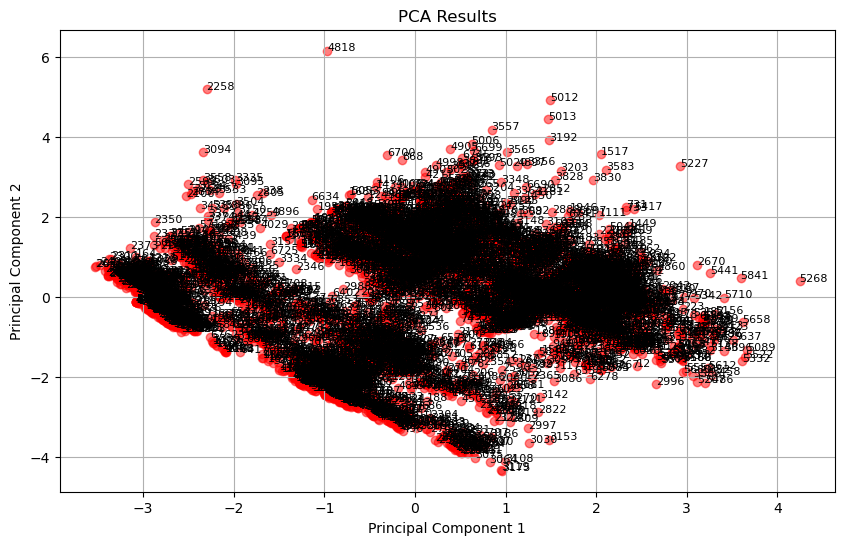

In [13]:
# Plotting the principal components
plt.figure(figsize=(10, 6))
plt.scatter(data_pca[0], data_pca[1], color='red', alpha=0.5)
for i, txt in enumerate(subset_data.index):
    plt.text(data_pca.iloc[i, 0], data_pca.iloc[i, 1], txt, fontsize=8)

plt.title('PCA Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [14]:
# own data 

flight_data1 = pd.read_csv('initial_test_data_for_prediction.csv')



flight_data1.head()
flight_data1.columns

,MKT_UNIQUE_CARRIER,OP_UNIQUE_CARRIER,ORIGIN,SCH_DEP_TIME,SCH_ARR_TIME,DAY_OF_WEEK,ORGIN_WTH_temp,ORGIN_WTH_precip,ORGIN_WTH_precipprob,ORGIN_WTH_snow,ORGIN_WTH_windspeed,ORGIN_WTH_winddir,ORGIN_WTH_cloudcover,ORGIN_WTH_visibility,ORGIN_WTH_severerisk,DEST_WTH_temp,DEST_WTH_precip,DEST_WTH_precipprob,DEST_WTH_snow,DEST_WTH_windspeed,DEST_WTH_winddir,DEST_WTH_cloudcover,DEST_WTH_visibility,DEST_WTH_severerisk
0,UA,UA,ORD,2024-04-10 18:52:00,2024-04-10 21:47:00,3,54.10,0.00,34.00,0,9.20,70.00,80.00,10.10,10,54.40,0.00,40.00,0,6.30,126.70,80.30,8.20,10
1,AA,MQ,ORD,2024-04-10 19:59:00,2024-04-10 22:52:00,3,53.00,0.00,27.00,0,8.70,50.00,81.30,10.10,10,53.30,0.00,40.00,0,6.30,130.00,82.00,7.30,10
2,B6,B6,JFK,2024-04-10 13:33:00,2024-04-10 14:50:00,3,54.90,0.03,44.00,0,9.20,110.00,90.00,3.70,10,63.20,0.00,45.00,0,9.80,283.30,70.70,9.80,10
3,DL,9E,JFK,2024-04-10 14:55:00,2024-04-10 16:21:00,3,55.30,0.00,44.00,0,9.20,100.00,88.30,3.30,10,62.70,0.00,45.00,0,9.60,306.70,66.30,9.40,10
4,WN,WN,MCO,2024-04-10 11:05:00,2024-04-10 13:45:00,3,79.10,0.00,3.00,0,15.00,150.00,43.00,10.10,10,63.90,0.05,45.00,0,10.30,260.00,75.00,10.10,10


Index(['MKT_UNIQUE_CARRIER', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'SCH_DEP_TIME',
       'SCH_ARR_TIME', 'DAY_OF_WEEK', 'ORGIN_WTH_temp', 'ORGIN_WTH_precip',
       'ORGIN_WTH_precipprob', 'ORGIN_WTH_snow', 'ORGIN_WTH_windspeed',
       'ORGIN_WTH_winddir', 'ORGIN_WTH_cloudcover', 'ORGIN_WTH_visibility',
       'ORGIN_WTH_severerisk', 'DEST_WTH_temp', 'DEST_WTH_precip',
       'DEST_WTH_precipprob', 'DEST_WTH_snow', 'DEST_WTH_windspeed',
       'DEST_WTH_winddir', 'DEST_WTH_cloudcover', 'DEST_WTH_visibility',
       'DEST_WTH_severerisk'],
      dtype='object')

In [15]:
# Handle Categorical Variables
categorical_vars1 = ['DAY_OF_WEEK', 'MKT_UNIQUE_CARRIER',
                    'OP_UNIQUE_CARRIER', 'ORIGIN',
                    'ORGIN_WTH_precipprob', 'ORGIN_WTH_severerisk',
                    'DEST_WTH_precipprob', 'DEST_WTH_severerisk','MONTH']

# categorical_vars = potential_categorical_vars.keys()

In [16]:
def preprocess1(flight_data1: pd.DataFrame):

    # Dealing with date and time
    flight_data1['SCH_ARR_TIME'] = pd.to_datetime(flight_data1['SCH_ARR_TIME'])
    flight_data1['SCH_DEP_TIME'] = pd.to_datetime(flight_data1['SCH_DEP_TIME'])

    flight_data1['MONTH'] = flight_data1['SCH_ARR_TIME'].dt.month
    flight_data1['DAY'] = flight_data1['SCH_ARR_TIME'].dt.day
    flight_data1['DEP_MINUTES'] = flight_data1['SCH_DEP_TIME'].dt.hour * 60 + flight_data1['SCH_DEP_TIME'].dt.minute
    flight_data1['ARR_MINUTES'] = flight_data1['SCH_ARR_TIME'].dt.hour * 60 + flight_data1['SCH_ARR_TIME'].dt.minute

    flight_data1.drop(columns=['SCH_DEP_TIME', 'SCH_ARR_TIME'], inplace=True)

    # Dropping unwanted columns
    cols = [
        'ORGIN_WTH_temp', 'DEST_WTH_temp',
        'DEST_WTH_severerisk', 'ORGIN_WTH_severerisk',
        'DEST_WTH_precipprob', 'ORGIN_WTH_precipprob'
        ]
    flight_data1.drop(columns=cols, inplace=True)
    
    cat_col1 = list(set(flight_data1.columns).intersection(categorical_vars1))
    flight_data1 = pd.get_dummies(flight_data1, columns = list(cat_col1), drop_first = False)

    return flight_data1
    

In [17]:
X1= preprocess1(flight_data1)

In [21]:
X1.head()
X1.shape
X1.columns

,ORGIN_WTH_precip,ORGIN_WTH_snow,ORGIN_WTH_windspeed,ORGIN_WTH_winddir,ORGIN_WTH_cloudcover,ORGIN_WTH_visibility,DEST_WTH_precip,DEST_WTH_snow,DEST_WTH_windspeed,DEST_WTH_winddir,DEST_WTH_cloudcover,DEST_WTH_visibility,DAY,DEP_MINUTES,ARR_MINUTES,MONTH_4,MKT_UNIQUE_CARRIER_AA,MKT_UNIQUE_CARRIER_B6,MKT_UNIQUE_CARRIER_DL,MKT_UNIQUE_CARRIER_UA,MKT_UNIQUE_CARRIER_WN,ORIGIN_JFK,ORIGIN_MCO,ORIGIN_ORD,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6
0,0.00,0,9.20,70.00,80.00,10.10,0.00,0,6.30,126.70,80.30,8.20,10,1132,1307,True,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False
1,0.00,0,8.70,50.00,81.30,10.10,0.00,0,6.30,130.00,82.00,7.30,10,1199,1372,True,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False
2,0.03,0,9.20,110.00,90.00,3.70,0.00,0,9.80,283.30,70.70,9.80,10,813,890,True,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False
3,0.00,0,9.20,100.00,88.30,3.30,0.00,0,9.60,306.70,66.30,9.40,10,895,981,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False
4,0.00,0,15.00,150.00,43.00,10.10,0.05,0,10.30,260.00,75.00,10.10,10,665,825,True,False,False,False,False,True,False,True,False,False,False,False,False,True,True,False,False,False


(23, 33)

Index(['ORGIN_WTH_precip', 'ORGIN_WTH_snow', 'ORGIN_WTH_windspeed',
       'ORGIN_WTH_winddir', 'ORGIN_WTH_cloudcover', 'ORGIN_WTH_visibility',
       'DEST_WTH_precip', 'DEST_WTH_snow', 'DEST_WTH_windspeed',
       'DEST_WTH_winddir', 'DEST_WTH_cloudcover', 'DEST_WTH_visibility', 'DAY',
       'DEP_MINUTES', 'ARR_MINUTES', 'MONTH_4', 'MKT_UNIQUE_CARRIER_AA',
       'MKT_UNIQUE_CARRIER_B6', 'MKT_UNIQUE_CARRIER_DL',
       'MKT_UNIQUE_CARRIER_UA', 'MKT_UNIQUE_CARRIER_WN', 'ORIGIN_JFK',
       'ORIGIN_MCO', 'ORIGIN_ORD', 'OP_UNIQUE_CARRIER_9E',
       'OP_UNIQUE_CARRIER_B6', 'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_UA',
       'OP_UNIQUE_CARRIER_WN', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6'],
      dtype='object')

In [20]:
cols2 = [
    "MKT_UNIQUE_CARRIER_DL",
    "OP_UNIQUE_CARRIER_B6",
    "ORGIN_WTH_visibility",
    "ORGIN_WTH_precip",
    "DEST_WTH_visibility",
    "ORIGIN_ORD",
    "DEP_MINUTES",
    "ORGIN_WTH_snow",
    "ORGIN_WTH_cloudcover",
    "DEST_WTH_snow",
    "OP_UNIQUE_CARRIER_OO",
    "DEST_WTH_precip",
    "ARR_MINUTES",
    "DEST_WTH_winddir",
    "OP_UNIQUE_CARRIER_MQ"
]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
subset_data1 = pd.DataFrame(sc.fit_transform(X1[cols2]), columns = X1[cols2].columns, index = X1.index)
subset_data1.shape
subset_data1.columns
subset_data1.head()

KeyError: "['OP_UNIQUE_CARRIER_OO'] not in index"

#### xgBoost

#### GradientBoosting

##### Random Forest